In [1]:
#  Required imports

print("Importing standard library")
import os, time, sys

print("Importing python data libraries")
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import tensorflow as tf

print("Importing custom backends")
sys.path.append("/Users/Ste/PostDoc/git-with-DP/SM-sandbox/proj5.4-EFT-Density-Estimation")
from backends.data_preparation import DataTable
from backends.stats            import special_whiten_dataset, special_unwhiten_dataset
from backends.utils            import joint_shuffle, make_sure_dir_exists_for_filename

print("Importing keras objects")
from keras.layers      import BatchNormalization, Dense, Dropout, Input, LeakyReLU, Concatenate, Lambda, Reshape, Softmax
from keras.models      import Model, Sequential
from keras.optimizers  import Adam, SGD, RMSprop
from keras.constraints import Constraint, MaxNorm
from keras.callbacks   import EarlyStopping

print("Importing keras backend")
import keras.backend as K

Importing standard library
Importing python data libraries
Importing custom backends
Importing keras objects
Importing keras backend


Using TensorFlow backend.


In [2]:
#  Inputs config

input_fname_QCD_events = "../Data/SM_QCD_rivet_output.pickle"

In [36]:
#  Model config

output_size_per_stage     = 10
max_epochs                = 1000
epoch_increase_per_level  = 100
early_stopping_patience   = 50
early_stopping_min_delta  = 2e-8
validation_split          = 0

do_whiten_data              = True
white_linear_fraction_data  = 0.3
white_linear_fraction_gauss = 0.3


In [4]:
#  Data config

observable_limits = {}
observable_limits ["m_ll"      ] = [75    , 105  ]
observable_limits ["pT_ll"     ] = [0     , 900  ]
observable_limits ["theta_ll"  ] = [0     , np.pi]
observable_limits ["rap_ll"    ] = [0     , 2.2  ]
observable_limits ["m_jj"      ] = [150   , 5000 ]
observable_limits ["pT_jj"     ] = [0     , 900  ]
observable_limits ["theta_jj"  ] = [0     , np.pi]
observable_limits ["rap_jj"    ] = [0     , 4.4  ]
observable_limits ["pT_j1"     ] = [40    , 1200 ]
observable_limits ["pT_j2"     ] = [35    , 1200 ]
observable_limits ["Dy_j_j"    ] = [0     , 8.8  ]
observable_limits ["Dphi_j_j"  ] = [-np.pi, np.pi]
observable_limits ["N_jets"    ] = [2     , 100  ]
observable_limits ["N_gap_jets"] = [0     , 3    ]

remove_observables = ["N_jets", "N_gap_jets"]

In [25]:
def gauss_prob (x, mean, sigma) :
    prob = K.exp(-0.5*(x - mean)*(x - mean)/(sigma*sigma)) / K.sqrt(2*np.pi*sigma*sigma)
    return tf.where(tf.is_nan(prob), tf.zeros_like(prob), prob)


def datapoint_likelihood (x, num_gauss, gauss_fracs, gauss_means, gauss_sigmas) :
    prob = 0.
    x = x[:,0]
    for i in range(num_gauss) :
        prob = prob + gauss_fracs[:,i] * gauss_prob(x, gauss_means[:,i], gauss_sigmas[:,i])
    return prob


def datapoint_log_likelihood (x, num_gauss, gauss_fracs, gauss_means, gauss_sigmas) :
    log_L = K.log(datapoint_likelihood(x, num_gauss, gauss_fracs, gauss_means, gauss_sigmas))
    return  log_L  # tf.where(tf.is_nan(log_L), -1e-12*tf.ones_like(log_L), log_L)


def dataset_mean_likelihood  (x, params, num_gauss) :
    return K.mean(datapoint_likelihood(x, num_gauss, gauss_fracs, gauss_means, gauss_sigmas))  


def dataset_likelihood (x, params, num_gauss) :
    prod_L = K.prod(datapoint_likelihood(x, num_gauss, gauss_fracs, gauss_means, gauss_sigmas))  
    return tf.where(tf.is_nan(prod_L), tf.zeros_like(prod_L), prod_L)
        

def dataset_mean_log_likelihood (x, params, num_gauss) :
    gauss_fracs, gauss_means, gauss_sigmas = params[:,:num_gauss], params[:,num_gauss:2*num_gauss], params[:,2*num_gauss:3*num_gauss]
    return K.mean(datapoint_log_likelihood(x, num_gauss, gauss_fracs, gauss_means, gauss_sigmas))    
    
    
def add_gauss_mean_offsets (x, num_gauss, offset_min, offset_max):
    c = tf.convert_to_tensor([offset_min + (offset_max-offset_min)*i/(num_gauss-1.) for i in range(num_gauss)])
    return x + c


def add_gauss_fraction_offsets (x, num_gauss):
    c = tf.convert_to_tensor([0. for i in range(num_gauss)])
    return x + c


def add_gauss_sigma_offsets (x, num_gauss):
    c = tf.convert_to_tensor([0. for i in range(num_gauss)])
    return x + c


def create_autoreg_density_model (name, **kwargs) :
    #  Parse arguments
    #
    num_conditions_in  = int (kwargs.get("num_conditions_in"    ))
    num_observables_in = int (kwargs.get("num_observables_in", 0))
    num_gaussians      = int (kwargs.get("num_gaussians"     , 5))
    verbose            = bool(kwargs.get("verbose" , True))
    
    #  Print a status message
    #
    if verbose : 
        print(f"Creating density model: {name}")
        print(f"  - num_conditions_in  is {num_conditions_in}")
        print(f"  - num_observables_in is {num_observables_in}")
        print(f"  - num_gaussians      is {num_gaussians}")
    
    #  Create model layers
    #
    conditions_input  = Input((num_conditions_in ,))
    model_conditions  = Dense      (10 )(conditions_input ) 
    model_conditions  = LeakyReLU  (0.2)(model_conditions )
    if num_observables_in > 0 :
        observables_input = Input((num_observables_in,))
        model_observables = Dense      (3*num_observables_in)(observables_input)    
        model_observables = LeakyReLU  (0.2                 )(model_observables)
        model             = Concatenate(   )([model_conditions, model_observables])
    else :
        model = model_conditions
    model             = Dense      (10 + 3*num_observables_in)(model )
    model             = LeakyReLU  (0.2             )(model          )
    gauss_means       = Dense      (3*num_gaussians )(model          )
    gauss_means       = LeakyReLU  (0.2             )(gauss_means    )
    gauss_sigmas      = Dense      (3*num_gaussians )(model          )
    gauss_sigmas      = LeakyReLU  (0.2             )(gauss_sigmas   )
    gauss_fractions   = Dense      (3*num_gaussians )(model          )
    gauss_fractions   = LeakyReLU  (0.2             )(gauss_fractions)
    
    #  Format Gaussian means so they start equally placed
    #
    gauss_means       = Dense (num_gaussians, activation="linear"  )(gauss_means)
    add_initial_mean_offsets = lambda x : add_gauss_mean_offsets(x, num_gaussians, -5, 5)
    gauss_means              = Lambda(add_initial_mean_offsets)(gauss_means)
    
    #  Format Gaussian sigmas so they are positive nonzero
    #
    add_initial_sigma_offsets = lambda x : add_gauss_sigma_offsets(x, num_gaussians)
    gauss_sigmas              = Dense (num_gaussians                       )(gauss_sigmas)
    gauss_sigmas              = Lambda(add_initial_sigma_offsets           )(gauss_sigmas)
    gauss_sigmas              = Dense (num_gaussians, activation="softplus")(gauss_sigmas)
    
    #  Format Gaussian fractions so they sum to one
    #
    add_initial_frac_offsets = lambda x : add_gauss_fraction_offsets(x, num_gaussians)
    gauss_fractions          = Dense  (num_gaussians                       )(gauss_fractions)
    gauss_fractions          = Lambda (add_initial_frac_offsets            )(gauss_fractions)
    gauss_fractions          = Softmax(                                    )(gauss_fractions)
    
    #  Concatenate model output
    #
    model             = Concatenate()([gauss_fractions, gauss_means, gauss_sigmas])
    if num_observables_in > 0 : model = Model ([conditions_input, observables_input], model, name=name)
    else                      : model = Model (conditions_input, model, name=name)
    
    #  Compile model
    #
    loss_function = lambda y_true, y_pred : -1. * dataset_mean_log_likelihood (y_true, y_pred, num_gaussians)
    model.compile(loss=loss_function, optimizer=Adam())    
    if verbose : model.summary()
     
    #  Return model
    #   
    return model

In [26]:
def gauss_prob_np (x, mean, sigma) :
    return np.exp(-0.5*(x - mean)*(x - mean)/(sigma*sigma)) / np.sqrt(2*np.pi*sigma*sigma)

def datapoint_likelihood_np (x, num_gauss, gauss_fracs, gauss_means, gauss_sigmas) :
    prob = 0.
    for i in range(num_gauss) :
        prob = prob + gauss_fracs[i] * gauss_prob_np(x, gauss_means[i], gauss_sigmas[i])
    return prob

def get_sum_gauss_density (x, params) :
    num_gauss = int(len(params) / 3)
    fracs, means, sigmas = params[:num_gauss], params[num_gauss:2*num_gauss], params[2*num_gauss:3*num_gauss]
    return datapoint_likelihood_np (x, num_gauss, fracs, means, sigmas)

def sample_sum_gaussians (n_points, params) :
    num_gauss = int(len(params) / 3)
    fracs, means, sigmas = params[:num_gauss], params[num_gauss:2*num_gauss], params[2*num_gauss:3*num_gauss]
    which_gauss     = np.random.choice(num_gauss, size=(n_points,), p=fracs)
    n_pts_per_gauss = [len([x for x in which_gauss if x == i]) for i in range(num_gauss)]
    points = []
    for i in range(num_gauss) :
        points.append(np.random.normal(means[i], sigmas[i], n_pts_per_gauss[i]))
    return np.concatenate(points)

In [33]:
class DensityModel :
    def __init__ (self, **kwargs) :
        self.construct(**kwargs)
    def build (self, verbose=True) :
        build_settings    = {"name":self.name, "num_gaussians":self.num_gaussians, "num_conditions":self.num_conditions, "num_observables":self.num_observables}
        likelihood_models = []
        for i in range(self.num_observables) :
            model_segment_name = build_settings["name"]+f"_observable{i}"
            if verbose : print("INFO".ljust(8) + "   " + "DensityModel.build".ljust(25) + "   " + f"Building model segment: {model_segment_name} for observable index {i}")
            density_model = create_autoreg_density_model(model_segment_name,
                                                         num_gaussians      = build_settings["num_gaussians" ] ,
                                                         num_conditions_in  = build_settings["num_conditions"] ,
                                                         num_observables_in = i                                ,
                                                         verbose            = verbose                          )
            likelihood_models.append(density_model)
        if verbose : print("INFO".ljust(8) + "   " + "DensityModel.build".ljust(25) + "   " + f"{len(likelihood_models)} partial density models constructed")
        self.build_settings    = build_settings
        self.likelihood_models = likelihood_models
    def construct (self, **kwargs) :
        name            = kwargs.get("name"           , None )
        num_gaussians   = kwargs.get("num_gaussians"  , None )
        num_conditions  = kwargs.get("num_conditions" , None )
        num_observables = kwargs.get("num_observables", None )
        verbose         = kwargs.get("verbose"        , True ) 
        do_build        = kwargs.get("build"          , True )        
        if (type(name)            == type(None)) and (hasattr(self, "name"           )) :
            if verbose      : print(f"No name argument provided - using stored value")
            name            = self.name
        if (type(num_gaussians)   == type(None)) and (hasattr(self, "num_gaussians"  )) :
            if verbose      : print(f"No num_gaussians argument provided - using stored value")
            num_gaussians   = self.num_gaussians
        if (type(num_conditions)  == type(None)) and (hasattr(self, "num_conditions" )) :
            if verbose      : print(f"No num_conditions argument provided - using stored value")
            num_conditions  = self.num_conditions
        if (type(num_observables) == type(None)) and (hasattr(self, "num_observables")) :
            if verbose      : print(f"No num_observables argument provided - using stored value")
            num_observables = self.num_observables
        if type(name)            != str : raise TypeError(f"name argument {name} of type {type(name)} where {type(int)} expected")
        if type(num_gaussians)   != int : raise TypeError(f"num_gaussians argument {num_gaussians} of type {type(num_gaussians)} where {type(int)} expected")
        if type(num_conditions)  != int : raise TypeError(f"num_conditions argument {num_conditions} of type {type(num_conditions)} where {type(int)} expected")
        if type(num_observables) != int : raise TypeError(f"num_observables argument {num_observables} of type {type(num_observables)} where {type(int)} expected")
        if num_gaussians   < 1 : raise ValueError(f"num_gaussians must be > 0, but {num_gaussians} provided")
        if num_conditions  < 1 : raise ValueError(f"num_conditions must be > 0, but {num_conditions} provided")
        if num_observables < 1 : raise ValueError(f"num_observables must be > 0, but {num_observables} provided")
        print("INFO".ljust(8) + "   " + "DensityModel.construct".ljust(25) + "   " + f"Set model name           : {name}"           )
        print("INFO".ljust(8) + "   " + "DensityModel.construct".ljust(25) + "   " + f"Set model num_gaussians  : {num_gaussians}"  )
        print("INFO".ljust(8) + "   " + "DensityModel.construct".ljust(25) + "   " + f"Set model num_conditions : {num_conditions}" )
        print("INFO".ljust(8) + "   " + "DensityModel.construct".ljust(25) + "   " + f"Set model num_observables: {num_observables}")
        self.name            = name
        self.num_gaussians   = num_gaussians
        self.num_conditions  = num_conditions
        self.num_observables = num_observables
        if do_build is False : return
        self.build(verbose=verbose)
    def evaluate (self, conditions, *observables) :
        num_observables = len(observables)
        params_obs0  = self.likelihood_models[0].predict([conditions])[0]
        density      = get_sum_gauss_density (observables[0], params_obs0)
        for obs_idx in range(1, num_observables) :
            params_obsN  = self.likelihood_models[obs_idx].predict([[conditions], observables[:obs_idx]])[0]
            density_N    = get_sum_gauss_density (observables[obs_idx], params_obsN)
            density      = density * density_N
        return density
    def fit (self, dataset, weights=None, **kwargs) :                                     
        #  Parse settings
        #
        observable_idx            = kwargs.get("observable"               , None )
        max_epochs_per_observable = kwargs.get("max_epochs_per_observable", 2000 )
        early_stopping_patience   = kwargs.get("early_stopping_patience"  , 100  )
        early_stopping_min_delta  = kwargs.get("early_stopping_min_delta" , 0    )
        batch_size_per_observable = kwargs.get("batch_size_per_observable", -1   )
        validation_split          = kwargs.get("validation_split"         , 0.3  )
        do_build                  = kwargs.get("build"                    , False)
        verbose                   = kwargs.get("verbose"                  , True )
        tf_verbose                = kwargs.get("tf_verbose"               , 1    )
        monitor = "val_loss"
        if validation_split <= 0 : monitor = "loss"
        
        early_stopping_min_delta
                                                        
        #  (Re-)build model if requested
        #
        if do_build : self.build(**kwargs)
                                                           
        #  Make sure model has been built, and with the same settings as currently set
        #                                     
        if hasattr(self, "build_settings") is False : raise RuntimeError(f"self.build_settings does not exist - you must call self.build() before self.fit(), or specify self.fit(build=True)")                                     
        build_settings = {"name":self.name, "num_gaussians":self.num_gaussians, "num_conditions":self.num_conditions, "num_observables":self.num_observables}
        for setting, value in build_settings.items() :
            built_value = self.build_settings [setting]
            if built_value == value : continue
            raise ValueError(f"Setting {setting}={value} has changed since last build (with {setting}={built_value}. You must specify self.fit(build=True) if you want to re-build the model.")
                                                                
        #  Collect list of observable indices to be trained
        #                                       
        if   type(observable_idx) == type(None) : observable_indices = [i for i in range(self.num_observables)]
        elif type(observable_idx) == int        : observable_indices = [observable_idx]
        elif type(observable_idx) == list       : observable_indices = observable_idx
        elif type(observable_idx) == np.ndarray : observable_indices = [i for i in observable_idx]
        else : raise TypeError(f"Observable {observable_idx} of type {type(observable_idx)} could not be interpreted as an integer, or list of integers")
        for index in observable_indices :
            if (type(index) == int) and (index >= 0) and (index < self.num_observables) : continue
            raise TypeError(f"Observable indices must be integers but {type(index)}={index} provided")  
        if verbose : print("INFO".ljust(8) + "   " + "DensityModel.fit".ljust(25) + "   " + f"Queued the following observable indices to train: {', '.join([str(x) for x in observable_indices])}")                                    
                                                               
        #  Parse dataset to be fit
        #             
        if verbose : print("INFO".ljust(8) + "   " + "DensityModel.fit".ljust(25) + "   " + "Parsing training data")
        train_data_cond, train_data_obs, train_data_weights = [], [], []
        for condition, datapoints in dataset.items() :
            train_data_weights.append(weights [condition])
            for datapoint in datapoints :
                train_data_cond.append(condition)
                train_data_obs .append(datapoint)
        train_data_weights = np.concatenate(train_data_weights)
        train_data_cond, train_data_obs, train_data_weights = joint_shuffle(train_data_cond, train_data_obs, train_data_weights)
        train_data_cond, train_data_obs = np.array(train_data_cond), np.array(train_data_obs)
                                                     
        #  Loop over target observables
        #  
        for observable_idx in observable_indices :
            if verbose :
                print("INFO".ljust(8) + "   " + "DensityModel.fit".ljust(25) + "   " + f"Training observable index {observable_idx}")
                print("INFO".ljust(8) + "   " + "DensityModel.fit".ljust(25) + "   " + f"  -  Training setting: epochs = {max_epochs_per_observable}")
                print("INFO".ljust(8) + "   " + "DensityModel.fit".ljust(25) + "   " + f"  -  Training setting: batch_size = {batch_size_per_observable}")
                print("INFO".ljust(8) + "   " + "DensityModel.fit".ljust(25) + "   " + f"  -  Training setting: validation_split = {validation_split}")
                print("INFO".ljust(8) + "   " + "DensityModel.fit".ljust(25) + "   " + f"  -  Training setting: early_stopping_patience = {early_stopping_patience}")     
                print("INFO".ljust(8) + "   " + "DensityModel.fit".ljust(25) + "   " + f"  -  Training setting: early_stopping_min_delta = {early_stopping_min_delta}")                                           
            #  Project training data along appropriate axes
            #  
            if observable_idx == 0 :
                train_data_X = train_data_cond
            else :
                train_data_X_obs = train_data_obs[:, :observable_idx]
                train_data_X = [train_data_cond, train_data_X_obs]
            n_data = len(train_data_cond)
            if (batch_size_per_observable > n_data) or (batch_size_per_observable <= 0) :
                print("INFO".ljust(8) + "   " + "DensityModel.fit".ljust(25) + "   " + f"Setting batch size to size of dataset, which is {n_data}")
                batch_size = n_data
            else : batch_size = batch_size_per_observable
            train_data_Y = train_data_obs[:,observable_idx]
            start_time = time.time()
            self.likelihood_models[observable_idx].fit(train_data_X,
                                                       train_data_Y,
                                                       sample_weight    = train_data_weights,
                                                       validation_split = validation_split,
                                                       epochs           = max_epochs_per_observable,
                                                       shuffle          = True,
                                                       batch_size       = batch_size,
                                                       callbacks        = [EarlyStopping(patience=early_stopping_patience, restore_best_weights=True, monitor=monitor, min_delta=early_stopping_min_delta)])
            print(f"Fit completed in {int(time.time() - start_time):.0f}s")
    def sample (self, conditions, n_points, num_observables=None, verbose=True) :
        if type(num_observables) == type(None) :
            num_observables = self.num_observables
        params_obs0 = self.likelihood_models[0].predict([conditions])[0]
        X1 = sample_sum_gaussians (n_points, params_obs0)
        dp_conditions = [conditions for i in range(n_points)]
        X1_to_XN = [X1]
        for obs_idx in range(1, num_observables) :
            if verbose : print("INFO".ljust(8) + "   " + "DensityModel.sample".ljust(25) + "   " + f"Getting Gaussian parameters for {n_points} datapoints, observable index is {obs_idx}")  
            params_obsN = self.likelihood_models[obs_idx].predict([dp_conditions, np.array(X1_to_XN).transpose()])
            XN = []
            if verbose : print("INFO".ljust(8) + "   " + "DensityModel.sample".ljust(25) + "   " + f"Sampling Gaussians for {n_points} datapoints, observable index is {obs_idx}")  
            for dp_idx, paramsN in enumerate(params_obsN) : 
                XN.append(sample_sum_gaussians (1, params_obsN[dp_idx])[0])
            X1_to_XN.append(XN)
        return np.array(X1_to_XN).transpose()



In [34]:
data = DataTable(input_fname_QCD_events)
data.print_summary()

for idx, observable in enumerate(data.keys) :
    vals = [x for x in data.events[:,idx] if x != -99]
    print(f"Observable {observable} betwen {np.min(vals)} and {np.max(vals)}")

print(f"Data loaded with {data.get_num_events()} events")
for observable, limits in observable_limits.items() :
    print(f"Filtering observable {observable} between {limits[0]} and {limits[1]}")
    data.filter(observable, limits[0], limits[1])
    print(f"{data.get_num_events()} events survived")

for observable in remove_observables :
    print(f"Removing observable {observable}")
    data.remove_column(observable)

data.print_summary()

* Registered the following keys:
    +---------------------------------------+
    | Column | Name       | Type            |
    +---------------------------------------+
    | 0      | weight     | <class 'float'> |
    | 1      | m_ll       | <class 'float'> |
    | 2      | pT_ll      | <class 'float'> |
    | 3      | theta_ll   | <class 'float'> |
    | 4      | rap_ll     | <class 'float'> |
    | 5      | m_jj       | <class 'float'> |
    | 6      | pT_jj      | <class 'float'> |
    | 7      | theta_jj   | <class 'float'> |
    | 8      | rap_jj     | <class 'float'> |
    | 9      | pT_j1      | <class 'float'> |
    | 10     | pT_j2      | <class 'float'> |
    | 11     | Dy_j_j     | <class 'float'> |
    | 12     | Dphi_j_j   | <class 'float'> |
    | 13     | N_jets     | <class 'int'>   |
    | 14     | N_gap_jets | <class 'int'>   |
    +---------------------------------------+

* Number of events       : 200000
* Cross section per event: 0.241492
* Sum of weights      

In [35]:
density_model = DensityModel(name            = "QCD_density_model", 
                             num_gaussians   = output_size_per_stage, 
                             num_conditions  = 1, 
                             num_observables = data.get_num_keys() - 1, 
                             verbose         = True)

INFO       DensityModel.construct      Set model name           : QCD_density_model
INFO       DensityModel.construct      Set model num_gaussians  : 10
INFO       DensityModel.construct      Set model num_conditions : 1
INFO       DensityModel.construct      Set model num_observables: 12
INFO       DensityModel.build          Building model segment: QCD_density_model_observable0 for observable index 0
Creating density model: QCD_density_model_observable0
  - num_conditions_in  is 1
  - num_observables_in is 0
  - num_gaussians      is 10
Model: "QCD_density_model_observable0"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_47 (InputLayer)           (None, 1)            0                                            
__________________________________________________________________________________________________
dense_227 (Dense)   

Model: "QCD_density_model_observable2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_50 (InputLayer)           (None, 1)            0                                            
__________________________________________________________________________________________________
input_51 (InputLayer)           (None, 2)            0                                            
__________________________________________________________________________________________________
dense_246 (Dense)               (None, 10)           20          input_50[0][0]                   
__________________________________________________________________________________________________
dense_247 (Dense)               (None, 6)            18          input_51[0][0]                   
______________________________________________________________________

Model: "QCD_density_model_observable4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_54 (InputLayer)           (None, 1)            0                                            
__________________________________________________________________________________________________
input_55 (InputLayer)           (None, 4)            0                                            
__________________________________________________________________________________________________
dense_266 (Dense)               (None, 10)           20          input_54[0][0]                   
__________________________________________________________________________________________________
dense_267 (Dense)               (None, 12)           60          input_55[0][0]                   
______________________________________________________________________

Model: "QCD_density_model_observable6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_58 (InputLayer)           (None, 1)            0                                            
__________________________________________________________________________________________________
input_59 (InputLayer)           (None, 6)            0                                            
__________________________________________________________________________________________________
dense_286 (Dense)               (None, 10)           20          input_58[0][0]                   
__________________________________________________________________________________________________
dense_287 (Dense)               (None, 18)           126         input_59[0][0]                   
______________________________________________________________________

Model: "QCD_density_model_observable8"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_62 (InputLayer)           (None, 1)            0                                            
__________________________________________________________________________________________________
input_63 (InputLayer)           (None, 8)            0                                            
__________________________________________________________________________________________________
dense_306 (Dense)               (None, 10)           20          input_62[0][0]                   
__________________________________________________________________________________________________
dense_307 (Dense)               (None, 24)           216         input_63[0][0]                   
______________________________________________________________________

Model: "QCD_density_model_observable10"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_66 (InputLayer)           (None, 1)            0                                            
__________________________________________________________________________________________________
input_67 (InputLayer)           (None, 10)           0                                            
__________________________________________________________________________________________________
dense_326 (Dense)               (None, 10)           20          input_66[0][0]                   
__________________________________________________________________________________________________
dense_327 (Dense)               (None, 30)           330         input_67[0][0]                   
_____________________________________________________________________

In [10]:
#  Seperate data from weights
observable_data, weight_data = data.get_observables_and_weights()
data_to_fit    = {0: observable_data}
weights_to_fit = {0: weight_data}

#  Whiten data
axis_configs = [[item[0], item[1], 400,  white_linear_fraction_data, white_linear_fraction_gauss] for key,item in observable_limits.items() if key not in remove_observables]
white_dataset, whitening_funcs, whitening_params = special_whiten_dataset (observable_data, *axis_configs,  rotate=False)
white_data_to_fit = {0: white_dataset}

#  Sanity check - data and weights have expected shape
print(white_data_to_fit [0].shape)
print(weights_to_fit    [0].shape)


(120349, 12)
(120349,)


In [38]:
fit_times = {}
for obs_idx in range(white_data_to_fit[0].shape[1]) :
    fit_start_time = time.time()
    num_epochs = max_epochs + obs_idx*epoch_increase_per_level
    density_model.fit(white_data_to_fit, 
                      weights_to_fit,
                      observable                = obs_idx,
                      max_epochs_per_observable = num_epochs,
                      early_stopping_patience   = early_stopping_patience,
                      early_stopping_min_delta  = early_stopping_min_delta,
                      validation_split          = validation_split)
    fit_times [obs_idx] = [num_epochs, time.time() - fit_start_time]

INFO       DensityModel.fit            Queued the following observable indices to train: 0
INFO       DensityModel.fit            Parsing training data
INFO       DensityModel.fit            Training observable index 0
INFO       DensityModel.fit              -  Training setting: epochs = 1000
INFO       DensityModel.fit              -  Training setting: batch_size = -1
INFO       DensityModel.fit              -  Training setting: validation_split = 0
INFO       DensityModel.fit              -  Training setting: early_stopping_patience = 50
INFO       DensityModel.fit              -  Training setting: early_stopping_min_delta = 2e-08
INFO       DensityModel.fit            Setting batch size to size of dataset, which is 120349
Epoch 1/1000
120349/120349 [==============================] - 0s 2us/step - loss: 6.3645e-04
Epoch 2/1000
120349/120349 [==============================] - 0s 2us/step - loss: 6.3645e-04
Epoch 3/1000
120349/120349 [==============================] - 0s 2us/step - lo

Epoch 22/1100
120349/120349 [==============================] - 0s 3us/step - loss: 6.0342e-04
Epoch 23/1100
120349/120349 [==============================] - 0s 3us/step - loss: 6.0338e-04
Epoch 24/1100
120349/120349 [==============================] - 0s 3us/step - loss: 6.0334e-04
Epoch 25/1100
120349/120349 [==============================] - 0s 3us/step - loss: 6.0331e-04
Epoch 26/1100
120349/120349 [==============================] - 0s 3us/step - loss: 6.0327e-04
Epoch 27/1100
120349/120349 [==============================] - 0s 3us/step - loss: 6.0324e-04
Epoch 28/1100
120349/120349 [==============================] - 0s 3us/step - loss: 6.0320e-04
Epoch 29/1100
120349/120349 [==============================] - 0s 3us/step - loss: 6.0317e-04
Epoch 30/1100
120349/120349 [==============================] - 0s 3us/step - loss: 6.0314e-04
Epoch 31/1100
120349/120349 [==============================] - 0s 3us/step - loss: 6.0310e-04
Epoch 32/1100
120349/120349 [==============================]

120349/120349 [==============================] - 0s 3us/step - loss: 6.0145e-04
Epoch 110/1100
120349/120349 [==============================] - 0s 3us/step - loss: 6.0144e-04
Epoch 111/1100
120349/120349 [==============================] - 0s 3us/step - loss: 6.0142e-04
Epoch 112/1100
120349/120349 [==============================] - 0s 3us/step - loss: 6.0141e-04
Epoch 113/1100
120349/120349 [==============================] - 0s 3us/step - loss: 6.0140e-04
Epoch 114/1100
120349/120349 [==============================] - 0s 3us/step - loss: 6.0138e-04
Epoch 115/1100
120349/120349 [==============================] - 0s 3us/step - loss: 6.0137e-04
Epoch 116/1100
120349/120349 [==============================] - 0s 3us/step - loss: 6.0135e-04
Epoch 117/1100
120349/120349 [==============================] - 0s 3us/step - loss: 6.0134e-04
Epoch 118/1100
120349/120349 [==============================] - 0s 3us/step - loss: 6.0133e-04
Epoch 119/1100
120349/120349 [==============================] - 0

Epoch 196/1100
120349/120349 [==============================] - 0s 3us/step - loss: 6.0053e-04
Epoch 197/1100
120349/120349 [==============================] - 0s 4us/step - loss: 6.0052e-04
Epoch 198/1100
120349/120349 [==============================] - 0s 3us/step - loss: 6.0051e-04
Epoch 199/1100
120349/120349 [==============================] - 0s 4us/step - loss: 6.0050e-04
Epoch 200/1100
120349/120349 [==============================] - 0s 3us/step - loss: 6.0049e-04
Epoch 201/1100
120349/120349 [==============================] - 0s 4us/step - loss: 6.0049e-04
Epoch 202/1100
120349/120349 [==============================] - 0s 3us/step - loss: 6.0048e-04
Epoch 203/1100
120349/120349 [==============================] - 0s 4us/step - loss: 6.0047e-04
Epoch 204/1100
120349/120349 [==============================] - 0s 4us/step - loss: 6.0046e-04
Epoch 205/1100
120349/120349 [==============================] - 0s 3us/step - loss: 6.0046e-04
Epoch 206/1100
120349/120349 [====================

Epoch 283/1100
120349/120349 [==============================] - 0s 3us/step - loss: 5.9990e-04
Epoch 284/1100
120349/120349 [==============================] - 0s 3us/step - loss: 5.9989e-04
Epoch 285/1100
120349/120349 [==============================] - 0s 3us/step - loss: 5.9989e-04
Epoch 286/1100
120349/120349 [==============================] - 0s 3us/step - loss: 5.9988e-04
Epoch 287/1100
120349/120349 [==============================] - 0s 3us/step - loss: 5.9987e-04
Epoch 288/1100
120349/120349 [==============================] - 0s 3us/step - loss: 5.9986e-04
Epoch 289/1100
120349/120349 [==============================] - 0s 3us/step - loss: 5.9985e-04
Epoch 290/1100
120349/120349 [==============================] - 0s 3us/step - loss: 5.9984e-04
Epoch 291/1100
120349/120349 [==============================] - 0s 3us/step - loss: 5.9983e-04
Epoch 292/1100
120349/120349 [==============================] - 0s 3us/step - loss: 5.9982e-04
Epoch 293/1100
120349/120349 [====================

Epoch 370/1100
120349/120349 [==============================] - 0s 3us/step - loss: 5.9838e-04
Epoch 371/1100
120349/120349 [==============================] - 0s 3us/step - loss: 5.9836e-04
Epoch 372/1100
120349/120349 [==============================] - 0s 3us/step - loss: 5.9833e-04
Epoch 373/1100
120349/120349 [==============================] - 0s 3us/step - loss: 5.9831e-04
Epoch 374/1100
120349/120349 [==============================] - 0s 3us/step - loss: 5.9829e-04
Epoch 375/1100
120349/120349 [==============================] - 0s 3us/step - loss: 5.9827e-04
Epoch 376/1100
120349/120349 [==============================] - 0s 3us/step - loss: 5.9825e-04
Epoch 377/1100
120349/120349 [==============================] - 0s 3us/step - loss: 5.9823e-04
Epoch 378/1100
120349/120349 [==============================] - 0s 3us/step - loss: 5.9821e-04
Epoch 379/1100
120349/120349 [==============================] - 0s 3us/step - loss: 5.9819e-04
Epoch 380/1100
120349/120349 [====================

Epoch 457/1100
120349/120349 [==============================] - 0s 3us/step - loss: 5.9762e-04
Epoch 458/1100
120349/120349 [==============================] - 0s 3us/step - loss: 5.9761e-04
Epoch 459/1100
120349/120349 [==============================] - 0s 3us/step - loss: 5.9761e-04
Epoch 460/1100
120349/120349 [==============================] - 0s 3us/step - loss: 5.9761e-04
Epoch 461/1100
120349/120349 [==============================] - 0s 3us/step - loss: 5.9761e-04
Epoch 462/1100
120349/120349 [==============================] - 0s 3us/step - loss: 5.9760e-04
Epoch 463/1100
120349/120349 [==============================] - 0s 3us/step - loss: 5.9760e-04
Epoch 464/1100
120349/120349 [==============================] - 0s 3us/step - loss: 5.9760e-04
Epoch 465/1100
120349/120349 [==============================] - 0s 3us/step - loss: 5.9760e-04
Epoch 466/1100
120349/120349 [==============================] - 0s 3us/step - loss: 5.9759e-04
Epoch 467/1100
120349/120349 [====================

Epoch 544/1100
120349/120349 [==============================] - 0s 3us/step - loss: 5.9746e-04
Epoch 545/1100
120349/120349 [==============================] - 0s 3us/step - loss: 5.9746e-04
Epoch 546/1100
120349/120349 [==============================] - 0s 3us/step - loss: 5.9746e-04
Epoch 547/1100
120349/120349 [==============================] - 0s 3us/step - loss: 5.9746e-04
Epoch 548/1100
120349/120349 [==============================] - 0s 3us/step - loss: 5.9745e-04
Epoch 549/1100
120349/120349 [==============================] - 0s 3us/step - loss: 5.9745e-04
Epoch 550/1100
120349/120349 [==============================] - 0s 3us/step - loss: 5.9745e-04
Epoch 551/1100
120349/120349 [==============================] - 0s 3us/step - loss: 5.9745e-04
Epoch 552/1100
120349/120349 [==============================] - 0s 3us/step - loss: 5.9745e-04
Epoch 553/1100
120349/120349 [==============================] - 0s 3us/step - loss: 5.9745e-04
Epoch 554/1100
120349/120349 [====================

Epoch 631/1100
120349/120349 [==============================] - 0s 3us/step - loss: 5.9736e-04
Epoch 632/1100
120349/120349 [==============================] - 0s 3us/step - loss: 5.9736e-04
Epoch 633/1100
120349/120349 [==============================] - 0s 3us/step - loss: 5.9736e-04
Epoch 634/1100
120349/120349 [==============================] - 0s 3us/step - loss: 5.9736e-04
Epoch 635/1100
120349/120349 [==============================] - 0s 3us/step - loss: 5.9736e-04
Epoch 636/1100
120349/120349 [==============================] - 0s 3us/step - loss: 5.9736e-04
Epoch 637/1100
120349/120349 [==============================] - 0s 3us/step - loss: 5.9736e-04
Epoch 638/1100
120349/120349 [==============================] - 0s 3us/step - loss: 5.9736e-04
Epoch 639/1100
120349/120349 [==============================] - 0s 3us/step - loss: 5.9735e-04
Epoch 640/1100
120349/120349 [==============================] - 0s 3us/step - loss: 5.9735e-04
Epoch 641/1100
120349/120349 [====================

Epoch 718/1100
120349/120349 [==============================] - 0s 3us/step - loss: 5.9729e-04
Epoch 719/1100
120349/120349 [==============================] - 0s 3us/step - loss: 5.9729e-04
Epoch 720/1100
120349/120349 [==============================] - 0s 3us/step - loss: 5.9729e-04
Epoch 721/1100
120349/120349 [==============================] - 0s 3us/step - loss: 5.9729e-04
Epoch 722/1100
120349/120349 [==============================] - 0s 3us/step - loss: 5.9729e-04
Epoch 723/1100
120349/120349 [==============================] - 0s 3us/step - loss: 5.9729e-04
Epoch 724/1100
120349/120349 [==============================] - 0s 3us/step - loss: 5.9729e-04
Epoch 725/1100
120349/120349 [==============================] - 0s 3us/step - loss: 5.9729e-04
Epoch 726/1100
120349/120349 [==============================] - 0s 3us/step - loss: 5.9729e-04
Epoch 727/1100
120349/120349 [==============================] - 0s 3us/step - loss: 5.9729e-04
Epoch 728/1100
120349/120349 [====================

Epoch 805/1100
120349/120349 [==============================] - 0s 3us/step - loss: 5.9724e-04
Epoch 806/1100
120349/120349 [==============================] - 0s 3us/step - loss: 5.9724e-04
Epoch 807/1100
120349/120349 [==============================] - 0s 3us/step - loss: 5.9724e-04
Epoch 808/1100
120349/120349 [==============================] - 0s 3us/step - loss: 5.9724e-04
Epoch 809/1100
120349/120349 [==============================] - 0s 3us/step - loss: 5.9724e-04
Epoch 810/1100
120349/120349 [==============================] - 0s 3us/step - loss: 5.9723e-04
Epoch 811/1100
120349/120349 [==============================] - 0s 3us/step - loss: 5.9723e-04
Epoch 812/1100
120349/120349 [==============================] - 0s 3us/step - loss: 5.9723e-04
Epoch 813/1100
120349/120349 [==============================] - 0s 3us/step - loss: 5.9723e-04
Epoch 814/1100
120349/120349 [==============================] - 0s 3us/step - loss: 5.9723e-04
Epoch 815/1100
120349/120349 [====================

Epoch 892/1100
120349/120349 [==============================] - 0s 3us/step - loss: 5.9718e-04
Epoch 893/1100
120349/120349 [==============================] - 0s 3us/step - loss: 5.9718e-04
Epoch 894/1100
120349/120349 [==============================] - 0s 3us/step - loss: 5.9718e-04
Epoch 895/1100
120349/120349 [==============================] - 0s 3us/step - loss: 5.9718e-04
Epoch 896/1100
120349/120349 [==============================] - 0s 3us/step - loss: 5.9718e-04
Epoch 897/1100
120349/120349 [==============================] - 0s 3us/step - loss: 5.9718e-04
Epoch 898/1100
120349/120349 [==============================] - 0s 3us/step - loss: 5.9718e-04
Epoch 899/1100
120349/120349 [==============================] - 0s 3us/step - loss: 5.9718e-04
Epoch 900/1100
120349/120349 [==============================] - 0s 3us/step - loss: 5.9718e-04
Epoch 901/1100
120349/120349 [==============================] - 0s 3us/step - loss: 5.9718e-04
Epoch 902/1100
120349/120349 [====================

Epoch 979/1100
120349/120349 [==============================] - 0s 3us/step - loss: 5.9713e-04
Epoch 980/1100
120349/120349 [==============================] - 0s 3us/step - loss: 5.9713e-04
Epoch 981/1100
120349/120349 [==============================] - 0s 3us/step - loss: 5.9713e-04
Epoch 982/1100
120349/120349 [==============================] - 0s 3us/step - loss: 5.9713e-04
Epoch 983/1100
120349/120349 [==============================] - 0s 3us/step - loss: 5.9713e-04
Epoch 984/1100
120349/120349 [==============================] - 0s 3us/step - loss: 5.9713e-04
Epoch 985/1100
120349/120349 [==============================] - 0s 3us/step - loss: 5.9713e-04
Epoch 986/1100
120349/120349 [==============================] - 0s 3us/step - loss: 5.9713e-04
Epoch 987/1100
120349/120349 [==============================] - 0s 3us/step - loss: 5.9713e-04
Epoch 988/1100
120349/120349 [==============================] - 0s 3us/step - loss: 5.9712e-04
Epoch 989/1100
120349/120349 [====================

Epoch 1065/1100
120349/120349 [==============================] - 0s 3us/step - loss: 5.9708e-04
Epoch 1066/1100
120349/120349 [==============================] - 0s 3us/step - loss: 5.9708e-04
Epoch 1067/1100
120349/120349 [==============================] - 0s 3us/step - loss: 5.9707e-04
Epoch 1068/1100
120349/120349 [==============================] - 0s 3us/step - loss: 5.9707e-04
Epoch 1069/1100
120349/120349 [==============================] - 0s 3us/step - loss: 5.9707e-04
Epoch 1070/1100
120349/120349 [==============================] - 0s 3us/step - loss: 5.9707e-04
Epoch 1071/1100
120349/120349 [==============================] - 0s 3us/step - loss: 5.9707e-04
Epoch 1072/1100
120349/120349 [==============================] - 0s 3us/step - loss: 5.9707e-04
Epoch 1073/1100
120349/120349 [==============================] - 0s 3us/step - loss: 5.9707e-04
Epoch 1074/1100
120349/120349 [==============================] - 0s 3us/step - loss: 5.9707e-04
Epoch 1075/1100
120349/120349 [=========

Epoch 45/1200
120349/120349 [==============================] - 0s 3us/step - loss: 8.9305e-04
Epoch 46/1200
120349/120349 [==============================] - 0s 3us/step - loss: 8.8737e-04
Epoch 47/1200
120349/120349 [==============================] - 0s 3us/step - loss: 8.8166e-04
Epoch 48/1200
120349/120349 [==============================] - 0s 3us/step - loss: 8.7591e-04
Epoch 49/1200
120349/120349 [==============================] - 0s 3us/step - loss: 8.7012e-04
Epoch 50/1200
120349/120349 [==============================] - 0s 3us/step - loss: 8.6429e-04
Epoch 51/1200
120349/120349 [==============================] - 0s 3us/step - loss: 8.5843e-04
Epoch 52/1200
120349/120349 [==============================] - 0s 3us/step - loss: 8.5254e-04
Epoch 53/1200
120349/120349 [==============================] - 0s 3us/step - loss: 8.4663e-04
Epoch 54/1200
120349/120349 [==============================] - 0s 3us/step - loss: 8.4070e-04
Epoch 55/1200
120349/120349 [==============================]

Epoch 132/1200
120349/120349 [==============================] - 0s 3us/step - loss: 5.8679e-04
Epoch 133/1200
120349/120349 [==============================] - 0s 3us/step - loss: 5.8585e-04
Epoch 134/1200
120349/120349 [==============================] - 0s 3us/step - loss: 5.8494e-04
Epoch 135/1200
120349/120349 [==============================] - 0s 3us/step - loss: 5.8406e-04
Epoch 136/1200
120349/120349 [==============================] - 0s 3us/step - loss: 5.8322e-04
Epoch 137/1200
120349/120349 [==============================] - 0s 3us/step - loss: 5.8241e-04
Epoch 138/1200
120349/120349 [==============================] - 0s 3us/step - loss: 5.8164e-04
Epoch 139/1200
120349/120349 [==============================] - 0s 3us/step - loss: 5.8090e-04
Epoch 140/1200
120349/120349 [==============================] - 0s 3us/step - loss: 5.8018e-04
Epoch 141/1200
120349/120349 [==============================] - 0s 3us/step - loss: 5.7950e-04
Epoch 142/1200
120349/120349 [====================

Epoch 219/1200
120349/120349 [==============================] - 0s 3us/step - loss: 5.5676e-04
Epoch 220/1200
120349/120349 [==============================] - 0s 3us/step - loss: 5.5663e-04
Epoch 221/1200
120349/120349 [==============================] - 0s 3us/step - loss: 5.5650e-04
Epoch 222/1200
120349/120349 [==============================] - 0s 3us/step - loss: 5.5637e-04
Epoch 223/1200
120349/120349 [==============================] - 0s 3us/step - loss: 5.5623e-04
Epoch 224/1200
120349/120349 [==============================] - 0s 3us/step - loss: 5.5611e-04
Epoch 225/1200
120349/120349 [==============================] - 0s 3us/step - loss: 5.5600e-04
Epoch 226/1200
120349/120349 [==============================] - 0s 3us/step - loss: 5.5588e-04
Epoch 227/1200
120349/120349 [==============================] - 0s 4us/step - loss: 5.5574e-04
Epoch 228/1200
120349/120349 [==============================] - 0s 3us/step - loss: 5.5561e-04
Epoch 229/1200
120349/120349 [====================

Epoch 306/1200
120349/120349 [==============================] - 0s 3us/step - loss: 5.4944e-04
Epoch 307/1200
120349/120349 [==============================] - 0s 3us/step - loss: 5.4940e-04
Epoch 308/1200
120349/120349 [==============================] - 0s 3us/step - loss: 5.4935e-04
Epoch 309/1200
120349/120349 [==============================] - 0s 3us/step - loss: 5.4931e-04
Epoch 310/1200
120349/120349 [==============================] - 0s 3us/step - loss: 5.4927e-04
Epoch 311/1200
120349/120349 [==============================] - 0s 3us/step - loss: 5.4923e-04
Epoch 312/1200
120349/120349 [==============================] - 0s 3us/step - loss: 5.4918e-04
Epoch 313/1200
120349/120349 [==============================] - 0s 3us/step - loss: 5.4914e-04
Epoch 314/1200
120349/120349 [==============================] - 0s 3us/step - loss: 5.4910e-04
Epoch 315/1200
120349/120349 [==============================] - 0s 3us/step - loss: 5.4906e-04
Epoch 316/1200
120349/120349 [====================

Epoch 393/1200
120349/120349 [==============================] - 0s 3us/step - loss: 5.4542e-04
Epoch 394/1200
120349/120349 [==============================] - 0s 3us/step - loss: 5.4541e-04
Epoch 395/1200
120349/120349 [==============================] - 0s 3us/step - loss: 5.4539e-04
Epoch 396/1200
120349/120349 [==============================] - 0s 3us/step - loss: 5.4537e-04
Epoch 397/1200
120349/120349 [==============================] - 0s 3us/step - loss: 5.4535e-04
Epoch 398/1200
120349/120349 [==============================] - 0s 3us/step - loss: 5.4533e-04
Epoch 399/1200
120349/120349 [==============================] - 0s 3us/step - loss: 5.4531e-04
Epoch 400/1200
120349/120349 [==============================] - 0s 3us/step - loss: 5.4530e-04
Epoch 401/1200
120349/120349 [==============================] - 0s 3us/step - loss: 5.4528e-04
Epoch 402/1200
120349/120349 [==============================] - 0s 3us/step - loss: 5.4526e-04
Epoch 403/1200
120349/120349 [====================

Epoch 480/1200
120349/120349 [==============================] - 0s 3us/step - loss: 5.4427e-04
Epoch 481/1200
120349/120349 [==============================] - 0s 3us/step - loss: 5.4426e-04
Epoch 482/1200
120349/120349 [==============================] - 0s 3us/step - loss: 5.4425e-04
Epoch 483/1200
120349/120349 [==============================] - 0s 3us/step - loss: 5.4424e-04
Epoch 484/1200
120349/120349 [==============================] - 0s 3us/step - loss: 5.4423e-04
Epoch 485/1200
120349/120349 [==============================] - 0s 3us/step - loss: 5.4423e-04
Epoch 486/1200
120349/120349 [==============================] - 0s 3us/step - loss: 5.4422e-04
Epoch 487/1200
120349/120349 [==============================] - 0s 3us/step - loss: 5.4421e-04
Epoch 488/1200
120349/120349 [==============================] - 0s 3us/step - loss: 5.4420e-04
Epoch 489/1200
120349/120349 [==============================] - 0s 3us/step - loss: 5.4419e-04
Epoch 490/1200
120349/120349 [====================

Epoch 567/1200
120349/120349 [==============================] - 0s 3us/step - loss: 5.4364e-04
Epoch 568/1200
120349/120349 [==============================] - 0s 3us/step - loss: 5.4364e-04
Epoch 569/1200
120349/120349 [==============================] - 0s 3us/step - loss: 5.4363e-04
Epoch 570/1200
120349/120349 [==============================] - 0s 3us/step - loss: 5.4363e-04
Epoch 571/1200
120349/120349 [==============================] - 0s 3us/step - loss: 5.4362e-04
Epoch 572/1200
120349/120349 [==============================] - 0s 3us/step - loss: 5.4361e-04
Epoch 573/1200
120349/120349 [==============================] - 0s 3us/step - loss: 5.4361e-04
Epoch 574/1200
120349/120349 [==============================] - 0s 3us/step - loss: 5.4360e-04
Epoch 575/1200
120349/120349 [==============================] - 0s 3us/step - loss: 5.4360e-04
Epoch 576/1200
120349/120349 [==============================] - 0s 3us/step - loss: 5.4359e-04
Epoch 577/1200
120349/120349 [====================

Epoch 654/1200
120349/120349 [==============================] - 0s 3us/step - loss: 5.4322e-04
Epoch 655/1200
120349/120349 [==============================] - 0s 3us/step - loss: 5.4323e-04
Epoch 656/1200
120349/120349 [==============================] - 0s 3us/step - loss: 5.4322e-04
Epoch 657/1200
120349/120349 [==============================] - 0s 3us/step - loss: 5.4321e-04
Epoch 658/1200
120349/120349 [==============================] - 0s 3us/step - loss: 5.4320e-04
Epoch 659/1200
120349/120349 [==============================] - 0s 3us/step - loss: 5.4319e-04
Epoch 660/1200
120349/120349 [==============================] - 0s 3us/step - loss: 5.4319e-04
Epoch 661/1200
120349/120349 [==============================] - 0s 3us/step - loss: 5.4319e-04
Epoch 662/1200
120349/120349 [==============================] - 0s 3us/step - loss: 5.4319e-04
Epoch 663/1200
120349/120349 [==============================] - 0s 3us/step - loss: 5.4318e-04
Epoch 664/1200
120349/120349 [====================

Epoch 741/1200
120349/120349 [==============================] - 0s 3us/step - loss: 5.4291e-04
Epoch 742/1200
120349/120349 [==============================] - 0s 3us/step - loss: 5.4291e-04
Epoch 743/1200
120349/120349 [==============================] - 0s 3us/step - loss: 5.4291e-04
Epoch 744/1200
120349/120349 [==============================] - 0s 3us/step - loss: 5.4291e-04
Epoch 745/1200
120349/120349 [==============================] - 0s 3us/step - loss: 5.4290e-04
Epoch 746/1200
120349/120349 [==============================] - 0s 3us/step - loss: 5.4290e-04
Epoch 747/1200
120349/120349 [==============================] - 0s 3us/step - loss: 5.4290e-04
Epoch 748/1200
120349/120349 [==============================] - 0s 3us/step - loss: 5.4290e-04
Epoch 749/1200
120349/120349 [==============================] - 0s 3us/step - loss: 5.4289e-04
Epoch 750/1200
120349/120349 [==============================] - 0s 3us/step - loss: 5.4289e-04
Epoch 751/1200
120349/120349 [====================

Epoch 828/1200
120349/120349 [==============================] - 0s 3us/step - loss: 5.4271e-04
Epoch 829/1200
120349/120349 [==============================] - 0s 3us/step - loss: 5.4271e-04
Epoch 830/1200
120349/120349 [==============================] - 0s 3us/step - loss: 5.4270e-04
Epoch 831/1200
120349/120349 [==============================] - 0s 3us/step - loss: 5.4270e-04
Epoch 832/1200
120349/120349 [==============================] - 0s 3us/step - loss: 5.4270e-04
Epoch 833/1200
120349/120349 [==============================] - 0s 3us/step - loss: 5.4270e-04
Epoch 834/1200
120349/120349 [==============================] - 0s 3us/step - loss: 5.4270e-04
Epoch 835/1200
120349/120349 [==============================] - 0s 3us/step - loss: 5.4269e-04
Epoch 836/1200
120349/120349 [==============================] - 0s 3us/step - loss: 5.4269e-04
Epoch 837/1200
120349/120349 [==============================] - 0s 3us/step - loss: 5.4269e-04
Epoch 838/1200
120349/120349 [====================

Epoch 915/1200
120349/120349 [==============================] - 0s 3us/step - loss: 5.4256e-04
Epoch 916/1200
120349/120349 [==============================] - 0s 3us/step - loss: 5.4256e-04
Epoch 917/1200
120349/120349 [==============================] - 0s 3us/step - loss: 5.4256e-04
Epoch 918/1200
120349/120349 [==============================] - 0s 3us/step - loss: 5.4256e-04
Epoch 919/1200
120349/120349 [==============================] - 0s 3us/step - loss: 5.4255e-04
Epoch 920/1200
120349/120349 [==============================] - 0s 3us/step - loss: 5.4255e-04
Epoch 921/1200
120349/120349 [==============================] - 0s 3us/step - loss: 5.4255e-04
Epoch 922/1200
120349/120349 [==============================] - 0s 3us/step - loss: 5.4255e-04
Epoch 923/1200
120349/120349 [==============================] - 0s 3us/step - loss: 5.4255e-04
Epoch 924/1200
120349/120349 [==============================] - 0s 3us/step - loss: 5.4255e-04
Epoch 925/1200
120349/120349 [====================

Epoch 1002/1200
120349/120349 [==============================] - 0s 3us/step - loss: 5.4244e-04
Epoch 1003/1200
120349/120349 [==============================] - 0s 3us/step - loss: 5.4244e-04
Epoch 1004/1200
120349/120349 [==============================] - 0s 3us/step - loss: 5.4244e-04
Epoch 1005/1200
120349/120349 [==============================] - 0s 3us/step - loss: 5.4244e-04
Epoch 1006/1200
120349/120349 [==============================] - 0s 3us/step - loss: 5.4244e-04
Epoch 1007/1200
120349/120349 [==============================] - 0s 3us/step - loss: 5.4244e-04
Epoch 1008/1200
120349/120349 [==============================] - 0s 3us/step - loss: 5.4244e-04
Epoch 1009/1200
120349/120349 [==============================] - 0s 3us/step - loss: 5.4244e-04
Epoch 1010/1200
120349/120349 [==============================] - 0s 3us/step - loss: 5.4243e-04
Epoch 1011/1200
120349/120349 [==============================] - 0s 3us/step - loss: 5.4243e-04
Epoch 1012/1200
120349/120349 [=========

Epoch 1088/1200
120349/120349 [==============================] - 0s 3us/step - loss: 5.4236e-04
Epoch 1089/1200
120349/120349 [==============================] - 0s 3us/step - loss: 5.4236e-04
Epoch 1090/1200
120349/120349 [==============================] - 0s 3us/step - loss: 5.4235e-04
Epoch 1091/1200
120349/120349 [==============================] - 0s 3us/step - loss: 5.4235e-04
Epoch 1092/1200
120349/120349 [==============================] - 0s 4us/step - loss: 5.4234e-04
Epoch 1093/1200
120349/120349 [==============================] - 0s 4us/step - loss: 5.4234e-04
Epoch 1094/1200
120349/120349 [==============================] - 0s 4us/step - loss: 5.4234e-04
Epoch 1095/1200
120349/120349 [==============================] - 0s 4us/step - loss: 5.4234e-04
Epoch 1096/1200
120349/120349 [==============================] - 0s 3us/step - loss: 5.4234e-04
Epoch 1097/1200
120349/120349 [==============================] - 0s 4us/step - loss: 5.4234e-04
Epoch 1098/1200
120349/120349 [=========

Epoch 1174/1200
120349/120349 [==============================] - 0s 3us/step - loss: 5.4228e-04
Epoch 1175/1200
120349/120349 [==============================] - 0s 3us/step - loss: 5.4227e-04
Epoch 1176/1200
120349/120349 [==============================] - 0s 3us/step - loss: 5.4226e-04
Epoch 1177/1200
120349/120349 [==============================] - 0s 3us/step - loss: 5.4226e-04
Epoch 1178/1200
120349/120349 [==============================] - 0s 3us/step - loss: 5.4226e-04
Epoch 1179/1200
120349/120349 [==============================] - 0s 3us/step - loss: 5.4227e-04
Epoch 1180/1200
120349/120349 [==============================] - 0s 3us/step - loss: 5.4227e-04
Epoch 1181/1200
120349/120349 [==============================] - 0s 3us/step - loss: 5.4227e-04
Epoch 1182/1200
120349/120349 [==============================] - 0s 3us/step - loss: 5.4226e-04
Epoch 1183/1200
120349/120349 [==============================] - 0s 3us/step - loss: 5.4225e-04
Epoch 1184/1200
120349/120349 [=========

Epoch 54/1300
120349/120349 [==============================] - 0s 3us/step - loss: 7.6406e-04
Epoch 55/1300
120349/120349 [==============================] - 0s 3us/step - loss: 7.5732e-04
Epoch 56/1300
120349/120349 [==============================] - 0s 3us/step - loss: 7.5065e-04
Epoch 57/1300
120349/120349 [==============================] - 0s 3us/step - loss: 7.4406e-04
Epoch 58/1300
120349/120349 [==============================] - 0s 3us/step - loss: 7.3753e-04
Epoch 59/1300
120349/120349 [==============================] - 0s 3us/step - loss: 7.3108e-04
Epoch 60/1300
120349/120349 [==============================] - 0s 3us/step - loss: 7.2469e-04
Epoch 61/1300
120349/120349 [==============================] - 0s 3us/step - loss: 7.1839e-04
Epoch 62/1300
120349/120349 [==============================] - 0s 3us/step - loss: 7.1217e-04
Epoch 63/1300
120349/120349 [==============================] - 0s 3us/step - loss: 7.0604e-04
Epoch 64/1300
120349/120349 [==============================]

Epoch 141/1300
120349/120349 [==============================] - 0s 3us/step - loss: 3.4351e-04
Epoch 142/1300
120349/120349 [==============================] - 0s 3us/step - loss: 3.3623e-04
Epoch 143/1300
120349/120349 [==============================] - 0s 3us/step - loss: 3.2879e-04
Epoch 144/1300
120349/120349 [==============================] - 0s 3us/step - loss: 3.2122e-04
Epoch 145/1300
120349/120349 [==============================] - 0s 3us/step - loss: 3.1352e-04
Epoch 146/1300
120349/120349 [==============================] - 0s 3us/step - loss: 3.0571e-04
Epoch 147/1300
120349/120349 [==============================] - 0s 3us/step - loss: 2.9783e-04
Epoch 148/1300
120349/120349 [==============================] - 0s 3us/step - loss: 2.8990e-04
Epoch 149/1300
120349/120349 [==============================] - 0s 3us/step - loss: 2.8196e-04
Epoch 150/1300
120349/120349 [==============================] - 0s 3us/step - loss: 2.7401e-04
Epoch 151/1300
120349/120349 [====================

Epoch 227/1300
120349/120349 [==============================] - 0s 3us/step - loss: -1.1983e-04
Epoch 228/1300
120349/120349 [==============================] - 0s 3us/step - loss: -1.2953e-04
Epoch 229/1300
120349/120349 [==============================] - 0s 3us/step - loss: -1.2672e-04
Epoch 230/1300
120349/120349 [==============================] - 0s 3us/step - loss: -1.2802e-04
Epoch 231/1300
120349/120349 [==============================] - 0s 3us/step - loss: -1.3759e-04
Epoch 232/1300
120349/120349 [==============================] - 0s 3us/step - loss: -1.3574e-04
Epoch 233/1300
120349/120349 [==============================] - 0s 3us/step - loss: -1.3407e-04
Epoch 234/1300
120349/120349 [==============================] - 0s 3us/step - loss: -1.4375e-04
Epoch 235/1300
120349/120349 [==============================] - 0s 3us/step - loss: -1.4572e-04
Epoch 236/1300
120349/120349 [==============================] - 0s 3us/step - loss: -1.4342e-04
Epoch 237/1300
120349/120349 [==========

Epoch 313/1300
120349/120349 [==============================] - 0s 3us/step - loss: -2.8443e-04
Epoch 314/1300
120349/120349 [==============================] - 0s 3us/step - loss: -2.8462e-04
Epoch 315/1300
120349/120349 [==============================] - 0s 3us/step - loss: -2.8980e-04
Epoch 316/1300
120349/120349 [==============================] - 0s 3us/step - loss: -2.9528e-04
Epoch 317/1300
120349/120349 [==============================] - 0s 3us/step - loss: -2.9622e-04
Epoch 318/1300
120349/120349 [==============================] - 0s 3us/step - loss: -2.9439e-04
Epoch 319/1300
120349/120349 [==============================] - 0s 3us/step - loss: -2.9553e-04
Epoch 320/1300
120349/120349 [==============================] - 0s 3us/step - loss: -2.9854e-04
Epoch 321/1300
120349/120349 [==============================] - 0s 3us/step - loss: -3.0200e-04
Epoch 322/1300
120349/120349 [==============================] - 0s 3us/step - loss: -3.0423e-04
Epoch 323/1300
120349/120349 [==========

Epoch 399/1300
120349/120349 [==============================] - 0s 3us/step - loss: -3.7480e-04
Epoch 400/1300
120349/120349 [==============================] - 0s 3us/step - loss: -3.8578e-04
Epoch 401/1300
120349/120349 [==============================] - 0s 3us/step - loss: -3.9274e-04
Epoch 402/1300
120349/120349 [==============================] - 0s 3us/step - loss: -3.8674e-04
Epoch 403/1300
120349/120349 [==============================] - 0s 3us/step - loss: -3.7621e-04
Epoch 404/1300
120349/120349 [==============================] - 0s 3us/step - loss: -3.7484e-04
Epoch 405/1300
120349/120349 [==============================] - 0s 3us/step - loss: -3.7863e-04
Epoch 406/1300
120349/120349 [==============================] - 0s 3us/step - loss: -3.9401e-04
Epoch 407/1300
120349/120349 [==============================] - 0s 3us/step - loss: -3.9727e-04
Epoch 408/1300
120349/120349 [==============================] - 0s 3us/step - loss: -3.8987e-04
Epoch 409/1300
120349/120349 [==========

Epoch 485/1300
120349/120349 [==============================] - 0s 3us/step - loss: -4.7060e-04
Epoch 486/1300
120349/120349 [==============================] - 0s 3us/step - loss: -4.7067e-04
Epoch 487/1300
120349/120349 [==============================] - 0s 3us/step - loss: -4.6550e-04
Epoch 488/1300
120349/120349 [==============================] - 0s 3us/step - loss: -4.6254e-04
Epoch 489/1300
120349/120349 [==============================] - 0s 3us/step - loss: -4.6881e-04
Epoch 490/1300
120349/120349 [==============================] - 0s 3us/step - loss: -4.8296e-04
Epoch 491/1300
120349/120349 [==============================] - 0s 3us/step - loss: -4.8217e-04
Epoch 492/1300
120349/120349 [==============================] - 0s 3us/step - loss: -4.7212e-04
Epoch 493/1300
120349/120349 [==============================] - 0s 3us/step - loss: -4.7094e-04
Epoch 494/1300
120349/120349 [==============================] - 0s 3us/step - loss: -4.7502e-04
Epoch 495/1300
120349/120349 [==========

Epoch 571/1300
120349/120349 [==============================] - 0s 3us/step - loss: -5.3479e-04
Epoch 572/1300
120349/120349 [==============================] - 0s 3us/step - loss: -5.1105e-04
Epoch 573/1300
120349/120349 [==============================] - 0s 3us/step - loss: -4.9996e-04
Epoch 574/1300
120349/120349 [==============================] - 0s 3us/step - loss: -5.1094e-04
Epoch 575/1300
120349/120349 [==============================] - 0s 3us/step - loss: -5.3626e-04
Epoch 576/1300
120349/120349 [==============================] - 0s 3us/step - loss: -5.4225e-04
Epoch 577/1300
120349/120349 [==============================] - 0s 3us/step - loss: -5.2922e-04
Epoch 578/1300
120349/120349 [==============================] - 0s 3us/step - loss: -5.3927e-04
Epoch 579/1300
120349/120349 [==============================] - 0s 3us/step - loss: -5.4597e-04
Epoch 580/1300
120349/120349 [==============================] - 0s 3us/step - loss: -5.3409e-04
Epoch 581/1300
120349/120349 [==========

Epoch 657/1300
120349/120349 [==============================] - 0s 3us/step - loss: -5.6592e-04
Epoch 658/1300
120349/120349 [==============================] - 0s 3us/step - loss: -5.7954e-04
Epoch 659/1300
120349/120349 [==============================] - 0s 3us/step - loss: -5.6116e-04
Epoch 660/1300
120349/120349 [==============================] - 0s 3us/step - loss: -5.5953e-04
Epoch 661/1300
120349/120349 [==============================] - 0s 3us/step - loss: -5.7436e-04
Epoch 662/1300
120349/120349 [==============================] - 0s 3us/step - loss: -5.8548e-04
Epoch 663/1300
120349/120349 [==============================] - 0s 3us/step - loss: -5.8379e-04
Epoch 664/1300
120349/120349 [==============================] - 0s 3us/step - loss: -5.7745e-04
Epoch 665/1300
120349/120349 [==============================] - 0s 4us/step - loss: -5.7920e-04
Epoch 666/1300
120349/120349 [==============================] - 1s 6us/step - loss: -5.8670e-04
Epoch 667/1300
120349/120349 [==========

Epoch 743/1300
120349/120349 [==============================] - 0s 3us/step - loss: -6.1040e-04
Epoch 744/1300
120349/120349 [==============================] - 0s 3us/step - loss: -6.1431e-04
Epoch 745/1300
120349/120349 [==============================] - 0s 3us/step - loss: -6.1356e-04
Epoch 746/1300
120349/120349 [==============================] - 0s 3us/step - loss: -6.0933e-04
Epoch 747/1300
120349/120349 [==============================] - 0s 3us/step - loss: -6.0118e-04
Epoch 748/1300
120349/120349 [==============================] - 0s 3us/step - loss: -5.8347e-04
Epoch 749/1300
120349/120349 [==============================] - 0s 3us/step - loss: -5.4604e-04
Epoch 750/1300
120349/120349 [==============================] - 0s 3us/step - loss: -5.2905e-04
Epoch 751/1300
120349/120349 [==============================] - 0s 3us/step - loss: -5.8722e-04
Epoch 752/1300
120349/120349 [==============================] - 0s 3us/step - loss: -5.7950e-04
Epoch 753/1300
120349/120349 [==========

Epoch 829/1300
120349/120349 [==============================] - 0s 3us/step - loss: -6.1773e-04
Epoch 830/1300
120349/120349 [==============================] - 0s 3us/step - loss: -6.3369e-04
Epoch 831/1300
120349/120349 [==============================] - 0s 3us/step - loss: -6.2663e-04
Epoch 832/1300
120349/120349 [==============================] - 0s 3us/step - loss: -6.2224e-04
Epoch 833/1300
120349/120349 [==============================] - 0s 3us/step - loss: -6.3555e-04
Epoch 834/1300
120349/120349 [==============================] - 0s 3us/step - loss: -6.3573e-04
Epoch 835/1300
120349/120349 [==============================] - 0s 3us/step - loss: -6.2171e-04
Epoch 836/1300
120349/120349 [==============================] - 0s 3us/step - loss: -6.0168e-04
Epoch 837/1300
120349/120349 [==============================] - 0s 3us/step - loss: -5.7472e-04
Epoch 838/1300
120349/120349 [==============================] - 0s 3us/step - loss: -5.7702e-04
Epoch 839/1300
120349/120349 [==========

Epoch 915/1300
120349/120349 [==============================] - 0s 4us/step - loss: -6.5137e-04
Epoch 916/1300
120349/120349 [==============================] - 0s 4us/step - loss: -6.3672e-04
Epoch 917/1300
120349/120349 [==============================] - 0s 4us/step - loss: -6.1934e-04
Epoch 918/1300
120349/120349 [==============================] - 0s 3us/step - loss: -6.3826e-04
Epoch 919/1300
120349/120349 [==============================] - 0s 4us/step - loss: -6.5288e-04
Epoch 920/1300
120349/120349 [==============================] - 0s 4us/step - loss: -6.3544e-04
Epoch 921/1300
120349/120349 [==============================] - 1s 6us/step - loss: -6.4731e-04
Epoch 922/1300
120349/120349 [==============================] - 1s 5us/step - loss: -6.5150e-04
Epoch 923/1300
120349/120349 [==============================] - 0s 4us/step - loss: -6.3928e-04
Epoch 924/1300
120349/120349 [==============================] - 0s 4us/step - loss: -6.4263e-04
Epoch 925/1300
120349/120349 [==========

Epoch 1001/1300
120349/120349 [==============================] - 0s 4us/step - loss: -6.7106e-04
Epoch 1002/1300
120349/120349 [==============================] - 0s 4us/step - loss: -6.6245e-04
Epoch 1003/1300
120349/120349 [==============================] - 1s 4us/step - loss: -6.5530e-04
Epoch 1004/1300
120349/120349 [==============================] - 1s 5us/step - loss: -6.5758e-04
Epoch 1005/1300
120349/120349 [==============================] - 1s 4us/step - loss: -6.7052e-04
Epoch 1006/1300
120349/120349 [==============================] - 0s 4us/step - loss: -6.7472e-04
Epoch 1007/1300
120349/120349 [==============================] - 0s 4us/step - loss: -6.6637e-04
Epoch 1008/1300
120349/120349 [==============================] - 0s 4us/step - loss: -6.5810e-04
Epoch 1009/1300
120349/120349 [==============================] - 0s 4us/step - loss: -6.5116e-04
Epoch 1010/1300
120349/120349 [==============================] - 0s 4us/step - loss: -6.4517e-04
Epoch 1011/1300
120349/120349 

Epoch 1086/1300
120349/120349 [==============================] - 0s 3us/step - loss: -6.7789e-04
Epoch 1087/1300
120349/120349 [==============================] - 0s 3us/step - loss: -6.8893e-04
Epoch 1088/1300
120349/120349 [==============================] - 0s 3us/step - loss: -6.8551e-04
Epoch 1089/1300
120349/120349 [==============================] - 0s 3us/step - loss: -6.7734e-04
Epoch 1090/1300
120349/120349 [==============================] - 0s 3us/step - loss: -6.7662e-04
Epoch 1091/1300
120349/120349 [==============================] - 0s 3us/step - loss: -6.7803e-04
Epoch 1092/1300
120349/120349 [==============================] - 0s 3us/step - loss: -6.7977e-04
Epoch 1093/1300
120349/120349 [==============================] - 0s 3us/step - loss: -6.8192e-04
Epoch 1094/1300
120349/120349 [==============================] - 0s 3us/step - loss: -6.8728e-04
Epoch 1095/1300
120349/120349 [==============================] - 0s 3us/step - loss: -6.9267e-04
Epoch 1096/1300
120349/120349 

Epoch 1171/1300
120349/120349 [==============================] - 0s 3us/step - loss: -7.0481e-04
Epoch 1172/1300
120349/120349 [==============================] - 0s 3us/step - loss: -7.0682e-04
Epoch 1173/1300
120349/120349 [==============================] - 0s 3us/step - loss: -7.0201e-04
Epoch 1174/1300
120349/120349 [==============================] - 0s 3us/step - loss: -6.9635e-04
Epoch 1175/1300
120349/120349 [==============================] - 0s 3us/step - loss: -6.9641e-04
Epoch 1176/1300
120349/120349 [==============================] - 0s 3us/step - loss: -7.0285e-04
Epoch 1177/1300
120349/120349 [==============================] - 0s 3us/step - loss: -7.0834e-04
Epoch 1178/1300
120349/120349 [==============================] - 0s 3us/step - loss: -7.0758e-04
Epoch 1179/1300
120349/120349 [==============================] - 0s 3us/step - loss: -7.0202e-04
Epoch 1180/1300
120349/120349 [==============================] - 0s 3us/step - loss: -6.9238e-04
Epoch 1181/1300
120349/120349 

Epoch 1256/1300
120349/120349 [==============================] - 0s 3us/step - loss: -6.7663e-04
Epoch 1257/1300
120349/120349 [==============================] - 0s 3us/step - loss: -6.9238e-04
Epoch 1258/1300
120349/120349 [==============================] - 0s 4us/step - loss: -7.1453e-04
Epoch 1259/1300
120349/120349 [==============================] - 0s 3us/step - loss: -7.0936e-04
Epoch 1260/1300
120349/120349 [==============================] - 0s 3us/step - loss: -7.0221e-04
Epoch 1261/1300
120349/120349 [==============================] - 0s 3us/step - loss: -7.1729e-04
Epoch 1262/1300
120349/120349 [==============================] - 1s 4us/step - loss: -7.1537e-04
Epoch 1263/1300
120349/120349 [==============================] - 0s 3us/step - loss: -7.0274e-04
Epoch 1264/1300
120349/120349 [==============================] - 0s 3us/step - loss: -7.0458e-04
Epoch 1265/1300
120349/120349 [==============================] - 0s 4us/step - loss: -7.1677e-04
Epoch 1266/1300
120349/120349 

Epoch 35/1400
120349/120349 [==============================] - 0s 3us/step - loss: 9.4862e-04
Epoch 36/1400
120349/120349 [==============================] - 0s 3us/step - loss: 9.4136e-04
Epoch 37/1400
120349/120349 [==============================] - 0s 3us/step - loss: 9.3404e-04
Epoch 38/1400
120349/120349 [==============================] - 0s 3us/step - loss: 9.2667e-04
Epoch 39/1400
120349/120349 [==============================] - 0s 3us/step - loss: 9.1924e-04
Epoch 40/1400
120349/120349 [==============================] - 0s 3us/step - loss: 9.1176e-04
Epoch 41/1400
120349/120349 [==============================] - 0s 3us/step - loss: 9.0422e-04
Epoch 42/1400
120349/120349 [==============================] - 0s 3us/step - loss: 8.9663e-04
Epoch 43/1400
120349/120349 [==============================] - 0s 3us/step - loss: 8.8900e-04
Epoch 44/1400
120349/120349 [==============================] - 0s 3us/step - loss: 8.8135e-04
Epoch 45/1400
120349/120349 [==============================]

Epoch 122/1400
120349/120349 [==============================] - 0s 3us/step - loss: 5.9163e-04
Epoch 123/1400
120349/120349 [==============================] - 0s 3us/step - loss: 5.9116e-04
Epoch 124/1400
120349/120349 [==============================] - 0s 3us/step - loss: 5.9072e-04
Epoch 125/1400
120349/120349 [==============================] - 0s 3us/step - loss: 5.9028e-04
Epoch 126/1400
120349/120349 [==============================] - 0s 3us/step - loss: 5.8986e-04
Epoch 127/1400
120349/120349 [==============================] - 0s 3us/step - loss: 5.8946e-04
Epoch 128/1400
120349/120349 [==============================] - 0s 3us/step - loss: 5.8906e-04
Epoch 129/1400
120349/120349 [==============================] - 0s 3us/step - loss: 5.8869e-04
Epoch 130/1400
120349/120349 [==============================] - 0s 3us/step - loss: 5.8832e-04
Epoch 131/1400
120349/120349 [==============================] - 0s 3us/step - loss: 5.8796e-04
Epoch 132/1400
120349/120349 [====================

Epoch 209/1400
120349/120349 [==============================] - 0s 3us/step - loss: 5.7608e-04
Epoch 210/1400
120349/120349 [==============================] - 0s 4us/step - loss: 5.7602e-04
Epoch 211/1400
120349/120349 [==============================] - 0s 3us/step - loss: 5.7596e-04
Epoch 212/1400
120349/120349 [==============================] - 0s 3us/step - loss: 5.7590e-04
Epoch 213/1400
120349/120349 [==============================] - 0s 3us/step - loss: 5.7584e-04
Epoch 214/1400
120349/120349 [==============================] - 0s 3us/step - loss: 5.7578e-04
Epoch 215/1400
120349/120349 [==============================] - 0s 4us/step - loss: 5.7573e-04
Epoch 216/1400
120349/120349 [==============================] - 0s 4us/step - loss: 5.7567e-04
Epoch 217/1400
120349/120349 [==============================] - 0s 3us/step - loss: 5.7561e-04
Epoch 218/1400
120349/120349 [==============================] - 0s 4us/step - loss: 5.7556e-04
Epoch 219/1400
120349/120349 [====================

Epoch 296/1400
120349/120349 [==============================] - 0s 3us/step - loss: 5.7253e-04
Epoch 297/1400
120349/120349 [==============================] - 0s 3us/step - loss: 5.7251e-04
Epoch 298/1400
120349/120349 [==============================] - 0s 3us/step - loss: 5.7249e-04
Epoch 299/1400
120349/120349 [==============================] - 0s 3us/step - loss: 5.7247e-04
Epoch 300/1400
120349/120349 [==============================] - 0s 3us/step - loss: 5.7245e-04
Epoch 301/1400
120349/120349 [==============================] - 0s 3us/step - loss: 5.7242e-04
Epoch 302/1400
120349/120349 [==============================] - 0s 3us/step - loss: 5.7240e-04
Epoch 303/1400
120349/120349 [==============================] - 0s 3us/step - loss: 5.7238e-04
Epoch 304/1400
120349/120349 [==============================] - 0s 3us/step - loss: 5.7236e-04
Epoch 305/1400
120349/120349 [==============================] - 0s 3us/step - loss: 5.7234e-04
Epoch 306/1400
120349/120349 [====================

Epoch 383/1400
120349/120349 [==============================] - 0s 4us/step - loss: 5.7115e-04
Epoch 384/1400
120349/120349 [==============================] - 0s 3us/step - loss: 5.7114e-04
Epoch 385/1400
120349/120349 [==============================] - 0s 3us/step - loss: 5.7112e-04
Epoch 386/1400
120349/120349 [==============================] - 0s 3us/step - loss: 5.7111e-04
Epoch 387/1400
120349/120349 [==============================] - 0s 3us/step - loss: 5.7110e-04
Epoch 388/1400
120349/120349 [==============================] - 0s 3us/step - loss: 5.7109e-04
Epoch 389/1400
120349/120349 [==============================] - 0s 3us/step - loss: 5.7108e-04
Epoch 390/1400
120349/120349 [==============================] - 0s 3us/step - loss: 5.7107e-04
Epoch 391/1400
120349/120349 [==============================] - 0s 3us/step - loss: 5.7106e-04
Epoch 392/1400
120349/120349 [==============================] - 0s 3us/step - loss: 5.7105e-04
Epoch 393/1400
120349/120349 [====================

Epoch 470/1400
120349/120349 [==============================] - 0s 3us/step - loss: 5.7033e-04
Epoch 471/1400
120349/120349 [==============================] - 0s 3us/step - loss: 5.7032e-04
Epoch 472/1400
120349/120349 [==============================] - 0s 3us/step - loss: 5.7031e-04
Epoch 473/1400
120349/120349 [==============================] - 0s 3us/step - loss: 5.7030e-04
Epoch 474/1400
120349/120349 [==============================] - 0s 3us/step - loss: 5.7030e-04
Epoch 475/1400
120349/120349 [==============================] - 0s 3us/step - loss: 5.7029e-04
Epoch 476/1400
120349/120349 [==============================] - 0s 3us/step - loss: 5.7028e-04
Epoch 477/1400
120349/120349 [==============================] - 0s 3us/step - loss: 5.7028e-04
Epoch 478/1400
120349/120349 [==============================] - 0s 3us/step - loss: 5.7027e-04
Epoch 479/1400
120349/120349 [==============================] - 0s 3us/step - loss: 5.7026e-04
Epoch 480/1400
120349/120349 [====================

Epoch 557/1400
120349/120349 [==============================] - 0s 3us/step - loss: 5.6982e-04
Epoch 558/1400
120349/120349 [==============================] - 0s 3us/step - loss: 5.6982e-04
Epoch 559/1400
120349/120349 [==============================] - 0s 3us/step - loss: 5.6981e-04
Epoch 560/1400
120349/120349 [==============================] - 0s 3us/step - loss: 5.6981e-04
Epoch 561/1400
120349/120349 [==============================] - 0s 3us/step - loss: 5.6980e-04
Epoch 562/1400
120349/120349 [==============================] - 0s 3us/step - loss: 5.6980e-04
Epoch 563/1400
120349/120349 [==============================] - 0s 3us/step - loss: 5.6979e-04
Epoch 564/1400
120349/120349 [==============================] - 0s 3us/step - loss: 5.6979e-04
Epoch 565/1400
120349/120349 [==============================] - 0s 3us/step - loss: 5.6979e-04
Epoch 566/1400
120349/120349 [==============================] - 0s 3us/step - loss: 5.6978e-04
Epoch 567/1400
120349/120349 [====================

Epoch 644/1400
120349/120349 [==============================] - 0s 3us/step - loss: 5.6952e-04
Epoch 645/1400
120349/120349 [==============================] - 0s 3us/step - loss: 5.6952e-04
Epoch 646/1400
120349/120349 [==============================] - 0s 3us/step - loss: 5.6951e-04
Epoch 647/1400
120349/120349 [==============================] - 0s 3us/step - loss: 5.6951e-04
Epoch 648/1400
120349/120349 [==============================] - 0s 3us/step - loss: 5.6951e-04
Epoch 649/1400
120349/120349 [==============================] - 0s 3us/step - loss: 5.6951e-04
Epoch 650/1400
120349/120349 [==============================] - 0s 3us/step - loss: 5.6950e-04
Epoch 651/1400
120349/120349 [==============================] - 0s 3us/step - loss: 5.6950e-04
Epoch 652/1400
120349/120349 [==============================] - 0s 3us/step - loss: 5.6950e-04
Epoch 653/1400
120349/120349 [==============================] - 0s 3us/step - loss: 5.6950e-04
Epoch 654/1400
120349/120349 [====================

Epoch 731/1400
120349/120349 [==============================] - 0s 3us/step - loss: 5.6932e-04
Epoch 732/1400
120349/120349 [==============================] - 0s 3us/step - loss: 5.6932e-04
Epoch 733/1400
120349/120349 [==============================] - 0s 3us/step - loss: 5.6932e-04
Epoch 734/1400
120349/120349 [==============================] - 0s 3us/step - loss: 5.6932e-04
Epoch 735/1400
120349/120349 [==============================] - 0s 3us/step - loss: 5.6931e-04
Epoch 736/1400
120349/120349 [==============================] - 0s 3us/step - loss: 5.6931e-04
Epoch 737/1400
120349/120349 [==============================] - 0s 3us/step - loss: 5.6931e-04
Epoch 738/1400
120349/120349 [==============================] - 0s 3us/step - loss: 5.6931e-04
Epoch 739/1400
120349/120349 [==============================] - 0s 3us/step - loss: 5.6931e-04
Epoch 740/1400
120349/120349 [==============================] - 0s 3us/step - loss: 5.6931e-04
Epoch 741/1400
120349/120349 [====================

Epoch 818/1400
120349/120349 [==============================] - 0s 3us/step - loss: 5.6918e-04
Epoch 819/1400
120349/120349 [==============================] - 0s 3us/step - loss: 5.6918e-04
Epoch 820/1400
120349/120349 [==============================] - 0s 3us/step - loss: 5.6918e-04
Epoch 821/1400
120349/120349 [==============================] - 0s 3us/step - loss: 5.6917e-04
Epoch 822/1400
120349/120349 [==============================] - 0s 3us/step - loss: 5.6917e-04
Epoch 823/1400
120349/120349 [==============================] - 0s 3us/step - loss: 5.6917e-04
Epoch 824/1400
120349/120349 [==============================] - 0s 3us/step - loss: 5.6917e-04
Epoch 825/1400
120349/120349 [==============================] - 0s 3us/step - loss: 5.6917e-04
Epoch 826/1400
120349/120349 [==============================] - 0s 3us/step - loss: 5.6917e-04
Epoch 827/1400
120349/120349 [==============================] - 0s 3us/step - loss: 5.6917e-04
Epoch 828/1400
120349/120349 [====================

Epoch 905/1400
120349/120349 [==============================] - 0s 3us/step - loss: 5.6907e-04
Epoch 906/1400
120349/120349 [==============================] - 0s 3us/step - loss: 5.6907e-04
Epoch 907/1400
120349/120349 [==============================] - 0s 3us/step - loss: 5.6907e-04
Epoch 908/1400
120349/120349 [==============================] - 0s 3us/step - loss: 5.6906e-04
Epoch 909/1400
120349/120349 [==============================] - 0s 3us/step - loss: 5.6906e-04
Epoch 910/1400
120349/120349 [==============================] - 0s 3us/step - loss: 5.6906e-04
Epoch 911/1400
120349/120349 [==============================] - 0s 3us/step - loss: 5.6906e-04
Epoch 912/1400
120349/120349 [==============================] - 0s 3us/step - loss: 5.6906e-04
Epoch 913/1400
120349/120349 [==============================] - 0s 3us/step - loss: 5.6906e-04
Epoch 914/1400
120349/120349 [==============================] - 0s 3us/step - loss: 5.6906e-04
Epoch 915/1400
120349/120349 [====================

Epoch 992/1400
120349/120349 [==============================] - 0s 3us/step - loss: 5.6898e-04
Epoch 993/1400
120349/120349 [==============================] - 0s 3us/step - loss: 5.6898e-04
Epoch 994/1400
120349/120349 [==============================] - 0s 3us/step - loss: 5.6898e-04
Epoch 995/1400
120349/120349 [==============================] - 0s 3us/step - loss: 5.6897e-04
Epoch 996/1400
120349/120349 [==============================] - 0s 3us/step - loss: 5.6897e-04
Epoch 997/1400
120349/120349 [==============================] - 0s 3us/step - loss: 5.6897e-04
Epoch 998/1400
120349/120349 [==============================] - 0s 3us/step - loss: 5.6897e-04
Epoch 999/1400
120349/120349 [==============================] - 0s 3us/step - loss: 5.6897e-04
Epoch 1000/1400
120349/120349 [==============================] - 0s 3us/step - loss: 5.6897e-04
Epoch 1001/1400
120349/120349 [==============================] - 0s 3us/step - loss: 5.6897e-04
Epoch 1002/1400
120349/120349 [=================

Epoch 1078/1400
120349/120349 [==============================] - 0s 4us/step - loss: 5.6890e-04
Epoch 1079/1400
120349/120349 [==============================] - 0s 4us/step - loss: 5.6890e-04
Epoch 1080/1400
120349/120349 [==============================] - 0s 4us/step - loss: 5.6890e-04
Epoch 1081/1400
120349/120349 [==============================] - 0s 4us/step - loss: 5.6889e-04
Epoch 1082/1400
120349/120349 [==============================] - 0s 4us/step - loss: 5.6889e-04
Epoch 1083/1400
120349/120349 [==============================] - 0s 4us/step - loss: 5.6889e-04
Epoch 1084/1400
120349/120349 [==============================] - 0s 4us/step - loss: 5.6889e-04
Epoch 1085/1400
120349/120349 [==============================] - 0s 4us/step - loss: 5.6889e-04
Epoch 1086/1400
120349/120349 [==============================] - 0s 4us/step - loss: 5.6889e-04
Epoch 1087/1400
120349/120349 [==============================] - 0s 3us/step - loss: 5.6889e-04
Epoch 1088/1400
120349/120349 [=========

Epoch 1164/1400
120349/120349 [==============================] - 0s 3us/step - loss: 5.6882e-04
Epoch 1165/1400
120349/120349 [==============================] - 0s 3us/step - loss: 5.6882e-04
Epoch 1166/1400
120349/120349 [==============================] - 0s 3us/step - loss: 5.6882e-04
Epoch 1167/1400
120349/120349 [==============================] - 0s 3us/step - loss: 5.6882e-04
Epoch 1168/1400
120349/120349 [==============================] - 0s 3us/step - loss: 5.6882e-04
Epoch 1169/1400
120349/120349 [==============================] - 0s 3us/step - loss: 5.6881e-04
Epoch 1170/1400
120349/120349 [==============================] - 0s 3us/step - loss: 5.6881e-04
Epoch 1171/1400
120349/120349 [==============================] - 0s 3us/step - loss: 5.6881e-04
Epoch 1172/1400
120349/120349 [==============================] - 0s 3us/step - loss: 5.6881e-04
Epoch 1173/1400
120349/120349 [==============================] - 0s 3us/step - loss: 5.6881e-04
Epoch 1174/1400
120349/120349 [=========

Epoch 1250/1400
120349/120349 [==============================] - 0s 3us/step - loss: 5.6875e-04
Epoch 1251/1400
120349/120349 [==============================] - 0s 3us/step - loss: 5.6875e-04
Epoch 1252/1400
120349/120349 [==============================] - 0s 3us/step - loss: 5.6875e-04
Epoch 1253/1400
120349/120349 [==============================] - 0s 3us/step - loss: 5.6875e-04
Epoch 1254/1400
120349/120349 [==============================] - 0s 4us/step - loss: 5.6875e-04
Epoch 1255/1400
120349/120349 [==============================] - 0s 3us/step - loss: 5.6875e-04
Epoch 1256/1400
120349/120349 [==============================] - 0s 3us/step - loss: 5.6875e-04
Epoch 1257/1400
120349/120349 [==============================] - 0s 3us/step - loss: 5.6874e-04
Epoch 1258/1400
120349/120349 [==============================] - 0s 3us/step - loss: 5.6874e-04
Epoch 1259/1400
120349/120349 [==============================] - 0s 3us/step - loss: 5.6874e-04
Epoch 1260/1400
120349/120349 [=========

Epoch 1336/1400
120349/120349 [==============================] - 0s 3us/step - loss: 5.6869e-04
Epoch 1337/1400
120349/120349 [==============================] - 0s 3us/step - loss: 5.6869e-04
Epoch 1338/1400
120349/120349 [==============================] - 0s 3us/step - loss: 5.6869e-04
Epoch 1339/1400
120349/120349 [==============================] - 0s 3us/step - loss: 5.6868e-04
Epoch 1340/1400
120349/120349 [==============================] - 0s 3us/step - loss: 5.6868e-04
Epoch 1341/1400
120349/120349 [==============================] - 0s 3us/step - loss: 5.6868e-04
Epoch 1342/1400
120349/120349 [==============================] - 0s 3us/step - loss: 5.6868e-04
Epoch 1343/1400
120349/120349 [==============================] - 0s 3us/step - loss: 5.6868e-04
Epoch 1344/1400
120349/120349 [==============================] - 0s 3us/step - loss: 5.6868e-04
Epoch 1345/1400
120349/120349 [==============================] - 0s 3us/step - loss: 5.6868e-04
Epoch 1346/1400
120349/120349 [=========

Epoch 15/1500
120349/120349 [==============================] - 0s 3us/step - loss: 0.0011
Epoch 16/1500
120349/120349 [==============================] - 0s 3us/step - loss: 0.0011
Epoch 17/1500
120349/120349 [==============================] - 0s 3us/step - loss: 0.0011
Epoch 18/1500
120349/120349 [==============================] - 0s 3us/step - loss: 0.0010
Epoch 19/1500
120349/120349 [==============================] - 0s 3us/step - loss: 0.0010
Epoch 20/1500
120349/120349 [==============================] - 0s 3us/step - loss: 0.0010
Epoch 21/1500
120349/120349 [==============================] - 0s 3us/step - loss: 0.0010
Epoch 22/1500
120349/120349 [==============================] - 0s 3us/step - loss: 0.0010
Epoch 23/1500
120349/120349 [==============================] - 0s 3us/step - loss: 0.0010
Epoch 24/1500
120349/120349 [==============================] - 0s 3us/step - loss: 9.9917e-04
Epoch 25/1500
120349/120349 [==============================] - 0s 3us/step - loss: 9.9076e-04
Ep

Epoch 103/1500
120349/120349 [==============================] - 0s 3us/step - loss: -2.3441e-04
Epoch 104/1500
120349/120349 [==============================] - 0s 3us/step - loss: -2.4767e-04
Epoch 105/1500
120349/120349 [==============================] - 0s 3us/step - loss: -2.5823e-04
Epoch 106/1500
120349/120349 [==============================] - 0s 3us/step - loss: -2.6825e-04
Epoch 107/1500
120349/120349 [==============================] - 0s 3us/step - loss: -2.8260e-04
Epoch 108/1500
120349/120349 [==============================] - 0s 3us/step - loss: -2.9310e-04
Epoch 109/1500
120349/120349 [==============================] - 0s 3us/step - loss: -2.9985e-04
Epoch 110/1500
120349/120349 [==============================] - 0s 3us/step - loss: -3.0927e-04
Epoch 111/1500
120349/120349 [==============================] - 0s 3us/step - loss: -3.1964e-04
Epoch 112/1500
120349/120349 [==============================] - 0s 3us/step - loss: -3.2671e-04
Epoch 113/1500
120349/120349 [==========

Epoch 189/1500
120349/120349 [==============================] - 0s 3us/step - loss: -6.1400e-04
Epoch 190/1500
120349/120349 [==============================] - 0s 3us/step - loss: -6.2226e-04
Epoch 191/1500
120349/120349 [==============================] - 0s 3us/step - loss: -6.1851e-04
Epoch 192/1500
120349/120349 [==============================] - 0s 3us/step - loss: -6.1333e-04
Epoch 193/1500
120349/120349 [==============================] - 0s 3us/step - loss: -6.1907e-04
Epoch 194/1500
120349/120349 [==============================] - 0s 3us/step - loss: -6.2654e-04
Epoch 195/1500
120349/120349 [==============================] - 0s 3us/step - loss: -6.2440e-04
Epoch 196/1500
120349/120349 [==============================] - 0s 3us/step - loss: -6.2368e-04
Epoch 197/1500
120349/120349 [==============================] - 0s 3us/step - loss: -6.2919e-04
Epoch 198/1500
120349/120349 [==============================] - 0s 3us/step - loss: -6.2951e-04
Epoch 199/1500
120349/120349 [==========

Epoch 275/1500
120349/120349 [==============================] - 0s 3us/step - loss: -6.7799e-04
Epoch 276/1500
120349/120349 [==============================] - 0s 3us/step - loss: -6.7797e-04
Epoch 277/1500
120349/120349 [==============================] - 0s 3us/step - loss: -6.7942e-04
Epoch 278/1500
120349/120349 [==============================] - 0s 3us/step - loss: -6.8057e-04
Epoch 279/1500
120349/120349 [==============================] - 0s 3us/step - loss: -6.8044e-04
Epoch 280/1500
120349/120349 [==============================] - 0s 3us/step - loss: -6.7979e-04
Epoch 281/1500
120349/120349 [==============================] - 0s 3us/step - loss: -6.7950e-04
Epoch 282/1500
120349/120349 [==============================] - 0s 3us/step - loss: -6.7999e-04
Epoch 283/1500
120349/120349 [==============================] - 0s 3us/step - loss: -6.8128e-04
Epoch 284/1500
120349/120349 [==============================] - 0s 3us/step - loss: -6.8266e-04
Epoch 285/1500
120349/120349 [==========

Epoch 361/1500
120349/120349 [==============================] - 0s 3us/step - loss: -6.9798e-04
Epoch 362/1500
120349/120349 [==============================] - 0s 3us/step - loss: -6.9638e-04
Epoch 363/1500
120349/120349 [==============================] - 0s 3us/step - loss: -7.0235e-04
Epoch 364/1500
120349/120349 [==============================] - 0s 3us/step - loss: -7.0648e-04
Epoch 365/1500
120349/120349 [==============================] - 0s 3us/step - loss: -7.0253e-04
Epoch 366/1500
120349/120349 [==============================] - 0s 3us/step - loss: -7.0210e-04
Epoch 367/1500
120349/120349 [==============================] - 0s 3us/step - loss: -7.0646e-04
Epoch 368/1500
120349/120349 [==============================] - 0s 4us/step - loss: -7.0898e-04
Epoch 369/1500
120349/120349 [==============================] - 0s 4us/step - loss: -7.0799e-04
Epoch 370/1500
120349/120349 [==============================] - 0s 4us/step - loss: -7.0474e-04
Epoch 371/1500
120349/120349 [==========

Epoch 447/1500
120349/120349 [==============================] - 0s 3us/step - loss: -7.2436e-04
Epoch 448/1500
120349/120349 [==============================] - 0s 3us/step - loss: -7.2442e-04
Epoch 449/1500
120349/120349 [==============================] - 0s 3us/step - loss: -7.2482e-04
Epoch 450/1500
120349/120349 [==============================] - 0s 3us/step - loss: -7.2533e-04
Epoch 451/1500
120349/120349 [==============================] - 0s 3us/step - loss: -7.2574e-04
Epoch 452/1500
120349/120349 [==============================] - 0s 3us/step - loss: -7.2603e-04
Epoch 453/1500
120349/120349 [==============================] - 0s 3us/step - loss: -7.2626e-04
Epoch 454/1500
120349/120349 [==============================] - 0s 4us/step - loss: -7.2645e-04
Epoch 455/1500
120349/120349 [==============================] - 0s 4us/step - loss: -7.2661e-04
Epoch 456/1500
120349/120349 [==============================] - 0s 4us/step - loss: -7.2672e-04
Epoch 457/1500
120349/120349 [==========

Epoch 533/1500
120349/120349 [==============================] - 0s 3us/step - loss: -7.3373e-04
Epoch 534/1500
120349/120349 [==============================] - 0s 3us/step - loss: -7.3572e-04
Epoch 535/1500
120349/120349 [==============================] - 0s 3us/step - loss: -7.3425e-04
Epoch 536/1500
120349/120349 [==============================] - 0s 3us/step - loss: -7.3318e-04
Epoch 537/1500
120349/120349 [==============================] - 0s 3us/step - loss: -7.3438e-04
Epoch 538/1500
120349/120349 [==============================] - 0s 3us/step - loss: -7.3612e-04
Epoch 539/1500
120349/120349 [==============================] - 0s 3us/step - loss: -7.3671e-04
Epoch 540/1500
120349/120349 [==============================] - 0s 3us/step - loss: -7.3614e-04
Epoch 541/1500
120349/120349 [==============================] - 0s 3us/step - loss: -7.3522e-04
Epoch 542/1500
120349/120349 [==============================] - 0s 3us/step - loss: -7.3512e-04
Epoch 543/1500
120349/120349 [==========

Epoch 619/1500
120349/120349 [==============================] - 0s 3us/step - loss: -7.4271e-04
Epoch 620/1500
120349/120349 [==============================] - 0s 3us/step - loss: -7.4288e-04
Epoch 621/1500
120349/120349 [==============================] - 0s 3us/step - loss: -7.4046e-04
Epoch 622/1500
120349/120349 [==============================] - 0s 3us/step - loss: -7.3872e-04
Epoch 623/1500
120349/120349 [==============================] - 0s 3us/step - loss: -7.3809e-04
Epoch 624/1500
120349/120349 [==============================] - 0s 3us/step - loss: -7.3832e-04
Epoch 625/1500
120349/120349 [==============================] - 0s 3us/step - loss: -7.3889e-04
Epoch 626/1500
120349/120349 [==============================] - 0s 3us/step - loss: -7.4055e-04
Epoch 627/1500
120349/120349 [==============================] - 0s 3us/step - loss: -7.4275e-04
Epoch 628/1500
120349/120349 [==============================] - 0s 3us/step - loss: -7.4411e-04
Epoch 629/1500
120349/120349 [==========

Epoch 705/1500
120349/120349 [==============================] - 0s 3us/step - loss: -7.4505e-04
Epoch 706/1500
120349/120349 [==============================] - 0s 3us/step - loss: -7.4689e-04
Epoch 707/1500
120349/120349 [==============================] - 0s 3us/step - loss: -7.4836e-04
Epoch 708/1500
120349/120349 [==============================] - 0s 3us/step - loss: -7.4844e-04
Epoch 709/1500
120349/120349 [==============================] - 0s 3us/step - loss: -7.4744e-04
Epoch 710/1500
120349/120349 [==============================] - 0s 3us/step - loss: -7.4637e-04
Epoch 711/1500
120349/120349 [==============================] - 0s 3us/step - loss: -7.4578e-04
Epoch 712/1500
120349/120349 [==============================] - 0s 3us/step - loss: -7.4541e-04
Epoch 713/1500
120349/120349 [==============================] - 0s 3us/step - loss: -7.4558e-04
Epoch 714/1500
120349/120349 [==============================] - 0s 3us/step - loss: -7.4633e-04
Epoch 715/1500
120349/120349 [==========

Epoch 791/1500
120349/120349 [==============================] - 0s 3us/step - loss: -7.5062e-04
Epoch 792/1500
120349/120349 [==============================] - 0s 3us/step - loss: -7.5162e-04
Epoch 793/1500
120349/120349 [==============================] - 0s 3us/step - loss: -7.5223e-04
Epoch 794/1500
120349/120349 [==============================] - 0s 3us/step - loss: -7.5255e-04
Epoch 795/1500
120349/120349 [==============================] - 0s 3us/step - loss: -7.5263e-04
Epoch 796/1500
120349/120349 [==============================] - 0s 3us/step - loss: -7.5256e-04
Epoch 797/1500
120349/120349 [==============================] - 0s 3us/step - loss: -7.5243e-04
Epoch 798/1500
120349/120349 [==============================] - 0s 3us/step - loss: -7.5226e-04
Epoch 799/1500
120349/120349 [==============================] - 0s 3us/step - loss: -7.5207e-04
Epoch 800/1500
120349/120349 [==============================] - 0s 3us/step - loss: -7.5181e-04
Epoch 801/1500
120349/120349 [==========

Epoch 877/1500
120349/120349 [==============================] - 0s 3us/step - loss: -7.4948e-04
Epoch 878/1500
120349/120349 [==============================] - 0s 3us/step - loss: -7.5440e-04
Epoch 879/1500
120349/120349 [==============================] - 0s 3us/step - loss: -7.5311e-04
Epoch 880/1500
120349/120349 [==============================] - 0s 3us/step - loss: -7.4820e-04
Epoch 881/1500
120349/120349 [==============================] - 0s 3us/step - loss: -7.4458e-04
Epoch 882/1500
120349/120349 [==============================] - 0s 3us/step - loss: -7.4743e-04
Epoch 883/1500
120349/120349 [==============================] - 0s 3us/step - loss: -7.5341e-04
Epoch 884/1500
120349/120349 [==============================] - 0s 3us/step - loss: -7.5289e-04
Epoch 885/1500
120349/120349 [==============================] - 0s 3us/step - loss: -7.4852e-04
Epoch 886/1500
120349/120349 [==============================] - 0s 3us/step - loss: -7.4666e-04
Epoch 887/1500
120349/120349 [==========

Epoch 963/1500
120349/120349 [==============================] - 0s 3us/step - loss: -7.5395e-04
Epoch 964/1500
120349/120349 [==============================] - 0s 3us/step - loss: -7.4447e-04
Epoch 965/1500
120349/120349 [==============================] - 0s 3us/step - loss: -7.3313e-04
Epoch 966/1500
120349/120349 [==============================] - 0s 3us/step - loss: -7.3568e-04
Epoch 967/1500
120349/120349 [==============================] - 0s 3us/step - loss: -7.5183e-04
Epoch 968/1500
120349/120349 [==============================] - 0s 3us/step - loss: -7.4285e-04
Epoch 969/1500
120349/120349 [==============================] - 0s 3us/step - loss: -7.4641e-04
Epoch 970/1500
120349/120349 [==============================] - 0s 3us/step - loss: -7.5725e-04
Epoch 971/1500
120349/120349 [==============================] - 0s 3us/step - loss: -7.4525e-04
Epoch 972/1500
120349/120349 [==============================] - 0s 3us/step - loss: -7.2721e-04
Epoch 973/1500
120349/120349 [==========

Epoch 1048/1500
120349/120349 [==============================] - 0s 3us/step - loss: -7.5951e-04
Epoch 1049/1500
120349/120349 [==============================] - 0s 3us/step - loss: -7.5995e-04
Epoch 1050/1500
120349/120349 [==============================] - 0s 3us/step - loss: -7.6027e-04
Epoch 1051/1500
120349/120349 [==============================] - 0s 3us/step - loss: -7.6047e-04
Epoch 1052/1500
120349/120349 [==============================] - 0s 3us/step - loss: -7.6058e-04
Epoch 1053/1500
120349/120349 [==============================] - 0s 3us/step - loss: -7.6065e-04
Epoch 1054/1500
120349/120349 [==============================] - 0s 3us/step - loss: -7.6070e-04
Epoch 1055/1500
120349/120349 [==============================] - 0s 3us/step - loss: -7.6072e-04
Epoch 1056/1500
120349/120349 [==============================] - 0s 3us/step - loss: -7.6073e-04
Epoch 1057/1500
120349/120349 [==============================] - 0s 3us/step - loss: -7.6073e-04
Epoch 1058/1500
120349/120349 

Epoch 1133/1500
120349/120349 [==============================] - 0s 3us/step - loss: -7.5822e-04
Epoch 1134/1500
120349/120349 [==============================] - 0s 3us/step - loss: -7.5047e-04
Epoch 1135/1500
120349/120349 [==============================] - 0s 3us/step - loss: -7.4360e-04
Epoch 1136/1500
120349/120349 [==============================] - 0s 3us/step - loss: -7.4399e-04
Epoch 1137/1500
120349/120349 [==============================] - 0s 3us/step - loss: -7.5619e-04
Epoch 1138/1500
120349/120349 [==============================] - 0s 3us/step - loss: -7.5622e-04
Epoch 1139/1500
120349/120349 [==============================] - 0s 3us/step - loss: -7.5027e-04
Epoch 1140/1500
120349/120349 [==============================] - 0s 3us/step - loss: -7.5956e-04
Epoch 1141/1500
120349/120349 [==============================] - 0s 3us/step - loss: -7.5964e-04
Epoch 1142/1500
120349/120349 [==============================] - 0s 3us/step - loss: -7.4928e-04
Epoch 1143/1500
120349/120349 

Epoch 1218/1500
120349/120349 [==============================] - 0s 3us/step - loss: -7.6420e-04
Epoch 1219/1500
120349/120349 [==============================] - 0s 3us/step - loss: -7.6419e-04
Epoch 1220/1500
120349/120349 [==============================] - 0s 3us/step - loss: -7.6412e-04
Epoch 1221/1500
120349/120349 [==============================] - 0s 3us/step - loss: -7.6399e-04
Epoch 1222/1500
120349/120349 [==============================] - 0s 3us/step - loss: -7.6378e-04
Epoch 1223/1500
120349/120349 [==============================] - 0s 3us/step - loss: -7.6344e-04
Epoch 1224/1500
120349/120349 [==============================] - 0s 3us/step - loss: -7.6286e-04
Epoch 1225/1500
120349/120349 [==============================] - 0s 3us/step - loss: -7.6190e-04
Epoch 1226/1500
120349/120349 [==============================] - 0s 3us/step - loss: -7.6055e-04
Epoch 1227/1500
120349/120349 [==============================] - 0s 3us/step - loss: -7.5899e-04
Epoch 1228/1500
120349/120349 

Epoch 1303/1500
120349/120349 [==============================] - 0s 3us/step - loss: -7.6420e-04
Epoch 1304/1500
120349/120349 [==============================] - 0s 3us/step - loss: -7.6351e-04
Epoch 1305/1500
120349/120349 [==============================] - 0s 3us/step - loss: -7.6315e-04
Epoch 1306/1500
120349/120349 [==============================] - 0s 3us/step - loss: -7.6303e-04
Epoch 1307/1500
120349/120349 [==============================] - 0s 3us/step - loss: -7.6372e-04
Epoch 1308/1500
120349/120349 [==============================] - 0s 3us/step - loss: -7.6473e-04
Epoch 1309/1500
120349/120349 [==============================] - 0s 3us/step - loss: -7.6557e-04
Epoch 1310/1500
120349/120349 [==============================] - 0s 3us/step - loss: -7.6581e-04
Epoch 1311/1500
120349/120349 [==============================] - 0s 3us/step - loss: -7.6546e-04
Epoch 1312/1500
120349/120349 [==============================] - 0s 3us/step - loss: -7.6458e-04
Epoch 1313/1500
120349/120349 

Epoch 1388/1500
120349/120349 [==============================] - 0s 3us/step - loss: -7.6343e-04
Epoch 1389/1500
120349/120349 [==============================] - 0s 3us/step - loss: -7.5957e-04
Epoch 1390/1500
120349/120349 [==============================] - 0s 3us/step - loss: -7.5451e-04
Epoch 1391/1500
120349/120349 [==============================] - 0s 3us/step - loss: -7.5260e-04
Epoch 1392/1500
120349/120349 [==============================] - 0s 3us/step - loss: -7.5922e-04
Epoch 1393/1500
120349/120349 [==============================] - 0s 3us/step - loss: -7.6539e-04
Epoch 1394/1500
120349/120349 [==============================] - 0s 3us/step - loss: -7.6156e-04
Epoch 1395/1500
120349/120349 [==============================] - 0s 3us/step - loss: -7.5657e-04
Epoch 1396/1500
120349/120349 [==============================] - 0s 3us/step - loss: -7.5671e-04
Epoch 1397/1500
120349/120349 [==============================] - 0s 3us/step - loss: -7.6049e-04
Epoch 1398/1500
120349/120349 

Epoch 1/1600
120349/120349 [==============================] - 4s 30us/step - loss: 0.0012
Epoch 2/1600
120349/120349 [==============================] - 0s 3us/step - loss: 0.0012
Epoch 3/1600
120349/120349 [==============================] - 0s 2us/step - loss: 0.0011
Epoch 4/1600
120349/120349 [==============================] - 0s 2us/step - loss: 0.0011
Epoch 5/1600
120349/120349 [==============================] - 0s 2us/step - loss: 0.0011
Epoch 6/1600
120349/120349 [==============================] - 0s 2us/step - loss: 0.0011
Epoch 7/1600
120349/120349 [==============================] - 0s 2us/step - loss: 0.0011
Epoch 8/1600
120349/120349 [==============================] - 0s 2us/step - loss: 0.0011
Epoch 9/1600
120349/120349 [==============================] - 0s 2us/step - loss: 0.0011
Epoch 10/1600
120349/120349 [==============================] - 0s 2us/step - loss: 0.0011
Epoch 11/1600
120349/120349 [==============================] - 0s 2us/step - loss: 0.0011
Epoch 12/1600
1203

120349/120349 [==============================] - 0s 3us/step - loss: 5.9495e-04
Epoch 90/1600
120349/120349 [==============================] - 0s 3us/step - loss: 5.9352e-04
Epoch 91/1600
120349/120349 [==============================] - 0s 3us/step - loss: 5.9216e-04
Epoch 92/1600
120349/120349 [==============================] - 0s 3us/step - loss: 5.9085e-04
Epoch 93/1600
120349/120349 [==============================] - 0s 3us/step - loss: 5.8960e-04
Epoch 94/1600
120349/120349 [==============================] - 0s 3us/step - loss: 5.8839e-04
Epoch 95/1600
120349/120349 [==============================] - 0s 3us/step - loss: 5.8722e-04
Epoch 96/1600
120349/120349 [==============================] - 0s 3us/step - loss: 5.8608e-04
Epoch 97/1600
120349/120349 [==============================] - 0s 3us/step - loss: 5.8497e-04
Epoch 98/1600
120349/120349 [==============================] - 0s 3us/step - loss: 5.8390e-04
Epoch 99/1600
120349/120349 [==============================] - 0s 3us/step

Epoch 176/1600
120349/120349 [==============================] - 0s 3us/step - loss: 5.4330e-04
Epoch 177/1600
120349/120349 [==============================] - 0s 3us/step - loss: 5.4307e-04
Epoch 178/1600
120349/120349 [==============================] - 0s 3us/step - loss: 5.4285e-04
Epoch 179/1600
120349/120349 [==============================] - 0s 3us/step - loss: 5.4263e-04
Epoch 180/1600
120349/120349 [==============================] - 0s 3us/step - loss: 5.4242e-04
Epoch 181/1600
120349/120349 [==============================] - 0s 3us/step - loss: 5.4221e-04
Epoch 182/1600
120349/120349 [==============================] - 0s 3us/step - loss: 5.4201e-04
Epoch 183/1600
120349/120349 [==============================] - 0s 3us/step - loss: 5.4181e-04
Epoch 184/1600
120349/120349 [==============================] - 0s 3us/step - loss: 5.4161e-04
Epoch 185/1600
120349/120349 [==============================] - 0s 3us/step - loss: 5.4142e-04
Epoch 186/1600
120349/120349 [====================

Epoch 263/1600
120349/120349 [==============================] - 0s 3us/step - loss: 5.3351e-04
Epoch 264/1600
120349/120349 [==============================] - 0s 3us/step - loss: 5.3345e-04
Epoch 265/1600
120349/120349 [==============================] - 0s 3us/step - loss: 5.3339e-04
Epoch 266/1600
120349/120349 [==============================] - 0s 3us/step - loss: 5.3334e-04
Epoch 267/1600
120349/120349 [==============================] - 0s 3us/step - loss: 5.3328e-04
Epoch 268/1600
120349/120349 [==============================] - 0s 3us/step - loss: 5.3322e-04
Epoch 269/1600
120349/120349 [==============================] - 0s 3us/step - loss: 5.3317e-04
Epoch 270/1600
120349/120349 [==============================] - 0s 3us/step - loss: 5.3311e-04
Epoch 271/1600
120349/120349 [==============================] - 0s 3us/step - loss: 5.3306e-04
Epoch 272/1600
120349/120349 [==============================] - 0s 3us/step - loss: 5.3301e-04
Epoch 273/1600
120349/120349 [====================

Epoch 350/1600
120349/120349 [==============================] - 0s 3us/step - loss: 5.2890e-04
Epoch 351/1600
120349/120349 [==============================] - 0s 3us/step - loss: 5.2881e-04
Epoch 352/1600
120349/120349 [==============================] - 0s 3us/step - loss: 5.2873e-04
Epoch 353/1600
120349/120349 [==============================] - 0s 3us/step - loss: 5.2863e-04
Epoch 354/1600
120349/120349 [==============================] - 0s 3us/step - loss: 5.2854e-04
Epoch 355/1600
120349/120349 [==============================] - 0s 3us/step - loss: 5.2844e-04
Epoch 356/1600
120349/120349 [==============================] - 0s 3us/step - loss: 5.2834e-04
Epoch 357/1600
120349/120349 [==============================] - 0s 3us/step - loss: 5.2823e-04
Epoch 358/1600
120349/120349 [==============================] - 0s 3us/step - loss: 5.2812e-04
Epoch 359/1600
120349/120349 [==============================] - 0s 3us/step - loss: 5.2800e-04
Epoch 360/1600
120349/120349 [====================

Epoch 437/1600
120349/120349 [==============================] - 0s 3us/step - loss: 5.1896e-04
Epoch 438/1600
120349/120349 [==============================] - 0s 3us/step - loss: 5.1890e-04
Epoch 439/1600
120349/120349 [==============================] - 0s 3us/step - loss: 5.1884e-04
Epoch 440/1600
120349/120349 [==============================] - 0s 3us/step - loss: 5.1879e-04
Epoch 441/1600
120349/120349 [==============================] - 0s 3us/step - loss: 5.1873e-04
Epoch 442/1600
120349/120349 [==============================] - 0s 3us/step - loss: 5.1868e-04
Epoch 443/1600
120349/120349 [==============================] - 0s 3us/step - loss: 5.1862e-04
Epoch 444/1600
120349/120349 [==============================] - 0s 3us/step - loss: 5.1857e-04
Epoch 445/1600
120349/120349 [==============================] - 0s 3us/step - loss: 5.1852e-04
Epoch 446/1600
120349/120349 [==============================] - 0s 3us/step - loss: 5.1846e-04
Epoch 447/1600
120349/120349 [====================

Epoch 524/1600
120349/120349 [==============================] - 0s 3us/step - loss: 5.1520e-04
Epoch 525/1600
120349/120349 [==============================] - 0s 3us/step - loss: 5.1517e-04
Epoch 526/1600
120349/120349 [==============================] - 0s 3us/step - loss: 5.1514e-04
Epoch 527/1600
120349/120349 [==============================] - 0s 3us/step - loss: 5.1511e-04
Epoch 528/1600
120349/120349 [==============================] - 0s 3us/step - loss: 5.1508e-04
Epoch 529/1600
120349/120349 [==============================] - 0s 3us/step - loss: 5.1504e-04
Epoch 530/1600
120349/120349 [==============================] - 0s 3us/step - loss: 5.1501e-04
Epoch 531/1600
120349/120349 [==============================] - 0s 3us/step - loss: 5.1498e-04
Epoch 532/1600
120349/120349 [==============================] - 0s 3us/step - loss: 5.1495e-04
Epoch 533/1600
120349/120349 [==============================] - 0s 3us/step - loss: 5.1492e-04
Epoch 534/1600
120349/120349 [====================

Epoch 611/1600
120349/120349 [==============================] - 0s 3us/step - loss: 5.1291e-04
Epoch 612/1600
120349/120349 [==============================] - 0s 3us/step - loss: 5.1289e-04
Epoch 613/1600
120349/120349 [==============================] - 0s 3us/step - loss: 5.1287e-04
Epoch 614/1600
120349/120349 [==============================] - 0s 3us/step - loss: 5.1285e-04
Epoch 615/1600
120349/120349 [==============================] - 0s 3us/step - loss: 5.1283e-04
Epoch 616/1600
120349/120349 [==============================] - 0s 3us/step - loss: 5.1281e-04
Epoch 617/1600
120349/120349 [==============================] - 0s 3us/step - loss: 5.1279e-04
Epoch 618/1600
120349/120349 [==============================] - 0s 3us/step - loss: 5.1277e-04
Epoch 619/1600
120349/120349 [==============================] - 0s 3us/step - loss: 5.1275e-04
Epoch 620/1600
120349/120349 [==============================] - 0s 3us/step - loss: 5.1273e-04
Epoch 621/1600
120349/120349 [====================

Epoch 698/1600
120349/120349 [==============================] - 0s 3us/step - loss: 5.1140e-04
Epoch 699/1600
120349/120349 [==============================] - 0s 3us/step - loss: 5.1138e-04
Epoch 700/1600
120349/120349 [==============================] - 0s 3us/step - loss: 5.1137e-04
Epoch 701/1600
120349/120349 [==============================] - 0s 3us/step - loss: 5.1135e-04
Epoch 702/1600
120349/120349 [==============================] - 0s 3us/step - loss: 5.1134e-04
Epoch 703/1600
120349/120349 [==============================] - 0s 3us/step - loss: 5.1132e-04
Epoch 704/1600
120349/120349 [==============================] - 0s 3us/step - loss: 5.1131e-04
Epoch 705/1600
120349/120349 [==============================] - 0s 3us/step - loss: 5.1129e-04
Epoch 706/1600
120349/120349 [==============================] - 0s 3us/step - loss: 5.1128e-04
Epoch 707/1600
120349/120349 [==============================] - 0s 3us/step - loss: 5.1127e-04
Epoch 708/1600
120349/120349 [====================

Epoch 785/1600
120349/120349 [==============================] - 0s 3us/step - loss: 5.1034e-04
Epoch 786/1600
120349/120349 [==============================] - 0s 3us/step - loss: 5.1033e-04
Epoch 787/1600
120349/120349 [==============================] - 0s 3us/step - loss: 5.1032e-04
Epoch 788/1600
120349/120349 [==============================] - 0s 3us/step - loss: 5.1031e-04
Epoch 789/1600
120349/120349 [==============================] - 0s 3us/step - loss: 5.1030e-04
Epoch 790/1600
120349/120349 [==============================] - 0s 3us/step - loss: 5.1029e-04
Epoch 791/1600
120349/120349 [==============================] - 0s 3us/step - loss: 5.1028e-04
Epoch 792/1600
120349/120349 [==============================] - 0s 3us/step - loss: 5.1027e-04
Epoch 793/1600
120349/120349 [==============================] - 0s 3us/step - loss: 5.1026e-04
Epoch 794/1600
120349/120349 [==============================] - 0s 3us/step - loss: 5.1025e-04
Epoch 795/1600
120349/120349 [====================

Epoch 872/1600
120349/120349 [==============================] - 0s 3us/step - loss: 5.0957e-04
Epoch 873/1600
120349/120349 [==============================] - 0s 3us/step - loss: 5.0956e-04
Epoch 874/1600
120349/120349 [==============================] - 0s 3us/step - loss: 5.0956e-04
Epoch 875/1600
120349/120349 [==============================] - 0s 3us/step - loss: 5.0955e-04
Epoch 876/1600
120349/120349 [==============================] - 0s 3us/step - loss: 5.0954e-04
Epoch 877/1600
120349/120349 [==============================] - 0s 3us/step - loss: 5.0954e-04
Epoch 878/1600
120349/120349 [==============================] - 0s 3us/step - loss: 5.0953e-04
Epoch 879/1600
120349/120349 [==============================] - 0s 3us/step - loss: 5.0952e-04
Epoch 880/1600
120349/120349 [==============================] - 0s 3us/step - loss: 5.0951e-04
Epoch 881/1600
120349/120349 [==============================] - 0s 3us/step - loss: 5.0951e-04
Epoch 882/1600
120349/120349 [====================

Epoch 959/1600
120349/120349 [==============================] - 0s 3us/step - loss: 5.0900e-04
Epoch 960/1600
120349/120349 [==============================] - 0s 3us/step - loss: 5.0900e-04
Epoch 961/1600
120349/120349 [==============================] - 0s 3us/step - loss: 5.0899e-04
Epoch 962/1600
120349/120349 [==============================] - 0s 3us/step - loss: 5.0898e-04
Epoch 963/1600
120349/120349 [==============================] - 0s 3us/step - loss: 5.0898e-04
Epoch 964/1600
120349/120349 [==============================] - 0s 3us/step - loss: 5.0897e-04
Epoch 965/1600
120349/120349 [==============================] - 0s 3us/step - loss: 5.0897e-04
Epoch 966/1600
120349/120349 [==============================] - 0s 3us/step - loss: 5.0896e-04
Epoch 967/1600
120349/120349 [==============================] - 0s 3us/step - loss: 5.0896e-04
Epoch 968/1600
120349/120349 [==============================] - 0s 3us/step - loss: 5.0895e-04
Epoch 969/1600
120349/120349 [====================

Epoch 1045/1600
120349/120349 [==============================] - 0s 3us/step - loss: 5.0857e-04
Epoch 1046/1600
120349/120349 [==============================] - 0s 3us/step - loss: 5.0857e-04
Epoch 1047/1600
120349/120349 [==============================] - 0s 3us/step - loss: 5.0856e-04
Epoch 1048/1600
120349/120349 [==============================] - 0s 3us/step - loss: 5.0856e-04
Epoch 1049/1600
120349/120349 [==============================] - 0s 3us/step - loss: 5.0856e-04
Epoch 1050/1600
120349/120349 [==============================] - 0s 3us/step - loss: 5.0855e-04
Epoch 1051/1600
120349/120349 [==============================] - 0s 3us/step - loss: 5.0855e-04
Epoch 1052/1600
120349/120349 [==============================] - 0s 3us/step - loss: 5.0854e-04
Epoch 1053/1600
120349/120349 [==============================] - 0s 3us/step - loss: 5.0854e-04
Epoch 1054/1600
120349/120349 [==============================] - 0s 3us/step - loss: 5.0853e-04
Epoch 1055/1600
120349/120349 [=========

Epoch 1131/1600
120349/120349 [==============================] - 0s 3us/step - loss: 5.0825e-04
Epoch 1132/1600
120349/120349 [==============================] - 0s 3us/step - loss: 5.0825e-04
Epoch 1133/1600
120349/120349 [==============================] - 0s 3us/step - loss: 5.0824e-04
Epoch 1134/1600
120349/120349 [==============================] - 0s 3us/step - loss: 5.0824e-04
Epoch 1135/1600
120349/120349 [==============================] - 0s 3us/step - loss: 5.0824e-04
Epoch 1136/1600
120349/120349 [==============================] - 0s 3us/step - loss: 5.0823e-04
Epoch 1137/1600
120349/120349 [==============================] - 0s 3us/step - loss: 5.0823e-04
Epoch 1138/1600
120349/120349 [==============================] - 0s 3us/step - loss: 5.0823e-04
Epoch 1139/1600
120349/120349 [==============================] - 0s 3us/step - loss: 5.0822e-04
Epoch 1140/1600
120349/120349 [==============================] - 0s 3us/step - loss: 5.0822e-04
Epoch 1141/1600
120349/120349 [=========

Epoch 1217/1600
120349/120349 [==============================] - 0s 3us/step - loss: 5.0797e-04
Epoch 1218/1600
120349/120349 [==============================] - 0s 3us/step - loss: 5.0797e-04
Epoch 1219/1600
120349/120349 [==============================] - 0s 3us/step - loss: 5.0796e-04
Epoch 1220/1600
120349/120349 [==============================] - 0s 3us/step - loss: 5.0796e-04
Epoch 1221/1600
120349/120349 [==============================] - 0s 3us/step - loss: 5.0796e-04
Epoch 1222/1600
120349/120349 [==============================] - 0s 3us/step - loss: 5.0796e-04
Epoch 1223/1600
120349/120349 [==============================] - 0s 3us/step - loss: 5.0795e-04
Epoch 1224/1600
120349/120349 [==============================] - 0s 3us/step - loss: 5.0795e-04
Epoch 1225/1600
120349/120349 [==============================] - 0s 3us/step - loss: 5.0795e-04
Epoch 1226/1600
120349/120349 [==============================] - 0s 3us/step - loss: 5.0794e-04
Epoch 1227/1600
120349/120349 [=========

Epoch 1303/1600
120349/120349 [==============================] - 0s 3us/step - loss: 5.0771e-04
Epoch 1304/1600
120349/120349 [==============================] - 0s 3us/step - loss: 5.0771e-04
Epoch 1305/1600
120349/120349 [==============================] - 0s 3us/step - loss: 5.0770e-04
Epoch 1306/1600
120349/120349 [==============================] - 0s 3us/step - loss: 5.0770e-04
Epoch 1307/1600
120349/120349 [==============================] - 0s 3us/step - loss: 5.0770e-04
Epoch 1308/1600
120349/120349 [==============================] - 0s 3us/step - loss: 5.0769e-04
Epoch 1309/1600
120349/120349 [==============================] - 0s 3us/step - loss: 5.0769e-04
Epoch 1310/1600
120349/120349 [==============================] - 0s 3us/step - loss: 5.0769e-04
Epoch 1311/1600
120349/120349 [==============================] - 0s 3us/step - loss: 5.0769e-04
Epoch 1312/1600
120349/120349 [==============================] - 0s 3us/step - loss: 5.0769e-04
Epoch 1313/1600
120349/120349 [=========

Epoch 1389/1600
120349/120349 [==============================] - 0s 3us/step - loss: 5.0747e-04
Epoch 1390/1600
120349/120349 [==============================] - 0s 3us/step - loss: 5.0747e-04
Epoch 1391/1600
120349/120349 [==============================] - 0s 3us/step - loss: 5.0747e-04
Epoch 1392/1600
120349/120349 [==============================] - 0s 3us/step - loss: 5.0747e-04
Epoch 1393/1600
120349/120349 [==============================] - 0s 3us/step - loss: 5.0746e-04
Epoch 1394/1600
120349/120349 [==============================] - 0s 3us/step - loss: 5.0746e-04
Epoch 1395/1600
120349/120349 [==============================] - 0s 3us/step - loss: 5.0746e-04
Epoch 1396/1600
120349/120349 [==============================] - 0s 3us/step - loss: 5.0745e-04
Epoch 1397/1600
120349/120349 [==============================] - 0s 3us/step - loss: 5.0745e-04
Epoch 1398/1600
120349/120349 [==============================] - 0s 3us/step - loss: 5.0745e-04
Epoch 1399/1600
120349/120349 [=========

Epoch 1475/1600
120349/120349 [==============================] - 0s 3us/step - loss: 5.0728e-04
Epoch 1476/1600
120349/120349 [==============================] - 0s 3us/step - loss: 5.0727e-04
Epoch 1477/1600
120349/120349 [==============================] - 0s 3us/step - loss: 5.0727e-04
Epoch 1478/1600
120349/120349 [==============================] - 0s 3us/step - loss: 5.0727e-04
Epoch 1479/1600
120349/120349 [==============================] - 0s 3us/step - loss: 5.0726e-04
Epoch 1480/1600
120349/120349 [==============================] - 0s 3us/step - loss: 5.0726e-04
Epoch 1481/1600
120349/120349 [==============================] - 0s 3us/step - loss: 5.0726e-04
Epoch 1482/1600
120349/120349 [==============================] - 0s 3us/step - loss: 5.0725e-04
Epoch 1483/1600
120349/120349 [==============================] - 0s 3us/step - loss: 5.0725e-04
Epoch 1484/1600
120349/120349 [==============================] - 0s 3us/step - loss: 5.0725e-04
Epoch 1485/1600
120349/120349 [=========

Epoch 1561/1600
120349/120349 [==============================] - 0s 3us/step - loss: 5.0707e-04
Epoch 1562/1600
120349/120349 [==============================] - 0s 3us/step - loss: 5.0707e-04
Epoch 1563/1600
120349/120349 [==============================] - 0s 3us/step - loss: 5.0707e-04
Epoch 1564/1600
120349/120349 [==============================] - 0s 3us/step - loss: 5.0707e-04
Epoch 1565/1600
120349/120349 [==============================] - 0s 3us/step - loss: 5.0707e-04
Epoch 1566/1600
120349/120349 [==============================] - 0s 3us/step - loss: 5.0707e-04
Epoch 1567/1600
120349/120349 [==============================] - 0s 3us/step - loss: 5.0706e-04
Epoch 1568/1600
120349/120349 [==============================] - 0s 3us/step - loss: 5.0706e-04
Epoch 1569/1600
120349/120349 [==============================] - 0s 3us/step - loss: 5.0706e-04
Epoch 1570/1600
120349/120349 [==============================] - 0s 3us/step - loss: 5.0706e-04
Epoch 1571/1600
120349/120349 [=========

Epoch 40/1700
120349/120349 [==============================] - 0s 3us/step - loss: 7.6907e-04
Epoch 41/1700
120349/120349 [==============================] - 0s 3us/step - loss: 7.6242e-04
Epoch 42/1700
120349/120349 [==============================] - 0s 3us/step - loss: 7.5588e-04
Epoch 43/1700
120349/120349 [==============================] - 0s 3us/step - loss: 7.4945e-04
Epoch 44/1700
120349/120349 [==============================] - 0s 3us/step - loss: 7.4313e-04
Epoch 45/1700
120349/120349 [==============================] - 0s 3us/step - loss: 7.3693e-04
Epoch 46/1700
120349/120349 [==============================] - 0s 3us/step - loss: 7.3084e-04
Epoch 47/1700
120349/120349 [==============================] - 0s 3us/step - loss: 7.2489e-04
Epoch 48/1700
120349/120349 [==============================] - 0s 3us/step - loss: 7.1909e-04
Epoch 49/1700
120349/120349 [==============================] - 0s 3us/step - loss: 7.1343e-04
Epoch 50/1700
120349/120349 [==============================]

Epoch 127/1700
120349/120349 [==============================] - 0s 3us/step - loss: 3.6120e-04
Epoch 128/1700
120349/120349 [==============================] - 0s 3us/step - loss: 3.5556e-04
Epoch 129/1700
120349/120349 [==============================] - 0s 3us/step - loss: 3.4995e-04
Epoch 130/1700
120349/120349 [==============================] - 0s 3us/step - loss: 3.4438e-04
Epoch 131/1700
120349/120349 [==============================] - 0s 3us/step - loss: 3.3885e-04
Epoch 132/1700
120349/120349 [==============================] - 0s 3us/step - loss: 3.3338e-04
Epoch 133/1700
120349/120349 [==============================] - 0s 3us/step - loss: 3.2794e-04
Epoch 134/1700
120349/120349 [==============================] - 0s 3us/step - loss: 3.2251e-04
Epoch 135/1700
120349/120349 [==============================] - 0s 3us/step - loss: 3.1707e-04
Epoch 136/1700
120349/120349 [==============================] - 0s 3us/step - loss: 3.1163e-04
Epoch 137/1700
120349/120349 [====================

120349/120349 [==============================] - 0s 3us/step - loss: -9.7692e-05
Epoch 214/1700
120349/120349 [==============================] - 0s 3us/step - loss: -9.4441e-05
Epoch 215/1700
120349/120349 [==============================] - 0s 3us/step - loss: -1.0212e-04
Epoch 216/1700
120349/120349 [==============================] - 0s 3us/step - loss: -1.1029e-04
Epoch 217/1700
120349/120349 [==============================] - 0s 3us/step - loss: -1.0766e-04
Epoch 218/1700
120349/120349 [==============================] - 0s 3us/step - loss: -1.1554e-04
Epoch 219/1700
120349/120349 [==============================] - 0s 3us/step - loss: -1.2305e-04
Epoch 220/1700
120349/120349 [==============================] - 0s 3us/step - loss: -1.2149e-04
Epoch 221/1700
120349/120349 [==============================] - 0s 3us/step - loss: -1.2909e-04
Epoch 222/1700
120349/120349 [==============================] - 0s 3us/step - loss: -1.3566e-04
Epoch 223/1700
120349/120349 [=========================

Epoch 299/1700
120349/120349 [==============================] - 0s 3us/step - loss: -3.5496e-04
Epoch 300/1700
120349/120349 [==============================] - 0s 3us/step - loss: -3.6486e-04
Epoch 301/1700
120349/120349 [==============================] - 0s 3us/step - loss: -3.6330e-04
Epoch 302/1700
120349/120349 [==============================] - 0s 3us/step - loss: -3.6164e-04
Epoch 303/1700
120349/120349 [==============================] - 0s 3us/step - loss: -3.6859e-04
Epoch 304/1700
120349/120349 [==============================] - 0s 3us/step - loss: -3.7443e-04
Epoch 305/1700
120349/120349 [==============================] - 0s 3us/step - loss: -3.7318e-04
Epoch 306/1700
120349/120349 [==============================] - 0s 3us/step - loss: -3.7384e-04
Epoch 307/1700
120349/120349 [==============================] - 0s 3us/step - loss: -3.7940e-04
Epoch 308/1700
120349/120349 [==============================] - 0s 3us/step - loss: -3.8191e-04
Epoch 309/1700
120349/120349 [==========

Epoch 385/1700
120349/120349 [==============================] - 0s 3us/step - loss: -4.8813e-04
Epoch 386/1700
120349/120349 [==============================] - 0s 3us/step - loss: -4.9849e-04
Epoch 387/1700
120349/120349 [==============================] - 0s 3us/step - loss: -4.9071e-04
Epoch 388/1700
120349/120349 [==============================] - 0s 3us/step - loss: -4.9832e-04
Epoch 389/1700
120349/120349 [==============================] - 0s 3us/step - loss: -4.9782e-04
Epoch 390/1700
120349/120349 [==============================] - 0s 3us/step - loss: -5.0434e-04
Epoch 391/1700
120349/120349 [==============================] - 0s 3us/step - loss: -5.0035e-04
Epoch 392/1700
120349/120349 [==============================] - 0s 3us/step - loss: -5.0516e-04
Epoch 393/1700
120349/120349 [==============================] - 0s 3us/step - loss: -5.0336e-04
Epoch 394/1700
120349/120349 [==============================] - 0s 3us/step - loss: -5.0944e-04
Epoch 395/1700
120349/120349 [==========

Epoch 471/1700
120349/120349 [==============================] - 0s 3us/step - loss: -5.5304e-04
Epoch 472/1700
120349/120349 [==============================] - 0s 3us/step - loss: -5.6711e-04
Epoch 473/1700
120349/120349 [==============================] - 0s 3us/step - loss: -5.5349e-04
Epoch 474/1700
120349/120349 [==============================] - 0s 3us/step - loss: -5.6414e-04
Epoch 475/1700
120349/120349 [==============================] - 0s 3us/step - loss: -5.7608e-04
Epoch 476/1700
120349/120349 [==============================] - 0s 3us/step - loss: -5.7235e-04
Epoch 477/1700
120349/120349 [==============================] - 0s 3us/step - loss: -5.6129e-04
Epoch 478/1700
120349/120349 [==============================] - 0s 3us/step - loss: -5.5929e-04
Epoch 479/1700
120349/120349 [==============================] - 0s 3us/step - loss: -5.7537e-04
Epoch 480/1700
120349/120349 [==============================] - 0s 3us/step - loss: -5.7149e-04
Epoch 481/1700
120349/120349 [==========

Epoch 557/1700
120349/120349 [==============================] - 0s 3us/step - loss: -6.2014e-04
Epoch 558/1700
120349/120349 [==============================] - 0s 3us/step - loss: -6.0500e-04
Epoch 559/1700
120349/120349 [==============================] - 0s 3us/step - loss: -6.2845e-04
Epoch 560/1700
120349/120349 [==============================] - 0s 3us/step - loss: -6.1608e-04
Epoch 561/1700
120349/120349 [==============================] - 0s 3us/step - loss: -6.2903e-04
Epoch 562/1700
120349/120349 [==============================] - 0s 3us/step - loss: -6.2061e-04
Epoch 563/1700
120349/120349 [==============================] - 0s 3us/step - loss: -6.3942e-04
Epoch 564/1700
120349/120349 [==============================] - 0s 3us/step - loss: -6.2817e-04
Epoch 565/1700
120349/120349 [==============================] - 0s 3us/step - loss: -6.2908e-04
Epoch 566/1700
120349/120349 [==============================] - 0s 3us/step - loss: -6.2017e-04
Epoch 567/1700
120349/120349 [==========

Epoch 643/1700
120349/120349 [==============================] - 0s 3us/step - loss: -6.9173e-04
Epoch 644/1700
120349/120349 [==============================] - 0s 3us/step - loss: -6.8537e-04
Epoch 645/1700
120349/120349 [==============================] - 0s 3us/step - loss: -6.6518e-04
Epoch 646/1700
120349/120349 [==============================] - 0s 3us/step - loss: -6.2377e-04
Epoch 647/1700
120349/120349 [==============================] - 0s 3us/step - loss: -5.9924e-04
Epoch 648/1700
120349/120349 [==============================] - 0s 3us/step - loss: -6.6408e-04
Epoch 649/1700
120349/120349 [==============================] - 0s 3us/step - loss: -6.4849e-04
Epoch 650/1700
120349/120349 [==============================] - 0s 3us/step - loss: -6.4730e-04
Epoch 651/1700
120349/120349 [==============================] - 0s 3us/step - loss: -6.8072e-04
Epoch 652/1700
120349/120349 [==============================] - 0s 3us/step - loss: -6.4073e-04
Epoch 653/1700
120349/120349 [==========

Epoch 729/1700
120349/120349 [==============================] - 0s 3us/step - loss: -6.9226e-04
Epoch 730/1700
120349/120349 [==============================] - 0s 3us/step - loss: -7.1877e-04
Epoch 731/1700
120349/120349 [==============================] - 0s 3us/step - loss: -7.3165e-04
Epoch 732/1700
120349/120349 [==============================] - 0s 3us/step - loss: -7.1121e-04
Epoch 733/1700
120349/120349 [==============================] - 0s 3us/step - loss: -7.2373e-04
Epoch 734/1700
120349/120349 [==============================] - 0s 3us/step - loss: -7.4098e-04
Epoch 735/1700
120349/120349 [==============================] - 0s 3us/step - loss: -7.2575e-04
Epoch 736/1700
120349/120349 [==============================] - 0s 3us/step - loss: -6.9753e-04
Epoch 737/1700
120349/120349 [==============================] - 0s 3us/step - loss: -6.7003e-04
Epoch 738/1700
120349/120349 [==============================] - 0s 3us/step - loss: -6.6683e-04
Epoch 739/1700
120349/120349 [==========

Epoch 815/1700
120349/120349 [==============================] - 0s 3us/step - loss: -7.7788e-04
Epoch 816/1700
120349/120349 [==============================] - 0s 3us/step - loss: -7.5983e-04
Epoch 817/1700
120349/120349 [==============================] - 0s 3us/step - loss: -7.6026e-04
Epoch 818/1700
120349/120349 [==============================] - 0s 3us/step - loss: -7.7056e-04
Epoch 819/1700
120349/120349 [==============================] - 0s 3us/step - loss: -7.3680e-04
Epoch 820/1700
120349/120349 [==============================] - 0s 3us/step - loss: -7.3029e-04
Epoch 821/1700
120349/120349 [==============================] - 0s 3us/step - loss: -7.4665e-04
Epoch 822/1700
120349/120349 [==============================] - 0s 3us/step - loss: -7.6346e-04
Epoch 823/1700
120349/120349 [==============================] - 0s 3us/step - loss: -7.3802e-04
Epoch 824/1700
120349/120349 [==============================] - 0s 3us/step - loss: -7.6822e-04
Epoch 825/1700
120349/120349 [==========

Epoch 29/1800
120349/120349 [==============================] - 0s 3us/step - loss: 7.7011e-04
Epoch 30/1800
120349/120349 [==============================] - 0s 3us/step - loss: 7.5777e-04
Epoch 31/1800
120349/120349 [==============================] - 0s 3us/step - loss: 7.4542e-04
Epoch 32/1800
120349/120349 [==============================] - 0s 3us/step - loss: 7.3313e-04
Epoch 33/1800
120349/120349 [==============================] - 0s 3us/step - loss: 7.2102e-04
Epoch 34/1800
120349/120349 [==============================] - 0s 3us/step - loss: 7.0922e-04
Epoch 35/1800
120349/120349 [==============================] - 0s 3us/step - loss: 6.9780e-04
Epoch 36/1800
120349/120349 [==============================] - 0s 3us/step - loss: 6.8675e-04
Epoch 37/1800
120349/120349 [==============================] - 0s 3us/step - loss: 6.7604e-04
Epoch 38/1800
120349/120349 [==============================] - 0s 3us/step - loss: 6.6561e-04
Epoch 39/1800
120349/120349 [==============================]

Epoch 116/1800
120349/120349 [==============================] - 0s 3us/step - loss: 4.1810e-04
Epoch 117/1800
120349/120349 [==============================] - 0s 3us/step - loss: 4.1734e-04
Epoch 118/1800
120349/120349 [==============================] - 0s 3us/step - loss: 4.1660e-04
Epoch 119/1800
120349/120349 [==============================] - 0s 3us/step - loss: 4.1587e-04
Epoch 120/1800
120349/120349 [==============================] - 0s 3us/step - loss: 4.1515e-04
Epoch 121/1800
120349/120349 [==============================] - 0s 3us/step - loss: 4.1444e-04
Epoch 122/1800
120349/120349 [==============================] - 0s 3us/step - loss: 4.1374e-04
Epoch 123/1800
120349/120349 [==============================] - 0s 3us/step - loss: 4.1305e-04
Epoch 124/1800
120349/120349 [==============================] - 0s 3us/step - loss: 4.1237e-04
Epoch 125/1800
120349/120349 [==============================] - 0s 3us/step - loss: 4.1169e-04
Epoch 126/1800
120349/120349 [====================

Epoch 203/1800
120349/120349 [==============================] - 0s 3us/step - loss: 3.7456e-04
Epoch 204/1800
120349/120349 [==============================] - 0s 3us/step - loss: 3.7441e-04
Epoch 205/1800
120349/120349 [==============================] - 0s 3us/step - loss: 3.7404e-04
Epoch 206/1800
120349/120349 [==============================] - 0s 3us/step - loss: 3.7363e-04
Epoch 207/1800
120349/120349 [==============================] - 0s 3us/step - loss: 3.7344e-04
Epoch 208/1800
120349/120349 [==============================] - 0s 3us/step - loss: 3.7319e-04
Epoch 209/1800
120349/120349 [==============================] - 0s 3us/step - loss: 3.7280e-04
Epoch 210/1800
120349/120349 [==============================] - 0s 3us/step - loss: 3.7255e-04
Epoch 211/1800
120349/120349 [==============================] - 0s 3us/step - loss: 3.7235e-04
Epoch 212/1800
120349/120349 [==============================] - 0s 3us/step - loss: 3.7201e-04
Epoch 213/1800
120349/120349 [====================

Epoch 290/1800
120349/120349 [==============================] - 0s 3us/step - loss: 3.5941e-04
Epoch 291/1800
120349/120349 [==============================] - 0s 3us/step - loss: 3.5929e-04
Epoch 292/1800
120349/120349 [==============================] - 0s 4us/step - loss: 3.5918e-04
Epoch 293/1800
120349/120349 [==============================] - 0s 3us/step - loss: 3.5908e-04
Epoch 294/1800
120349/120349 [==============================] - 0s 3us/step - loss: 3.5898e-04
Epoch 295/1800
120349/120349 [==============================] - 0s 3us/step - loss: 3.5889e-04
Epoch 296/1800
120349/120349 [==============================] - 0s 3us/step - loss: 3.5880e-04
Epoch 297/1800
120349/120349 [==============================] - 0s 3us/step - loss: 3.5871e-04
Epoch 298/1800
120349/120349 [==============================] - 0s 3us/step - loss: 3.5863e-04
Epoch 299/1800
120349/120349 [==============================] - 0s 3us/step - loss: 3.5854e-04
Epoch 300/1800
120349/120349 [====================

Epoch 377/1800
120349/120349 [==============================] - 0s 3us/step - loss: 3.5282e-04
Epoch 378/1800
120349/120349 [==============================] - 0s 3us/step - loss: 3.5268e-04
Epoch 379/1800
120349/120349 [==============================] - 0s 3us/step - loss: 3.5264e-04
Epoch 380/1800
120349/120349 [==============================] - 0s 3us/step - loss: 3.5267e-04
Epoch 381/1800
120349/120349 [==============================] - 0s 3us/step - loss: 3.5272e-04
Epoch 382/1800
120349/120349 [==============================] - 0s 3us/step - loss: 3.5272e-04
Epoch 383/1800
120349/120349 [==============================] - 0s 3us/step - loss: 3.5265e-04
Epoch 384/1800
120349/120349 [==============================] - 0s 3us/step - loss: 3.5247e-04
Epoch 385/1800
120349/120349 [==============================] - 0s 3us/step - loss: 3.5232e-04
Epoch 386/1800
120349/120349 [==============================] - 0s 3us/step - loss: 3.5224e-04
Epoch 387/1800
120349/120349 [====================

Epoch 464/1800
120349/120349 [==============================] - 0s 3us/step - loss: 3.4878e-04
Epoch 465/1800
120349/120349 [==============================] - 0s 3us/step - loss: 3.4872e-04
Epoch 466/1800
120349/120349 [==============================] - 0s 3us/step - loss: 3.4869e-04
Epoch 467/1800
120349/120349 [==============================] - 0s 3us/step - loss: 3.4867e-04
Epoch 468/1800
120349/120349 [==============================] - 0s 3us/step - loss: 3.4865e-04
Epoch 469/1800
120349/120349 [==============================] - 0s 3us/step - loss: 3.4862e-04
Epoch 470/1800
120349/120349 [==============================] - 0s 3us/step - loss: 3.4858e-04
Epoch 471/1800
120349/120349 [==============================] - 0s 3us/step - loss: 3.4852e-04
Epoch 472/1800
120349/120349 [==============================] - 0s 3us/step - loss: 3.4847e-04
Epoch 473/1800
120349/120349 [==============================] - 0s 3us/step - loss: 3.4844e-04
Epoch 474/1800
120349/120349 [====================

Epoch 551/1800
120349/120349 [==============================] - 0s 3us/step - loss: 3.4619e-04
Epoch 552/1800
120349/120349 [==============================] - 0s 3us/step - loss: 3.4619e-04
Epoch 553/1800
120349/120349 [==============================] - 0s 3us/step - loss: 3.4614e-04
Epoch 554/1800
120349/120349 [==============================] - 0s 3us/step - loss: 3.4608e-04
Epoch 555/1800
120349/120349 [==============================] - 0s 3us/step - loss: 3.4600e-04
Epoch 556/1800
120349/120349 [==============================] - 0s 3us/step - loss: 3.4595e-04
Epoch 557/1800
120349/120349 [==============================] - 0s 3us/step - loss: 3.4593e-04
Epoch 558/1800
120349/120349 [==============================] - 0s 3us/step - loss: 3.4593e-04
Epoch 559/1800
120349/120349 [==============================] - 0s 3us/step - loss: 3.4594e-04
Epoch 560/1800
120349/120349 [==============================] - 0s 3us/step - loss: 3.4593e-04
Epoch 561/1800
120349/120349 [====================

Epoch 638/1800
120349/120349 [==============================] - 0s 3us/step - loss: 3.4392e-04
Epoch 639/1800
120349/120349 [==============================] - 0s 3us/step - loss: 3.4387e-04
Epoch 640/1800
120349/120349 [==============================] - 0s 3us/step - loss: 3.4386e-04
Epoch 641/1800
120349/120349 [==============================] - 0s 3us/step - loss: 3.4386e-04
Epoch 642/1800
120349/120349 [==============================] - 0s 3us/step - loss: 3.4387e-04
Epoch 643/1800
120349/120349 [==============================] - 0s 3us/step - loss: 3.4388e-04
Epoch 644/1800
120349/120349 [==============================] - 0s 3us/step - loss: 3.4386e-04
Epoch 645/1800
120349/120349 [==============================] - 0s 3us/step - loss: 3.4383e-04
Epoch 646/1800
120349/120349 [==============================] - 0s 3us/step - loss: 3.4379e-04
Epoch 647/1800
120349/120349 [==============================] - 0s 3us/step - loss: 3.4374e-04
Epoch 648/1800
120349/120349 [====================

Epoch 725/1800
120349/120349 [==============================] - 0s 3us/step - loss: 3.4210e-04
Epoch 726/1800
120349/120349 [==============================] - 0s 3us/step - loss: 3.4208e-04
Epoch 727/1800
120349/120349 [==============================] - 0s 3us/step - loss: 3.4206e-04
Epoch 728/1800
120349/120349 [==============================] - 0s 4us/step - loss: 3.4204e-04
Epoch 729/1800
120349/120349 [==============================] - 1s 8us/step - loss: 3.4201e-04
Epoch 730/1800
120349/120349 [==============================] - 0s 3us/step - loss: 3.4199e-04
Epoch 731/1800
120349/120349 [==============================] - 0s 4us/step - loss: 3.4196e-04
Epoch 732/1800
120349/120349 [==============================] - 0s 3us/step - loss: 3.4194e-04
Epoch 733/1800
120349/120349 [==============================] - 0s 3us/step - loss: 3.4192e-04
Epoch 734/1800
120349/120349 [==============================] - 0s 3us/step - loss: 3.4190e-04
Epoch 735/1800
120349/120349 [====================

Epoch 812/1800
120349/120349 [==============================] - 0s 3us/step - loss: 3.4053e-04
Epoch 813/1800
120349/120349 [==============================] - 0s 3us/step - loss: 3.4052e-04
Epoch 814/1800
120349/120349 [==============================] - 0s 3us/step - loss: 3.4051e-04
Epoch 815/1800
120349/120349 [==============================] - 0s 3us/step - loss: 3.4051e-04
Epoch 816/1800
120349/120349 [==============================] - 0s 3us/step - loss: 3.4051e-04
Epoch 817/1800
120349/120349 [==============================] - 0s 3us/step - loss: 3.4051e-04
Epoch 818/1800
120349/120349 [==============================] - 0s 3us/step - loss: 3.4052e-04
Epoch 819/1800
120349/120349 [==============================] - 0s 3us/step - loss: 3.4053e-04
Epoch 820/1800
120349/120349 [==============================] - 0s 3us/step - loss: 3.4055e-04
Epoch 821/1800
120349/120349 [==============================] - 0s 3us/step - loss: 3.4055e-04
Epoch 822/1800
120349/120349 [====================

Epoch 899/1800
120349/120349 [==============================] - 0s 3us/step - loss: 3.3909e-04
Epoch 900/1800
120349/120349 [==============================] - 0s 3us/step - loss: 3.3908e-04
Epoch 901/1800
120349/120349 [==============================] - 0s 3us/step - loss: 3.3907e-04
Epoch 902/1800
120349/120349 [==============================] - 0s 3us/step - loss: 3.3906e-04
Epoch 903/1800
120349/120349 [==============================] - 0s 3us/step - loss: 3.3906e-04
Epoch 904/1800
120349/120349 [==============================] - 0s 3us/step - loss: 3.3906e-04
Epoch 905/1800
120349/120349 [==============================] - 0s 3us/step - loss: 3.3905e-04
Epoch 906/1800
120349/120349 [==============================] - 0s 3us/step - loss: 3.3906e-04
Epoch 907/1800
120349/120349 [==============================] - 0s 3us/step - loss: 3.3906e-04
Epoch 908/1800
120349/120349 [==============================] - 0s 3us/step - loss: 3.3908e-04
Epoch 909/1800
120349/120349 [====================

Epoch 986/1800
120349/120349 [==============================] - 0s 3us/step - loss: 3.3770e-04
Epoch 987/1800
120349/120349 [==============================] - 0s 3us/step - loss: 3.3768e-04
Epoch 988/1800
120349/120349 [==============================] - 0s 3us/step - loss: 3.3767e-04
Epoch 989/1800
120349/120349 [==============================] - 0s 3us/step - loss: 3.3766e-04
Epoch 990/1800
120349/120349 [==============================] - 0s 3us/step - loss: 3.3765e-04
Epoch 991/1800
120349/120349 [==============================] - 0s 3us/step - loss: 3.3764e-04
Epoch 992/1800
120349/120349 [==============================] - 0s 3us/step - loss: 3.3763e-04
Epoch 993/1800
120349/120349 [==============================] - 0s 3us/step - loss: 3.3762e-04
Epoch 994/1800
120349/120349 [==============================] - 0s 3us/step - loss: 3.3762e-04
Epoch 995/1800
120349/120349 [==============================] - 0s 3us/step - loss: 3.3762e-04
Epoch 996/1800
120349/120349 [====================

Epoch 1072/1800
120349/120349 [==============================] - 0s 3us/step - loss: 3.3634e-04
Epoch 1073/1800
120349/120349 [==============================] - 0s 3us/step - loss: 3.3649e-04
Epoch 1074/1800
120349/120349 [==============================] - 0s 3us/step - loss: 3.3661e-04
Epoch 1075/1800
120349/120349 [==============================] - 0s 3us/step - loss: 3.3672e-04
Epoch 1076/1800
120349/120349 [==============================] - 0s 3us/step - loss: 3.3652e-04
Epoch 1077/1800
120349/120349 [==============================] - 0s 3us/step - loss: 3.3629e-04
Epoch 1078/1800
120349/120349 [==============================] - 0s 3us/step - loss: 3.3617e-04
Epoch 1079/1800
120349/120349 [==============================] - 0s 3us/step - loss: 3.3625e-04
Epoch 1080/1800
120349/120349 [==============================] - 0s 3us/step - loss: 3.3642e-04
Epoch 1081/1800
120349/120349 [==============================] - 0s 3us/step - loss: 3.3651e-04
Epoch 1082/1800
120349/120349 [=========

Epoch 1158/1800
120349/120349 [==============================] - 0s 3us/step - loss: 3.3450e-04
Epoch 1159/1800
120349/120349 [==============================] - 0s 3us/step - loss: 3.3448e-04
Epoch 1160/1800
120349/120349 [==============================] - 0s 3us/step - loss: 3.3445e-04
Epoch 1161/1800
120349/120349 [==============================] - 0s 3us/step - loss: 3.3443e-04
Epoch 1162/1800
120349/120349 [==============================] - 0s 3us/step - loss: 3.3441e-04
Epoch 1163/1800
120349/120349 [==============================] - 0s 3us/step - loss: 3.3438e-04
Epoch 1164/1800
120349/120349 [==============================] - 0s 3us/step - loss: 3.3436e-04
Epoch 1165/1800
120349/120349 [==============================] - 0s 3us/step - loss: 3.3434e-04
Epoch 1166/1800
120349/120349 [==============================] - 0s 3us/step - loss: 3.3431e-04
Epoch 1167/1800
120349/120349 [==============================] - 0s 3us/step - loss: 3.3429e-04
Epoch 1168/1800
120349/120349 [=========

Epoch 1244/1800
120349/120349 [==============================] - 0s 3us/step - loss: 3.3273e-04
Epoch 1245/1800
120349/120349 [==============================] - 0s 3us/step - loss: 3.3271e-04
Epoch 1246/1800
120349/120349 [==============================] - 0s 3us/step - loss: 3.3269e-04
Epoch 1247/1800
120349/120349 [==============================] - 0s 3us/step - loss: 3.3267e-04
Epoch 1248/1800
120349/120349 [==============================] - 0s 3us/step - loss: 3.3265e-04
Epoch 1249/1800
120349/120349 [==============================] - 0s 3us/step - loss: 3.3263e-04
Epoch 1250/1800
120349/120349 [==============================] - 0s 3us/step - loss: 3.3262e-04
Epoch 1251/1800
120349/120349 [==============================] - 0s 3us/step - loss: 3.3260e-04
Epoch 1252/1800
120349/120349 [==============================] - 0s 3us/step - loss: 3.3259e-04
Epoch 1253/1800
120349/120349 [==============================] - 0s 3us/step - loss: 3.3258e-04
Epoch 1254/1800
120349/120349 [=========

Epoch 1330/1800
120349/120349 [==============================] - 1s 4us/step - loss: 3.3172e-04
Epoch 1331/1800
120349/120349 [==============================] - 0s 4us/step - loss: 3.3172e-04
Epoch 1332/1800
120349/120349 [==============================] - 0s 4us/step - loss: 3.3166e-04
Epoch 1333/1800
120349/120349 [==============================] - 0s 4us/step - loss: 3.3162e-04
Epoch 1334/1800
120349/120349 [==============================] - 0s 4us/step - loss: 3.3156e-04
Epoch 1335/1800
120349/120349 [==============================] - 0s 4us/step - loss: 3.3152e-04
Epoch 1336/1800
120349/120349 [==============================] - 1s 4us/step - loss: 3.3148e-04
Epoch 1337/1800
120349/120349 [==============================] - 0s 4us/step - loss: 3.3145e-04
Epoch 1338/1800
120349/120349 [==============================] - 0s 4us/step - loss: 3.3143e-04
Epoch 1339/1800
120349/120349 [==============================] - 0s 4us/step - loss: 3.3141e-04
Epoch 1340/1800
120349/120349 [=========

Epoch 1416/1800
120349/120349 [==============================] - 0s 3us/step - loss: 3.3068e-04
Epoch 1417/1800
120349/120349 [==============================] - 0s 3us/step - loss: 3.3068e-04
Epoch 1418/1800
120349/120349 [==============================] - 0s 3us/step - loss: 3.3068e-04
Epoch 1419/1800
120349/120349 [==============================] - 0s 3us/step - loss: 3.3070e-04
Epoch 1420/1800
120349/120349 [==============================] - 0s 3us/step - loss: 3.3071e-04
Epoch 1421/1800
120349/120349 [==============================] - 0s 3us/step - loss: 3.3074e-04
Epoch 1422/1800
120349/120349 [==============================] - 0s 3us/step - loss: 3.3077e-04
Epoch 1423/1800
120349/120349 [==============================] - 0s 3us/step - loss: 3.3083e-04
Epoch 1424/1800
120349/120349 [==============================] - 0s 3us/step - loss: 3.3084e-04
Epoch 1425/1800
120349/120349 [==============================] - 0s 3us/step - loss: 3.3091e-04
Epoch 1426/1800
120349/120349 [=========

Epoch 1502/1800
120349/120349 [==============================] - 0s 3us/step - loss: 3.2994e-04
Epoch 1503/1800
120349/120349 [==============================] - 0s 3us/step - loss: 3.2992e-04
Epoch 1504/1800
120349/120349 [==============================] - 0s 3us/step - loss: 3.2991e-04
Epoch 1505/1800
120349/120349 [==============================] - 0s 3us/step - loss: 3.2990e-04
Epoch 1506/1800
120349/120349 [==============================] - 0s 3us/step - loss: 3.2989e-04
Epoch 1507/1800
120349/120349 [==============================] - 0s 3us/step - loss: 3.2989e-04
Epoch 1508/1800
120349/120349 [==============================] - 0s 3us/step - loss: 3.2988e-04
Epoch 1509/1800
120349/120349 [==============================] - 0s 3us/step - loss: 3.2987e-04
Epoch 1510/1800
120349/120349 [==============================] - 0s 3us/step - loss: 3.2987e-04
Epoch 1511/1800
120349/120349 [==============================] - 0s 3us/step - loss: 3.2986e-04
Epoch 1512/1800
120349/120349 [=========

Epoch 1588/1800
120349/120349 [==============================] - 0s 3us/step - loss: 3.2932e-04
Epoch 1589/1800
120349/120349 [==============================] - 0s 3us/step - loss: 3.2934e-04
Epoch 1590/1800
120349/120349 [==============================] - 0s 3us/step - loss: 3.2936e-04
Epoch 1591/1800
120349/120349 [==============================] - 0s 3us/step - loss: 3.2941e-04
Epoch 1592/1800
120349/120349 [==============================] - 0s 3us/step - loss: 3.2946e-04
Epoch 1593/1800
120349/120349 [==============================] - 0s 3us/step - loss: 3.2957e-04
Epoch 1594/1800
120349/120349 [==============================] - 0s 3us/step - loss: 3.2962e-04
Epoch 1595/1800
120349/120349 [==============================] - 0s 3us/step - loss: 3.2978e-04
Epoch 1596/1800
120349/120349 [==============================] - 0s 3us/step - loss: 3.2972e-04
Epoch 1597/1800
120349/120349 [==============================] - 0s 3us/step - loss: 3.2977e-04
Epoch 1598/1800
120349/120349 [=========

Epoch 1674/1800
120349/120349 [==============================] - 0s 3us/step - loss: 3.2884e-04
Epoch 1675/1800
120349/120349 [==============================] - 0s 3us/step - loss: 3.2887e-04
Epoch 1676/1800
120349/120349 [==============================] - 0s 3us/step - loss: 3.2886e-04
Epoch 1677/1800
120349/120349 [==============================] - 0s 3us/step - loss: 3.2887e-04
Epoch 1678/1800
120349/120349 [==============================] - 0s 3us/step - loss: 3.2883e-04
Epoch 1679/1800
120349/120349 [==============================] - 0s 3us/step - loss: 3.2882e-04
Epoch 1680/1800
120349/120349 [==============================] - 0s 3us/step - loss: 3.2877e-04
Epoch 1681/1800
120349/120349 [==============================] - 0s 3us/step - loss: 3.2874e-04
Epoch 1682/1800
120349/120349 [==============================] - 0s 3us/step - loss: 3.2870e-04
Epoch 1683/1800
120349/120349 [==============================] - 0s 3us/step - loss: 3.2867e-04
Epoch 1684/1800
120349/120349 [=========

Epoch 1760/1800
120349/120349 [==============================] - 0s 3us/step - loss: 3.2845e-04
Epoch 1761/1800
120349/120349 [==============================] - 0s 3us/step - loss: 3.2835e-04
Epoch 1762/1800
120349/120349 [==============================] - 0s 3us/step - loss: 3.2830e-04
Epoch 1763/1800
120349/120349 [==============================] - 0s 3us/step - loss: 3.2820e-04
Epoch 1764/1800
120349/120349 [==============================] - 0s 3us/step - loss: 3.2814e-04
Epoch 1765/1800
120349/120349 [==============================] - 0s 3us/step - loss: 3.2808e-04
Epoch 1766/1800
120349/120349 [==============================] - 0s 3us/step - loss: 3.2805e-04
Epoch 1767/1800
120349/120349 [==============================] - 0s 3us/step - loss: 3.2803e-04
Epoch 1768/1800
120349/120349 [==============================] - 0s 3us/step - loss: 3.2802e-04
Epoch 1769/1800
120349/120349 [==============================] - 0s 3us/step - loss: 3.2803e-04
Epoch 1770/1800
120349/120349 [=========

Epoch 39/1900
120349/120349 [==============================] - 0s 3us/step - loss: 7.1042e-04
Epoch 40/1900
120349/120349 [==============================] - 0s 3us/step - loss: 6.9926e-04
Epoch 41/1900
120349/120349 [==============================] - 0s 3us/step - loss: 6.8841e-04
Epoch 42/1900
120349/120349 [==============================] - 0s 3us/step - loss: 6.7786e-04
Epoch 43/1900
120349/120349 [==============================] - 0s 3us/step - loss: 6.6758e-04
Epoch 44/1900
120349/120349 [==============================] - 0s 3us/step - loss: 6.5751e-04
Epoch 45/1900
120349/120349 [==============================] - 0s 3us/step - loss: 6.4758e-04
Epoch 46/1900
120349/120349 [==============================] - 0s 3us/step - loss: 6.3775e-04
Epoch 47/1900
120349/120349 [==============================] - 0s 3us/step - loss: 6.2801e-04
Epoch 48/1900
120349/120349 [==============================] - 0s 3us/step - loss: 6.1837e-04
Epoch 49/1900
120349/120349 [==============================]

Epoch 126/1900
120349/120349 [==============================] - 0s 3us/step - loss: 3.3109e-04
Epoch 127/1900
120349/120349 [==============================] - 0s 3us/step - loss: 3.3014e-04
Epoch 128/1900
120349/120349 [==============================] - 0s 3us/step - loss: 3.2947e-04
Epoch 129/1900
120349/120349 [==============================] - 0s 3us/step - loss: 3.2818e-04
Epoch 130/1900
120349/120349 [==============================] - 0s 3us/step - loss: 3.2638e-04
Epoch 131/1900
120349/120349 [==============================] - 0s 3us/step - loss: 3.2536e-04
Epoch 132/1900
120349/120349 [==============================] - 0s 3us/step - loss: 3.2473e-04
Epoch 133/1900
120349/120349 [==============================] - 0s 3us/step - loss: 3.2334e-04
Epoch 134/1900
120349/120349 [==============================] - 0s 3us/step - loss: 3.2199e-04
Epoch 135/1900
120349/120349 [==============================] - 0s 3us/step - loss: 3.2137e-04
Epoch 136/1900
120349/120349 [====================

Epoch 213/1900
120349/120349 [==============================] - 0s 3us/step - loss: 2.6435e-04
Epoch 214/1900
120349/120349 [==============================] - 0s 3us/step - loss: 2.6408e-04
Epoch 215/1900
120349/120349 [==============================] - 0s 3us/step - loss: 2.6406e-04
Epoch 216/1900
120349/120349 [==============================] - 0s 3us/step - loss: 2.6413e-04
Epoch 217/1900
120349/120349 [==============================] - 0s 3us/step - loss: 2.6374e-04
Epoch 218/1900
120349/120349 [==============================] - 0s 3us/step - loss: 2.6248e-04
Epoch 219/1900
120349/120349 [==============================] - 0s 3us/step - loss: 2.6139e-04
Epoch 220/1900
120349/120349 [==============================] - 0s 3us/step - loss: 2.6133e-04
Epoch 221/1900
120349/120349 [==============================] - 0s 3us/step - loss: 2.6175e-04
Epoch 222/1900
120349/120349 [==============================] - 0s 3us/step - loss: 2.6172e-04
Epoch 223/1900
120349/120349 [====================

Epoch 300/1900
120349/120349 [==============================] - 0s 3us/step - loss: 2.3348e-04
Epoch 301/1900
120349/120349 [==============================] - 0s 3us/step - loss: 2.3641e-04
Epoch 302/1900
120349/120349 [==============================] - 0s 3us/step - loss: 2.3481e-04
Epoch 303/1900
120349/120349 [==============================] - 0s 3us/step - loss: 2.3192e-04
Epoch 304/1900
120349/120349 [==============================] - 0s 3us/step - loss: 2.3238e-04
Epoch 305/1900
120349/120349 [==============================] - 0s 3us/step - loss: 2.3228e-04
Epoch 306/1900
120349/120349 [==============================] - 0s 3us/step - loss: 2.3035e-04
Epoch 307/1900
120349/120349 [==============================] - 0s 3us/step - loss: 2.3047e-04
Epoch 308/1900
120349/120349 [==============================] - 0s 3us/step - loss: 2.3223e-04
Epoch 309/1900
120349/120349 [==============================] - 0s 3us/step - loss: 2.3374e-04
Epoch 310/1900
120349/120349 [====================

Epoch 387/1900
120349/120349 [==============================] - 0s 3us/step - loss: 2.1254e-04
Epoch 388/1900
120349/120349 [==============================] - 0s 3us/step - loss: 2.1182e-04
Epoch 389/1900
120349/120349 [==============================] - 0s 3us/step - loss: 2.1111e-04
Epoch 390/1900
120349/120349 [==============================] - 0s 3us/step - loss: 2.1126e-04
Epoch 391/1900
120349/120349 [==============================] - 0s 3us/step - loss: 2.1157e-04
Epoch 392/1900
120349/120349 [==============================] - 0s 3us/step - loss: 2.1077e-04
Epoch 393/1900
120349/120349 [==============================] - 0s 3us/step - loss: 2.1024e-04
Epoch 394/1900
120349/120349 [==============================] - 0s 3us/step - loss: 2.1013e-04
Epoch 395/1900
120349/120349 [==============================] - 0s 3us/step - loss: 2.1040e-04
Epoch 396/1900
120349/120349 [==============================] - 0s 3us/step - loss: 2.1018e-04
Epoch 397/1900
120349/120349 [====================

Epoch 474/1900
120349/120349 [==============================] - 0s 3us/step - loss: 1.9516e-04
Epoch 475/1900
120349/120349 [==============================] - 0s 3us/step - loss: 1.9399e-04
Epoch 476/1900
120349/120349 [==============================] - 0s 3us/step - loss: 1.9364e-04
Epoch 477/1900
120349/120349 [==============================] - 0s 3us/step - loss: 1.9438e-04
Epoch 478/1900
120349/120349 [==============================] - 0s 3us/step - loss: 1.9369e-04
Epoch 479/1900
120349/120349 [==============================] - 0s 3us/step - loss: 1.9289e-04
Epoch 480/1900
120349/120349 [==============================] - 0s 3us/step - loss: 1.9268e-04
Epoch 481/1900
120349/120349 [==============================] - 0s 3us/step - loss: 1.9238e-04
Epoch 482/1900
120349/120349 [==============================] - 0s 3us/step - loss: 1.9238e-04
Epoch 483/1900
120349/120349 [==============================] - 0s 3us/step - loss: 1.9229e-04
Epoch 484/1900
120349/120349 [====================

Epoch 561/1900
120349/120349 [==============================] - 0s 3us/step - loss: 1.7633e-04
Epoch 562/1900
120349/120349 [==============================] - 0s 3us/step - loss: 1.7616e-04
Epoch 563/1900
120349/120349 [==============================] - 0s 3us/step - loss: 1.7597e-04
Epoch 564/1900
120349/120349 [==============================] - 0s 3us/step - loss: 1.7577e-04
Epoch 565/1900
120349/120349 [==============================] - 0s 3us/step - loss: 1.7555e-04
Epoch 566/1900
120349/120349 [==============================] - 0s 3us/step - loss: 1.7533e-04
Epoch 567/1900
120349/120349 [==============================] - 0s 3us/step - loss: 1.7511e-04
Epoch 568/1900
120349/120349 [==============================] - 0s 3us/step - loss: 1.7492e-04
Epoch 569/1900
120349/120349 [==============================] - 0s 3us/step - loss: 1.7473e-04
Epoch 570/1900
120349/120349 [==============================] - 0s 3us/step - loss: 1.7454e-04
Epoch 571/1900
120349/120349 [====================

Epoch 648/1900
120349/120349 [==============================] - 0s 3us/step - loss: 1.6117e-04
Epoch 649/1900
120349/120349 [==============================] - 0s 3us/step - loss: 1.6129e-04
Epoch 650/1900
120349/120349 [==============================] - 0s 3us/step - loss: 1.6114e-04
Epoch 651/1900
120349/120349 [==============================] - 0s 3us/step - loss: 1.5966e-04
Epoch 652/1900
120349/120349 [==============================] - 0s 3us/step - loss: 1.6144e-04
Epoch 653/1900
120349/120349 [==============================] - 0s 3us/step - loss: 1.5993e-04
Epoch 654/1900
120349/120349 [==============================] - 0s 3us/step - loss: 1.5927e-04
Epoch 655/1900
120349/120349 [==============================] - 0s 3us/step - loss: 1.5995e-04
Epoch 656/1900
120349/120349 [==============================] - 0s 3us/step - loss: 1.5873e-04
Epoch 657/1900
120349/120349 [==============================] - 0s 3us/step - loss: 1.5948e-04
Epoch 658/1900
120349/120349 [====================

Epoch 735/1900
120349/120349 [==============================] - 0s 3us/step - loss: 1.4839e-04
Epoch 736/1900
120349/120349 [==============================] - 0s 3us/step - loss: 1.4828e-04
Epoch 737/1900
120349/120349 [==============================] - 0s 3us/step - loss: 1.4817e-04
Epoch 738/1900
120349/120349 [==============================] - 0s 3us/step - loss: 1.4805e-04
Epoch 739/1900
120349/120349 [==============================] - 0s 3us/step - loss: 1.4794e-04
Epoch 740/1900
120349/120349 [==============================] - 0s 3us/step - loss: 1.4783e-04
Epoch 741/1900
120349/120349 [==============================] - 0s 3us/step - loss: 1.4771e-04
Epoch 742/1900
120349/120349 [==============================] - 0s 3us/step - loss: 1.4760e-04
Epoch 743/1900
120349/120349 [==============================] - 0s 3us/step - loss: 1.4749e-04
Epoch 744/1900
120349/120349 [==============================] - 0s 3us/step - loss: 1.4738e-04
Epoch 745/1900
120349/120349 [====================

Epoch 822/1900
120349/120349 [==============================] - 0s 3us/step - loss: 1.3953e-04
Epoch 823/1900
120349/120349 [==============================] - 0s 3us/step - loss: 1.3947e-04
Epoch 824/1900
120349/120349 [==============================] - 0s 3us/step - loss: 1.3909e-04
Epoch 825/1900
120349/120349 [==============================] - 0s 3us/step - loss: 1.3894e-04
Epoch 826/1900
120349/120349 [==============================] - 0s 3us/step - loss: 1.3932e-04
Epoch 827/1900
120349/120349 [==============================] - 0s 3us/step - loss: 1.3933e-04
Epoch 828/1900
120349/120349 [==============================] - 0s 3us/step - loss: 1.3909e-04
Epoch 829/1900
120349/120349 [==============================] - 0s 3us/step - loss: 1.3857e-04
Epoch 830/1900
120349/120349 [==============================] - 0s 3us/step - loss: 1.3868e-04
Epoch 831/1900
120349/120349 [==============================] - 0s 3us/step - loss: 1.3935e-04
Epoch 832/1900
120349/120349 [====================

Epoch 909/1900
120349/120349 [==============================] - 0s 3us/step - loss: 1.3145e-04
Epoch 910/1900
120349/120349 [==============================] - 0s 3us/step - loss: 1.3183e-04
Epoch 911/1900
120349/120349 [==============================] - 0s 3us/step - loss: 1.3208e-04
Epoch 912/1900
120349/120349 [==============================] - 0s 3us/step - loss: 1.3141e-04
Epoch 913/1900
120349/120349 [==============================] - 0s 3us/step - loss: 1.3086e-04
Epoch 914/1900
120349/120349 [==============================] - 0s 3us/step - loss: 1.3140e-04
Epoch 915/1900
120349/120349 [==============================] - 0s 3us/step - loss: 1.3190e-04
Epoch 916/1900
120349/120349 [==============================] - 0s 3us/step - loss: 1.3220e-04
Epoch 917/1900
120349/120349 [==============================] - 0s 3us/step - loss: 1.3100e-04
Epoch 918/1900
120349/120349 [==============================] - 0s 3us/step - loss: 1.3069e-04
Epoch 919/1900
120349/120349 [====================

Epoch 996/1900
120349/120349 [==============================] - 0s 3us/step - loss: 1.2466e-04
Epoch 997/1900
120349/120349 [==============================] - 0s 3us/step - loss: 1.2456e-04
Epoch 998/1900
120349/120349 [==============================] - 0s 3us/step - loss: 1.2448e-04
Epoch 999/1900
120349/120349 [==============================] - 0s 3us/step - loss: 1.2441e-04
Epoch 1000/1900
120349/120349 [==============================] - 0s 3us/step - loss: 1.2435e-04
Epoch 1001/1900
120349/120349 [==============================] - 0s 3us/step - loss: 1.2430e-04
Epoch 1002/1900
120349/120349 [==============================] - 0s 3us/step - loss: 1.2424e-04
Epoch 1003/1900
120349/120349 [==============================] - 0s 3us/step - loss: 1.2419e-04
Epoch 1004/1900
120349/120349 [==============================] - 0s 3us/step - loss: 1.2412e-04
Epoch 1005/1900
120349/120349 [==============================] - 0s 3us/step - loss: 1.2404e-04
Epoch 1006/1900
120349/120349 [=============

Epoch 1082/1900
120349/120349 [==============================] - 0s 3us/step - loss: 1.1888e-04
Epoch 1083/1900
120349/120349 [==============================] - 0s 3us/step - loss: 1.1877e-04
Epoch 1084/1900
120349/120349 [==============================] - 0s 4us/step - loss: 1.1951e-04
Epoch 1085/1900
120349/120349 [==============================] - 0s 3us/step - loss: 1.2087e-04
Epoch 1086/1900
120349/120349 [==============================] - 0s 3us/step - loss: 1.1941e-04
Epoch 1087/1900
120349/120349 [==============================] - 0s 3us/step - loss: 1.1843e-04
Epoch 1088/1900
120349/120349 [==============================] - 0s 3us/step - loss: 1.1979e-04
Epoch 1089/1900
120349/120349 [==============================] - 0s 3us/step - loss: 1.2211e-04
Epoch 1090/1900
120349/120349 [==============================] - 0s 3us/step - loss: 1.2100e-04
Epoch 1091/1900
120349/120349 [==============================] - 0s 4us/step - loss: 1.1868e-04
Epoch 1092/1900
120349/120349 [=========

Epoch 1168/1900
120349/120349 [==============================] - 0s 3us/step - loss: 1.1469e-04
Epoch 1169/1900
120349/120349 [==============================] - 0s 3us/step - loss: 1.1471e-04
Epoch 1170/1900
120349/120349 [==============================] - 0s 3us/step - loss: 1.1464e-04
Epoch 1171/1900
120349/120349 [==============================] - 0s 3us/step - loss: 1.1453e-04
Epoch 1172/1900
120349/120349 [==============================] - 0s 3us/step - loss: 1.1451e-04
Epoch 1173/1900
120349/120349 [==============================] - 0s 3us/step - loss: 1.1446e-04
Epoch 1174/1900
120349/120349 [==============================] - 0s 3us/step - loss: 1.1437e-04
Epoch 1175/1900
120349/120349 [==============================] - 0s 3us/step - loss: 1.1432e-04
Epoch 1176/1900
120349/120349 [==============================] - 0s 4us/step - loss: 1.1430e-04
Epoch 1177/1900
120349/120349 [==============================] - 0s 3us/step - loss: 1.1422e-04
Epoch 1178/1900
120349/120349 [=========

Epoch 1254/1900
120349/120349 [==============================] - 0s 3us/step - loss: 1.1044e-04
Epoch 1255/1900
120349/120349 [==============================] - 0s 3us/step - loss: 1.1039e-04
Epoch 1256/1900
120349/120349 [==============================] - 0s 3us/step - loss: 1.1034e-04
Epoch 1257/1900
120349/120349 [==============================] - 0s 3us/step - loss: 1.1029e-04
Epoch 1258/1900
120349/120349 [==============================] - 0s 3us/step - loss: 1.1025e-04
Epoch 1259/1900
120349/120349 [==============================] - 0s 3us/step - loss: 1.1020e-04
Epoch 1260/1900
120349/120349 [==============================] - 0s 3us/step - loss: 1.1015e-04
Epoch 1261/1900
120349/120349 [==============================] - 0s 3us/step - loss: 1.1010e-04
Epoch 1262/1900
120349/120349 [==============================] - 0s 3us/step - loss: 1.1005e-04
Epoch 1263/1900
120349/120349 [==============================] - 0s 3us/step - loss: 1.1000e-04
Epoch 1264/1900
120349/120349 [=========

Epoch 1340/1900
120349/120349 [==============================] - 0s 3us/step - loss: 1.0869e-04
Epoch 1341/1900
120349/120349 [==============================] - 0s 3us/step - loss: 1.0709e-04
Epoch 1342/1900
120349/120349 [==============================] - 0s 3us/step - loss: 1.0656e-04
Epoch 1343/1900
120349/120349 [==============================] - 0s 3us/step - loss: 1.0716e-04
Epoch 1344/1900
120349/120349 [==============================] - 0s 3us/step - loss: 1.0668e-04
Epoch 1345/1900
120349/120349 [==============================] - 0s 3us/step - loss: 1.0625e-04
Epoch 1346/1900
120349/120349 [==============================] - 0s 3us/step - loss: 1.0650e-04
Epoch 1347/1900
120349/120349 [==============================] - 0s 3us/step - loss: 1.0688e-04
Epoch 1348/1900
120349/120349 [==============================] - 0s 3us/step - loss: 1.0671e-04
Epoch 1349/1900
120349/120349 [==============================] - 0s 3us/step - loss: 1.0605e-04
Epoch 1350/1900
120349/120349 [=========

Epoch 1426/1900
120349/120349 [==============================] - 0s 3us/step - loss: 1.0201e-04
Epoch 1427/1900
120349/120349 [==============================] - 0s 3us/step - loss: 1.0233e-04
Epoch 1428/1900
120349/120349 [==============================] - 0s 3us/step - loss: 1.0224e-04
Epoch 1429/1900
120349/120349 [==============================] - 0s 3us/step - loss: 1.0195e-04
Epoch 1430/1900
120349/120349 [==============================] - 0s 3us/step - loss: 1.0178e-04
Epoch 1431/1900
120349/120349 [==============================] - 0s 3us/step - loss: 1.0176e-04
Epoch 1432/1900
120349/120349 [==============================] - 0s 3us/step - loss: 1.0187e-04
Epoch 1433/1900
120349/120349 [==============================] - 0s 3us/step - loss: 1.0177e-04
Epoch 1434/1900
120349/120349 [==============================] - 0s 3us/step - loss: 1.0157e-04
Epoch 1435/1900
120349/120349 [==============================] - 0s 3us/step - loss: 1.0149e-04
Epoch 1436/1900
120349/120349 [=========

Epoch 1512/1900
120349/120349 [==============================] - 0s 3us/step - loss: 9.9509e-05
Epoch 1513/1900
120349/120349 [==============================] - 0s 3us/step - loss: 9.8213e-05
Epoch 1514/1900
120349/120349 [==============================] - 0s 3us/step - loss: 9.7060e-05
Epoch 1515/1900
120349/120349 [==============================] - 0s 3us/step - loss: 9.6971e-05
Epoch 1516/1900
120349/120349 [==============================] - 0s 3us/step - loss: 9.7823e-05
Epoch 1517/1900
120349/120349 [==============================] - 0s 3us/step - loss: 9.9401e-05
Epoch 1518/1900
120349/120349 [==============================] - 0s 3us/step - loss: 9.9925e-05
Epoch 1519/1900
120349/120349 [==============================] - 0s 3us/step - loss: 9.8004e-05
Epoch 1520/1900
120349/120349 [==============================] - 0s 3us/step - loss: 9.6392e-05
Epoch 1521/1900
120349/120349 [==============================] - 0s 3us/step - loss: 9.7697e-05
Epoch 1522/1900
120349/120349 [=========

Epoch 1598/1900
120349/120349 [==============================] - 0s 3us/step - loss: 9.1495e-05
Epoch 1599/1900
120349/120349 [==============================] - 0s 3us/step - loss: 9.1454e-05
Epoch 1600/1900
120349/120349 [==============================] - 0s 3us/step - loss: 9.1367e-05
Epoch 1601/1900
120349/120349 [==============================] - 0s 3us/step - loss: 9.1306e-05
Epoch 1602/1900
120349/120349 [==============================] - 0s 3us/step - loss: 9.1227e-05
Epoch 1603/1900
120349/120349 [==============================] - 0s 3us/step - loss: 9.1160e-05
Epoch 1604/1900
120349/120349 [==============================] - 0s 3us/step - loss: 9.1126e-05
Epoch 1605/1900
120349/120349 [==============================] - 0s 3us/step - loss: 9.1064e-05
Epoch 1606/1900
120349/120349 [==============================] - 0s 3us/step - loss: 9.1007e-05
Epoch 1607/1900
120349/120349 [==============================] - 0s 3us/step - loss: 9.0948e-05
Epoch 1608/1900
120349/120349 [=========

Epoch 1684/1900
120349/120349 [==============================] - 0s 3us/step - loss: 1.1039e-04
Epoch 1685/1900
120349/120349 [==============================] - 0s 3us/step - loss: 1.0162e-04
Epoch 1686/1900
120349/120349 [==============================] - 0s 3us/step - loss: 1.0657e-04
Epoch 1687/1900
120349/120349 [==============================] - 0s 3us/step - loss: 1.0752e-04
Epoch 1688/1900
120349/120349 [==============================] - 0s 3us/step - loss: 9.1390e-05
Epoch 1689/1900
120349/120349 [==============================] - 0s 3us/step - loss: 1.1131e-04
Epoch 1690/1900
120349/120349 [==============================] - 0s 3us/step - loss: 9.6158e-05
Epoch 1691/1900
120349/120349 [==============================] - 0s 3us/step - loss: 9.6723e-05
Epoch 1692/1900
120349/120349 [==============================] - 0s 3us/step - loss: 9.7924e-05
Epoch 1693/1900
120349/120349 [==============================] - 0s 3us/step - loss: 9.5729e-05
Epoch 1694/1900
120349/120349 [=========

Epoch 48/2000
120349/120349 [==============================] - 0s 3us/step - loss: 5.5894e-04
Epoch 49/2000
120349/120349 [==============================] - 0s 3us/step - loss: 5.4960e-04
Epoch 50/2000
120349/120349 [==============================] - 0s 3us/step - loss: 5.4047e-04
Epoch 51/2000
120349/120349 [==============================] - 0s 3us/step - loss: 5.3147e-04
Epoch 52/2000
120349/120349 [==============================] - 0s 3us/step - loss: 5.2249e-04
Epoch 53/2000
120349/120349 [==============================] - 0s 3us/step - loss: 5.1345e-04
Epoch 54/2000
120349/120349 [==============================] - 0s 3us/step - loss: 5.0438e-04
Epoch 55/2000
120349/120349 [==============================] - 0s 3us/step - loss: 4.9544e-04
Epoch 56/2000
120349/120349 [==============================] - 0s 3us/step - loss: 4.8669e-04
Epoch 57/2000
120349/120349 [==============================] - 0s 3us/step - loss: 4.7824e-04
Epoch 58/2000
120349/120349 [==============================]

Epoch 135/2000
120349/120349 [==============================] - 0s 3us/step - loss: -5.0066e-05
Epoch 136/2000
120349/120349 [==============================] - 0s 3us/step - loss: -5.7062e-05
Epoch 137/2000
120349/120349 [==============================] - 0s 3us/step - loss: -6.6851e-05
Epoch 138/2000
120349/120349 [==============================] - 0s 3us/step - loss: -7.2870e-05
Epoch 139/2000
120349/120349 [==============================] - 0s 3us/step - loss: -7.5613e-05
Epoch 140/2000
120349/120349 [==============================] - 0s 3us/step - loss: -8.0492e-05
Epoch 141/2000
120349/120349 [==============================] - 0s 3us/step - loss: -8.8350e-05
Epoch 142/2000
120349/120349 [==============================] - 0s 3us/step - loss: -9.4895e-05
Epoch 143/2000
120349/120349 [==============================] - 0s 3us/step - loss: -9.8690e-05
Epoch 144/2000
120349/120349 [==============================] - 0s 3us/step - loss: -1.0119e-04
Epoch 145/2000
120349/120349 [==========

Epoch 221/2000
120349/120349 [==============================] - 0s 3us/step - loss: -3.2021e-04
Epoch 222/2000
120349/120349 [==============================] - 0s 3us/step - loss: -3.2082e-04
Epoch 223/2000
120349/120349 [==============================] - 0s 3us/step - loss: -3.2277e-04
Epoch 224/2000
120349/120349 [==============================] - 0s 3us/step - loss: -3.2643e-04
Epoch 225/2000
120349/120349 [==============================] - 0s 3us/step - loss: -3.2905e-04
Epoch 226/2000
120349/120349 [==============================] - 0s 3us/step - loss: -3.2932e-04
Epoch 227/2000
120349/120349 [==============================] - 0s 3us/step - loss: -3.2835e-04
Epoch 228/2000
120349/120349 [==============================] - 0s 3us/step - loss: -3.2688e-04
Epoch 229/2000
120349/120349 [==============================] - 0s 3us/step - loss: -3.2814e-04
Epoch 230/2000
120349/120349 [==============================] - 0s 3us/step - loss: -3.3507e-04
Epoch 231/2000
120349/120349 [==========

Epoch 307/2000
120349/120349 [==============================] - 0s 3us/step - loss: -3.9982e-04
Epoch 308/2000
120349/120349 [==============================] - 0s 3us/step - loss: -3.5289e-04
Epoch 309/2000
120349/120349 [==============================] - 0s 3us/step - loss: -4.0293e-04
Epoch 310/2000
120349/120349 [==============================] - 0s 3us/step - loss: -3.7332e-04
Epoch 311/2000
120349/120349 [==============================] - 0s 3us/step - loss: -4.3487e-04
Epoch 312/2000
120349/120349 [==============================] - 0s 3us/step - loss: -3.9394e-04
Epoch 313/2000
120349/120349 [==============================] - 0s 3us/step - loss: -2.3579e-04
Epoch 314/2000
120349/120349 [==============================] - 0s 3us/step - loss: -2.9295e-04
Epoch 315/2000
120349/120349 [==============================] - 0s 3us/step - loss: -3.2047e-04
Epoch 316/2000
120349/120349 [==============================] - 0s 3us/step - loss: -3.1031e-04
Epoch 317/2000
120349/120349 [==========

Epoch 393/2000
120349/120349 [==============================] - 0s 3us/step - loss: -5.0266e-04
Epoch 394/2000
120349/120349 [==============================] - 0s 3us/step - loss: -5.0354e-04
Epoch 395/2000
120349/120349 [==============================] - 0s 3us/step - loss: -5.0443e-04
Epoch 396/2000
120349/120349 [==============================] - 0s 3us/step - loss: -5.0524e-04
Epoch 397/2000
120349/120349 [==============================] - 0s 3us/step - loss: -5.0606e-04
Epoch 398/2000
120349/120349 [==============================] - 0s 3us/step - loss: -5.0691e-04
Epoch 399/2000
120349/120349 [==============================] - 0s 3us/step - loss: -5.0778e-04
Epoch 400/2000
120349/120349 [==============================] - 0s 3us/step - loss: -5.0863e-04
Epoch 401/2000
120349/120349 [==============================] - 0s 3us/step - loss: -5.0945e-04
Epoch 402/2000
120349/120349 [==============================] - 0s 3us/step - loss: -5.1030e-04
Epoch 403/2000
120349/120349 [==========

Epoch 479/2000
120349/120349 [==============================] - 0s 3us/step - loss: -5.4902e-04
Epoch 480/2000
120349/120349 [==============================] - 0s 3us/step - loss: -5.4738e-04
Epoch 481/2000
120349/120349 [==============================] - 0s 3us/step - loss: -5.5246e-04
Epoch 482/2000
120349/120349 [==============================] - 0s 3us/step - loss: -5.5038e-04
Epoch 483/2000
120349/120349 [==============================] - 0s 3us/step - loss: -5.5946e-04
Epoch 484/2000
120349/120349 [==============================] - 0s 3us/step - loss: -5.5544e-04
Epoch 485/2000
120349/120349 [==============================] - 0s 3us/step - loss: -5.5734e-04
Epoch 486/2000
120349/120349 [==============================] - 0s 3us/step - loss: -5.6100e-04
Epoch 487/2000
120349/120349 [==============================] - 0s 3us/step - loss: -5.5742e-04
Epoch 488/2000
120349/120349 [==============================] - 0s 3us/step - loss: -5.5783e-04
Epoch 489/2000
120349/120349 [==========

Epoch 565/2000
120349/120349 [==============================] - 0s 3us/step - loss: -4.2328e-04
Epoch 566/2000
120349/120349 [==============================] - 0s 3us/step - loss: -5.7615e-04
Epoch 567/2000
120349/120349 [==============================] - 0s 3us/step - loss: -4.7460e-04
Epoch 568/2000
120349/120349 [==============================] - 0s 3us/step - loss: -5.1595e-04
Epoch 569/2000
120349/120349 [==============================] - 0s 3us/step - loss: -5.1143e-04
Epoch 570/2000
120349/120349 [==============================] - 0s 3us/step - loss: -4.9164e-04
Epoch 571/2000
120349/120349 [==============================] - 0s 3us/step - loss: -5.5925e-04
Epoch 572/2000
120349/120349 [==============================] - 0s 3us/step - loss: -5.3620e-04
Epoch 573/2000
120349/120349 [==============================] - 0s 3us/step - loss: -5.9469e-04
Epoch 574/2000
120349/120349 [==============================] - 0s 3us/step - loss: -5.1180e-04
Epoch 575/2000
120349/120349 [==========

Epoch 651/2000
120349/120349 [==============================] - 0s 3us/step - loss: -6.5432e-04
Epoch 652/2000
120349/120349 [==============================] - 0s 3us/step - loss: -6.5486e-04
Epoch 653/2000
120349/120349 [==============================] - 0s 3us/step - loss: -6.5536e-04
Epoch 654/2000
120349/120349 [==============================] - 0s 3us/step - loss: -6.5589e-04
Epoch 655/2000
120349/120349 [==============================] - 0s 3us/step - loss: -6.5643e-04
Epoch 656/2000
120349/120349 [==============================] - 0s 3us/step - loss: -6.5698e-04
Epoch 657/2000
120349/120349 [==============================] - 0s 3us/step - loss: -6.5746e-04
Epoch 658/2000
120349/120349 [==============================] - 0s 3us/step - loss: -6.5784e-04
Epoch 659/2000
120349/120349 [==============================] - 0s 3us/step - loss: -6.5796e-04
Epoch 660/2000
120349/120349 [==============================] - 0s 3us/step - loss: -6.5736e-04
Epoch 661/2000
120349/120349 [==========

Epoch 737/2000
120349/120349 [==============================] - 0s 3us/step - loss: -6.1364e-04
Epoch 738/2000
120349/120349 [==============================] - 0s 3us/step - loss: -6.4244e-04
Epoch 739/2000
120349/120349 [==============================] - 0s 3us/step - loss: -6.2424e-04
Epoch 740/2000
120349/120349 [==============================] - 0s 3us/step - loss: -6.5836e-04
Epoch 741/2000
120349/120349 [==============================] - 0s 3us/step - loss: -6.3829e-04
Epoch 742/2000
120349/120349 [==============================] - 0s 3us/step - loss: -6.6783e-04
Epoch 743/2000
120349/120349 [==============================] - 0s 3us/step - loss: -6.6423e-04
Epoch 744/2000
120349/120349 [==============================] - 0s 3us/step - loss: -6.2141e-04
Epoch 745/2000
120349/120349 [==============================] - 0s 3us/step - loss: -5.9290e-04
Epoch 746/2000
120349/120349 [==============================] - 0s 3us/step - loss: -6.0654e-04
Epoch 747/2000
120349/120349 [==========

Epoch 68/2100
120349/120349 [==============================] - 0s 3us/step - loss: 4.6870e-04
Epoch 69/2100
120349/120349 [==============================] - 0s 4us/step - loss: 4.6277e-04
Epoch 70/2100
120349/120349 [==============================] - 0s 3us/step - loss: 4.5657e-04
Epoch 71/2100
120349/120349 [==============================] - 0s 4us/step - loss: 4.5071e-04
Epoch 72/2100
120349/120349 [==============================] - 0s 4us/step - loss: 4.4530e-04
Epoch 73/2100
120349/120349 [==============================] - 0s 3us/step - loss: 4.3892e-04
Epoch 74/2100
120349/120349 [==============================] - 0s 3us/step - loss: 4.3203e-04
Epoch 75/2100
120349/120349 [==============================] - 0s 3us/step - loss: 4.2556e-04
Epoch 76/2100
120349/120349 [==============================] - 0s 3us/step - loss: 4.1924e-04
Epoch 77/2100
120349/120349 [==============================] - 0s 3us/step - loss: 4.1229e-04
Epoch 78/2100
120349/120349 [==============================]

Epoch 155/2100
120349/120349 [==============================] - 0s 3us/step - loss: 1.0845e-04
Epoch 156/2100
120349/120349 [==============================] - 0s 3us/step - loss: 1.0693e-04
Epoch 157/2100
120349/120349 [==============================] - 0s 3us/step - loss: 1.0170e-04
Epoch 158/2100
120349/120349 [==============================] - 0s 3us/step - loss: 9.6551e-05
Epoch 159/2100
120349/120349 [==============================] - 0s 3us/step - loss: 9.3779e-05
Epoch 160/2100
120349/120349 [==============================] - 0s 3us/step - loss: 9.2988e-05
Epoch 161/2100
120349/120349 [==============================] - 0s 3us/step - loss: 9.2353e-05
Epoch 162/2100
120349/120349 [==============================] - 0s 3us/step - loss: 8.9418e-05
Epoch 163/2100
120349/120349 [==============================] - 0s 3us/step - loss: 8.5028e-05
Epoch 164/2100
120349/120349 [==============================] - 0s 3us/step - loss: 8.0799e-05
Epoch 165/2100
120349/120349 [====================

Epoch 241/2100
120349/120349 [==============================] - 0s 3us/step - loss: -7.9189e-05
Epoch 242/2100
120349/120349 [==============================] - 0s 3us/step - loss: -7.6334e-05
Epoch 243/2100
120349/120349 [==============================] - 0s 3us/step - loss: -7.6437e-05
Epoch 244/2100
120349/120349 [==============================] - 0s 3us/step - loss: -8.5497e-05
Epoch 245/2100
120349/120349 [==============================] - 0s 3us/step - loss: -8.9590e-05
Epoch 246/2100
120349/120349 [==============================] - 0s 3us/step - loss: -8.4018e-05
Epoch 247/2100
120349/120349 [==============================] - 0s 3us/step - loss: -8.0715e-05
Epoch 248/2100
120349/120349 [==============================] - 0s 3us/step - loss: -8.4825e-05
Epoch 249/2100
120349/120349 [==============================] - 0s 3us/step - loss: -9.6034e-05
Epoch 250/2100
120349/120349 [==============================] - 0s 3us/step - loss: -9.7784e-05
Epoch 251/2100
120349/120349 [==========

Epoch 327/2100
120349/120349 [==============================] - 0s 3us/step - loss: -2.3627e-04
Epoch 328/2100
120349/120349 [==============================] - 0s 3us/step - loss: -2.3480e-04
Epoch 329/2100
120349/120349 [==============================] - 0s 3us/step - loss: -2.3168e-04
Epoch 330/2100
120349/120349 [==============================] - 0s 3us/step - loss: -2.2854e-04
Epoch 331/2100
120349/120349 [==============================] - 0s 3us/step - loss: -2.3273e-04
Epoch 332/2100
120349/120349 [==============================] - 0s 3us/step - loss: -2.4384e-04
Epoch 333/2100
120349/120349 [==============================] - 0s 3us/step - loss: -2.4395e-04
Epoch 334/2100
120349/120349 [==============================] - 0s 3us/step - loss: -2.3522e-04
Epoch 335/2100
120349/120349 [==============================] - 0s 3us/step - loss: -2.2463e-04
Epoch 336/2100
120349/120349 [==============================] - 0s 3us/step - loss: -2.1554e-04
Epoch 337/2100
120349/120349 [==========

Epoch 413/2100
120349/120349 [==============================] - 0s 3us/step - loss: -3.3790e-04
Epoch 414/2100
120349/120349 [==============================] - 0s 3us/step - loss: -3.2706e-04
Epoch 415/2100
120349/120349 [==============================] - 0s 3us/step - loss: -2.9124e-04
Epoch 416/2100
120349/120349 [==============================] - 0s 3us/step - loss: -2.5161e-04
Epoch 417/2100
120349/120349 [==============================] - 0s 3us/step - loss: -3.0286e-04
Epoch 418/2100
120349/120349 [==============================] - 0s 3us/step - loss: -2.9275e-04
Epoch 419/2100
120349/120349 [==============================] - 0s 3us/step - loss: -3.0246e-04
Epoch 420/2100
120349/120349 [==============================] - 0s 3us/step - loss: -2.9631e-04
Epoch 421/2100
120349/120349 [==============================] - 0s 3us/step - loss: -3.2128e-04
Epoch 422/2100
120349/120349 [==============================] - 0s 3us/step - loss: -3.2467e-04
Epoch 423/2100
120349/120349 [==========

Epoch 499/2100
120349/120349 [==============================] - 0s 3us/step - loss: -3.9676e-04
Epoch 500/2100
120349/120349 [==============================] - 0s 3us/step - loss: -4.0766e-04
Epoch 501/2100
120349/120349 [==============================] - 0s 3us/step - loss: -4.0685e-04
Epoch 502/2100
120349/120349 [==============================] - 0s 3us/step - loss: -4.0096e-04
Epoch 503/2100
120349/120349 [==============================] - 0s 3us/step - loss: -4.0537e-04
Epoch 504/2100
120349/120349 [==============================] - 0s 3us/step - loss: -4.1251e-04
Epoch 505/2100
120349/120349 [==============================] - 0s 3us/step - loss: -4.1419e-04
Epoch 506/2100
120349/120349 [==============================] - 0s 3us/step - loss: -4.1074e-04
Epoch 507/2100
120349/120349 [==============================] - 0s 3us/step - loss: -4.0721e-04
Epoch 508/2100
120349/120349 [==============================] - 0s 3us/step - loss: -4.0866e-04
Epoch 509/2100
120349/120349 [==========

Epoch 585/2100
120349/120349 [==============================] - 0s 3us/step - loss: -4.2670e-04
Epoch 586/2100
120349/120349 [==============================] - 0s 3us/step - loss: -3.9421e-04
Epoch 587/2100
120349/120349 [==============================] - 0s 3us/step - loss: -4.3499e-04
Epoch 588/2100
120349/120349 [==============================] - 0s 3us/step - loss: -4.3988e-04
Epoch 589/2100
120349/120349 [==============================] - 0s 3us/step - loss: -4.2693e-04
Epoch 590/2100
120349/120349 [==============================] - 0s 3us/step - loss: -4.4220e-04
Epoch 591/2100
120349/120349 [==============================] - 0s 3us/step - loss: -4.2781e-04
Epoch 592/2100
120349/120349 [==============================] - 0s 3us/step - loss: -4.5099e-04
Epoch 593/2100
120349/120349 [==============================] - 0s 3us/step - loss: -4.3534e-04
Epoch 594/2100
120349/120349 [==============================] - 0s 3us/step - loss: -4.5715e-04
Epoch 595/2100
120349/120349 [==========

Epoch 671/2100
120349/120349 [==============================] - 0s 3us/step - loss: -3.4854e-04
Epoch 672/2100
120349/120349 [==============================] - 0s 3us/step - loss: -3.6831e-04
Epoch 673/2100
120349/120349 [==============================] - 0s 3us/step - loss: -4.6983e-04
Epoch 674/2100
120349/120349 [==============================] - 0s 3us/step - loss: -4.0385e-04
Epoch 675/2100
120349/120349 [==============================] - 0s 3us/step - loss: -4.1752e-04
Epoch 676/2100
120349/120349 [==============================] - 0s 3us/step - loss: -4.2263e-04
Epoch 677/2100
120349/120349 [==============================] - 0s 3us/step - loss: -3.9901e-04
Epoch 678/2100
120349/120349 [==============================] - 0s 3us/step - loss: -4.3331e-04
Epoch 679/2100
120349/120349 [==============================] - 0s 3us/step - loss: -4.4710e-04
Epoch 680/2100
120349/120349 [==============================] - 0s 3us/step - loss: -4.5289e-04
Epoch 681/2100
120349/120349 [==========

Epoch 757/2100
120349/120349 [==============================] - 0s 3us/step - loss: -4.7412e-04
Epoch 758/2100
120349/120349 [==============================] - 0s 3us/step - loss: -5.2310e-04
Epoch 759/2100
120349/120349 [==============================] - 0s 3us/step - loss: -4.9346e-04
Epoch 760/2100
120349/120349 [==============================] - 0s 3us/step - loss: -5.1162e-04
Epoch 761/2100
120349/120349 [==============================] - 0s 3us/step - loss: -5.4026e-04
Epoch 762/2100
120349/120349 [==============================] - 0s 3us/step - loss: -5.1251e-04
Epoch 763/2100
120349/120349 [==============================] - 0s 3us/step - loss: -4.2719e-04
Epoch 764/2100
120349/120349 [==============================] - 0s 3us/step - loss: -2.6585e-04
Epoch 765/2100
120349/120349 [==============================] - 0s 3us/step - loss: -4.0516e-04
Epoch 766/2100
120349/120349 [==============================] - 0s 3us/step - loss: -4.2663e-04
Epoch 767/2100
120349/120349 [==========

Epoch 843/2100
120349/120349 [==============================] - 0s 3us/step - loss: -5.4673e-04
Epoch 844/2100
120349/120349 [==============================] - 0s 3us/step - loss: -5.4316e-04
Epoch 845/2100
120349/120349 [==============================] - 0s 3us/step - loss: -5.5153e-04
Epoch 846/2100
120349/120349 [==============================] - 0s 3us/step - loss: -5.6486e-04
Epoch 847/2100
120349/120349 [==============================] - 0s 3us/step - loss: -5.4536e-04
Epoch 848/2100
120349/120349 [==============================] - 0s 3us/step - loss: -5.4887e-04
Epoch 849/2100
120349/120349 [==============================] - 0s 3us/step - loss: -5.6366e-04
Epoch 850/2100
120349/120349 [==============================] - 0s 3us/step - loss: -5.6919e-04
Epoch 851/2100
120349/120349 [==============================] - 0s 3us/step - loss: -5.6327e-04
Epoch 852/2100
120349/120349 [==============================] - 0s 3us/step - loss: -5.5328e-04
Epoch 853/2100
120349/120349 [==========

Epoch 929/2100
120349/120349 [==============================] - 0s 3us/step - loss: -5.5579e-04
Epoch 930/2100
120349/120349 [==============================] - 0s 3us/step - loss: -5.2306e-04
Epoch 931/2100
120349/120349 [==============================] - 0s 3us/step - loss: -5.1287e-04
Epoch 932/2100
120349/120349 [==============================] - 0s 3us/step - loss: -5.6394e-04
Epoch 933/2100
120349/120349 [==============================] - 0s 3us/step - loss: -5.8307e-04
Epoch 934/2100
120349/120349 [==============================] - 0s 3us/step - loss: -5.5027e-04
Epoch 935/2100
120349/120349 [==============================] - 0s 3us/step - loss: -5.8328e-04
Epoch 936/2100
120349/120349 [==============================] - 0s 3us/step - loss: -5.5785e-04
Epoch 937/2100
120349/120349 [==============================] - 0s 3us/step - loss: -5.8965e-04
Epoch 938/2100
120349/120349 [==============================] - 0s 3us/step - loss: -5.7639e-04
Epoch 939/2100
120349/120349 [==========

Epoch 1015/2100
120349/120349 [==============================] - 0s 3us/step - loss: -5.6561e-04
Epoch 1016/2100
120349/120349 [==============================] - 0s 3us/step - loss: -5.1827e-04
Epoch 1017/2100
120349/120349 [==============================] - 0s 3us/step - loss: -5.5416e-04
Epoch 1018/2100
120349/120349 [==============================] - 0s 3us/step - loss: -6.1368e-04
Epoch 1019/2100
120349/120349 [==============================] - 0s 3us/step - loss: -5.6791e-04
Epoch 1020/2100
120349/120349 [==============================] - 0s 3us/step - loss: -5.9916e-04
Epoch 1021/2100
120349/120349 [==============================] - 0s 3us/step - loss: -5.7311e-04
Epoch 1022/2100
120349/120349 [==============================] - 0s 3us/step - loss: -6.0307e-04
Epoch 1023/2100
120349/120349 [==============================] - 0s 3us/step - loss: -5.8861e-04
Epoch 1024/2100
120349/120349 [==============================] - 0s 3us/step - loss: -6.1054e-04
Epoch 1025/2100
120349/120349 

Epoch 1100/2100
120349/120349 [==============================] - 0s 3us/step - loss: -5.5043e-04
Epoch 1101/2100
120349/120349 [==============================] - 0s 3us/step - loss: -6.1905e-04
Epoch 1102/2100
120349/120349 [==============================] - 0s 3us/step - loss: -5.6028e-04
Epoch 1103/2100
120349/120349 [==============================] - 0s 3us/step - loss: -5.9592e-04
Epoch 1104/2100
120349/120349 [==============================] - 0s 3us/step - loss: -5.7177e-04
Epoch 1105/2100
120349/120349 [==============================] - 0s 3us/step - loss: -5.9204e-04
Epoch 1106/2100
120349/120349 [==============================] - 0s 3us/step - loss: -6.0004e-04
Epoch 1107/2100
120349/120349 [==============================] - 0s 3us/step - loss: -6.0619e-04
Epoch 1108/2100
120349/120349 [==============================] - 0s 3us/step - loss: -6.1301e-04
Epoch 1109/2100
120349/120349 [==============================] - 0s 3us/step - loss: -6.3388e-04
Epoch 1110/2100
120349/120349 

In [46]:
improve_indices   = [3]
impove_num_epochs = 1000
improve_patience  = 50

for obs_idx in improve_indices :
    fit_start_time = time.time()
    density_model.fit(white_data_to_fit, 
                      weights_to_fit,
                      observable                = obs_idx,
                      max_epochs_per_observable = impove_num_epochs,
                      early_stopping_patience   = improve_patience,
                      validation_split          = validation_split)
    #fit_times [obs_idx] = [fit_times [obs_idx] [0] + impove_num_epochs, fit_times [obs_idx] [1] + time.time() - fit_start_time]

INFO       DensityModel.fit            Queued the following observable indices to train: 3
INFO       DensityModel.fit            Parsing training data
INFO       DensityModel.fit            Training observable index 3
INFO       DensityModel.fit              -  Training setting: epochs = 1000
INFO       DensityModel.fit              -  Training setting: batch_size = -1
INFO       DensityModel.fit              -  Training setting: validation_split = 0
INFO       DensityModel.fit              -  Training setting: early_stopping_patience = 50
INFO       DensityModel.fit              -  Training setting: early_stopping_min_delta = 0
INFO       DensityModel.fit            Setting batch size to size of dataset, which is 120349
Epoch 1/1000
120349/120349 [==============================] - 0s 3us/step - loss: -7.3652e-04
Epoch 2/1000
120349/120349 [==============================] - 0s 2us/step - loss: -7.4138e-04
Epoch 3/1000
120349/120349 [==============================] - 0s 2us/step - loss

Epoch 80/1000
120349/120349 [==============================] - 0s 3us/step - loss: -7.4323e-04
Epoch 81/1000
120349/120349 [==============================] - 0s 2us/step - loss: -7.1472e-04
Epoch 82/1000
120349/120349 [==============================] - 0s 2us/step - loss: -6.7838e-04
Epoch 83/1000
120349/120349 [==============================] - 0s 3us/step - loss: -6.9454e-04
Epoch 84/1000
120349/120349 [==============================] - 0s 3us/step - loss: -7.4541e-04
Epoch 85/1000
120349/120349 [==============================] - 0s 2us/step - loss: -7.0480e-04
Epoch 86/1000
120349/120349 [==============================] - 0s 2us/step - loss: -7.4133e-04
Epoch 87/1000
120349/120349 [==============================] - 0s 2us/step - loss: -7.2603e-04
Epoch 88/1000
120349/120349 [==============================] - 0s 2us/step - loss: -7.3628e-04
Epoch 89/1000
120349/120349 [==============================] - 0s 2us/step - loss: -7.5078e-04
Epoch 90/1000
120349/120349 [=====================

Epoch 166/1000
120349/120349 [==============================] - 0s 2us/step - loss: -7.6995e-04
Epoch 167/1000
120349/120349 [==============================] - 0s 3us/step - loss: -7.6257e-04
Epoch 168/1000
120349/120349 [==============================] - 0s 2us/step - loss: -7.5732e-04
Epoch 169/1000
120349/120349 [==============================] - 0s 2us/step - loss: -7.5760e-04
Epoch 170/1000
120349/120349 [==============================] - 0s 2us/step - loss: -7.6240e-04
Epoch 171/1000
120349/120349 [==============================] - 0s 2us/step - loss: -7.6931e-04
Epoch 172/1000
120349/120349 [==============================] - 0s 2us/step - loss: -7.7300e-04
Epoch 173/1000
120349/120349 [==============================] - 0s 2us/step - loss: -7.7092e-04
Epoch 174/1000
120349/120349 [==============================] - 0s 2us/step - loss: -7.6809e-04
Epoch 175/1000
120349/120349 [==============================] - 0s 2us/step - loss: -7.6926e-04
Epoch 176/1000
120349/120349 [==========

In [47]:
n_gen = len(observable_data)
print(f"Generating {n_gen} fake datapoints")
start = time.time()
fake_white_datapoints = density_model.sample(0, n_gen)
end = time.time()
print(f"{len(fake_white_datapoints)} datapoints generated in {int(end-start):.0f}s")

Generating 120349 fake datapoints
INFO       DensityModel.sample         Getting Gaussian parameters for 120349 datapoints, observable index is 1
INFO       DensityModel.sample         Sampling Gaussians for 120349 datapoints, observable index is 1
INFO       DensityModel.sample         Getting Gaussian parameters for 120349 datapoints, observable index is 2
INFO       DensityModel.sample         Sampling Gaussians for 120349 datapoints, observable index is 2
INFO       DensityModel.sample         Getting Gaussian parameters for 120349 datapoints, observable index is 3
INFO       DensityModel.sample         Sampling Gaussians for 120349 datapoints, observable index is 3
INFO       DensityModel.sample         Getting Gaussian parameters for 120349 datapoints, observable index is 4
INFO       DensityModel.sample         Sampling Gaussians for 120349 datapoints, observable index is 4
INFO       DensityModel.sample         Getting Gaussian parameters for 120349 datapoints, observable index

In [48]:

fake_datapoints = special_unwhiten_dataset (fake_white_datapoints, whitening_funcs=whitening_funcs, whitening_params=whitening_params)


In [49]:

def filter_data (events, weights, keys, key, minimum, maximum) :
    col_idx = [k for k in keys if k != "weight"].index(key)
    new_events, new_weights = [], []
    for row, weight in zip(events, weights) :
        val = row[col_idx]
        if val < minimum : continue
        if val > maximum : continue
        new_events.append(row)
        new_weights.append(weight)
    return np.array(new_events), np.array(new_weights)

def plot_data (observables, weights=None, cuts=[], save="") :
    if type(weights) == type(None) :
        weights = np.ones(shape=(observables.shape[0],))
    filtered_observables, filtered_weights = observables, weights
    for cut in cuts :
        print(f"Filtering {cut[0]} between {cut[1]} and {cut[2]}")
        filtered_observables, filtered_weights = filter_data (filtered_observables, filtered_weights, data.keys, cut[0], cut[1], cut[2])
    num_observables = filtered_observables.shape[1]
    print(f"Num observables is {num_observables}")
    fig = plt.figure(figsize=(2*num_observables, 2*num_observables))
    keys = [x for x in data.keys if x != "weight"]
    for row_idx, row_obs in enumerate(keys) :
        for col_idx, col_obs in enumerate(keys) :
            ax = fig.add_subplot(num_observables, num_observables, row_idx*num_observables + col_idx + 1)
            if row_idx == 0 :
                ax.set_title(col_obs, weight="bold", fontsize=12)
            if col_idx == 0 :
                ax.set_ylabel(row_obs, weight="bold", fontsize=12)
            if row_idx == col_idx :
                ax.hist(filtered_observables[:,row_idx], weights=filtered_weights)
                ax.set_yscale("log")
            else : 
                ax.hist2d(filtered_observables[:,row_idx], filtered_observables[:,col_idx], weights=filtered_weights)
            #ax.axes.get_xaxis().set_ticks([])
            ax.axes.get_yaxis().set_ticks([])
    if len(save) > 0 :
        plt.savefig(save, bbox_inches="tight")
    plt.show()


Num observables is 12


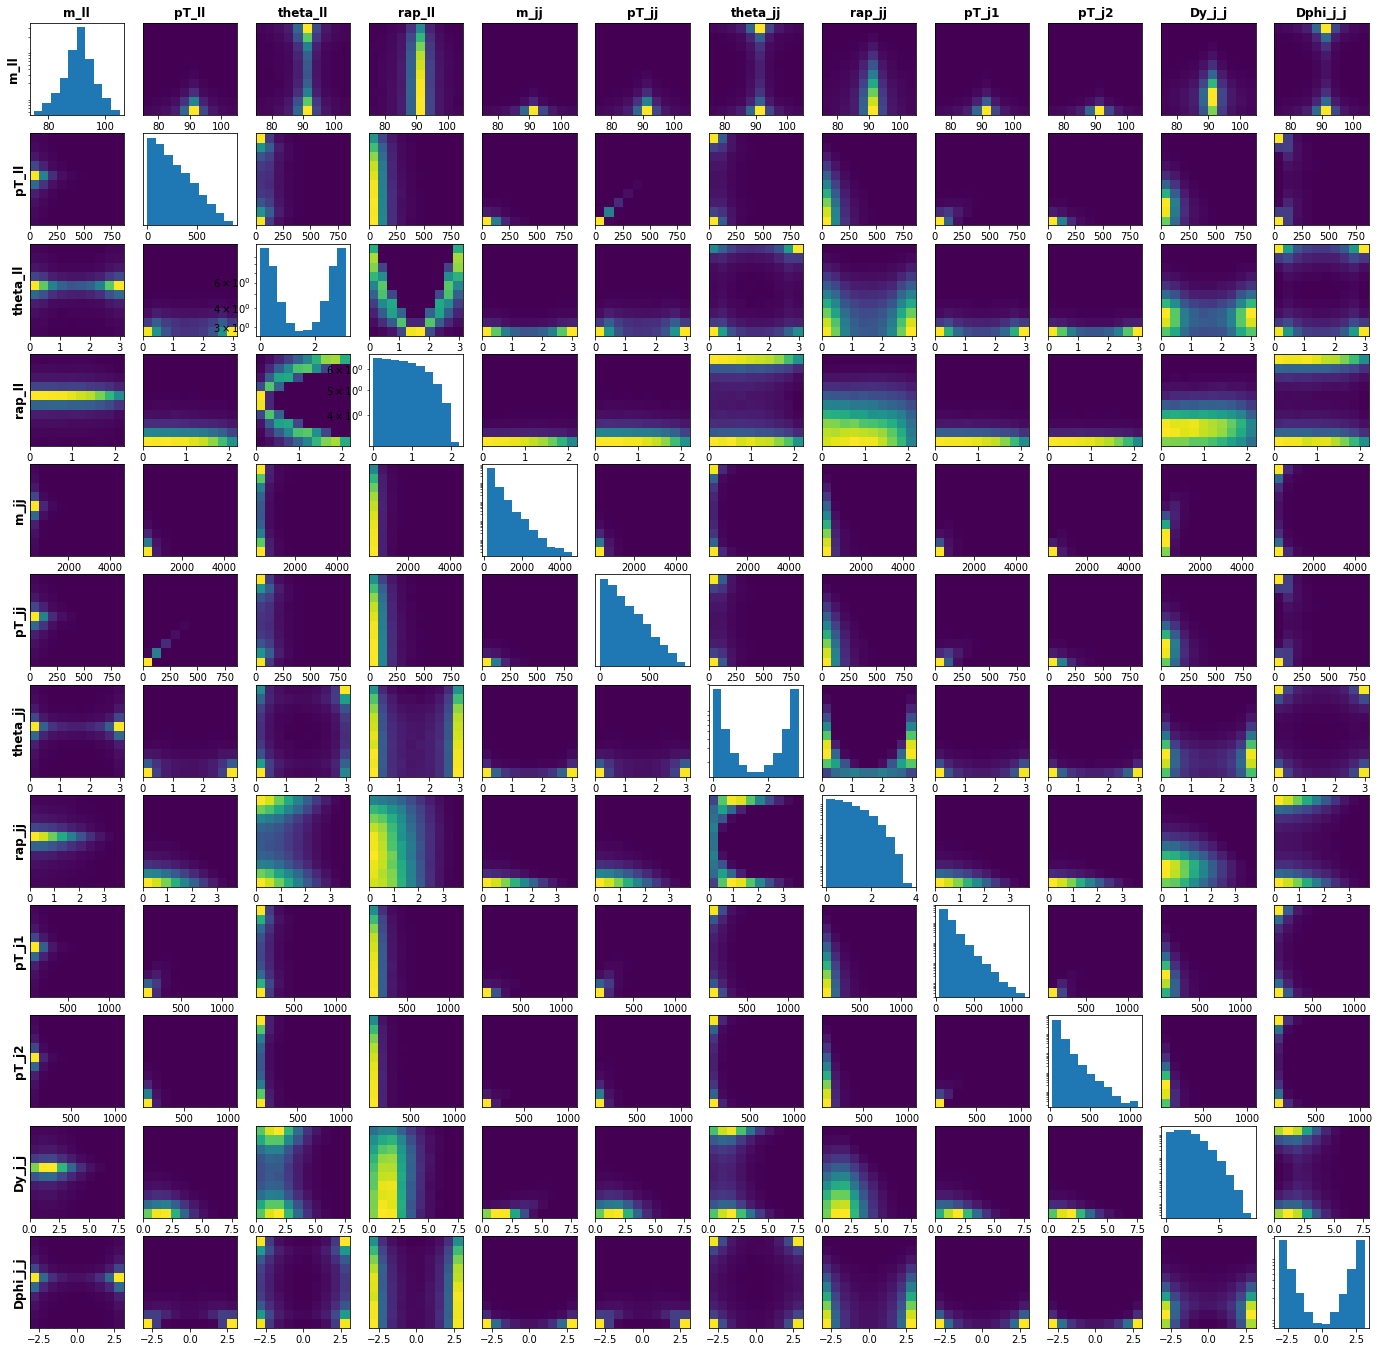

Num observables is 12


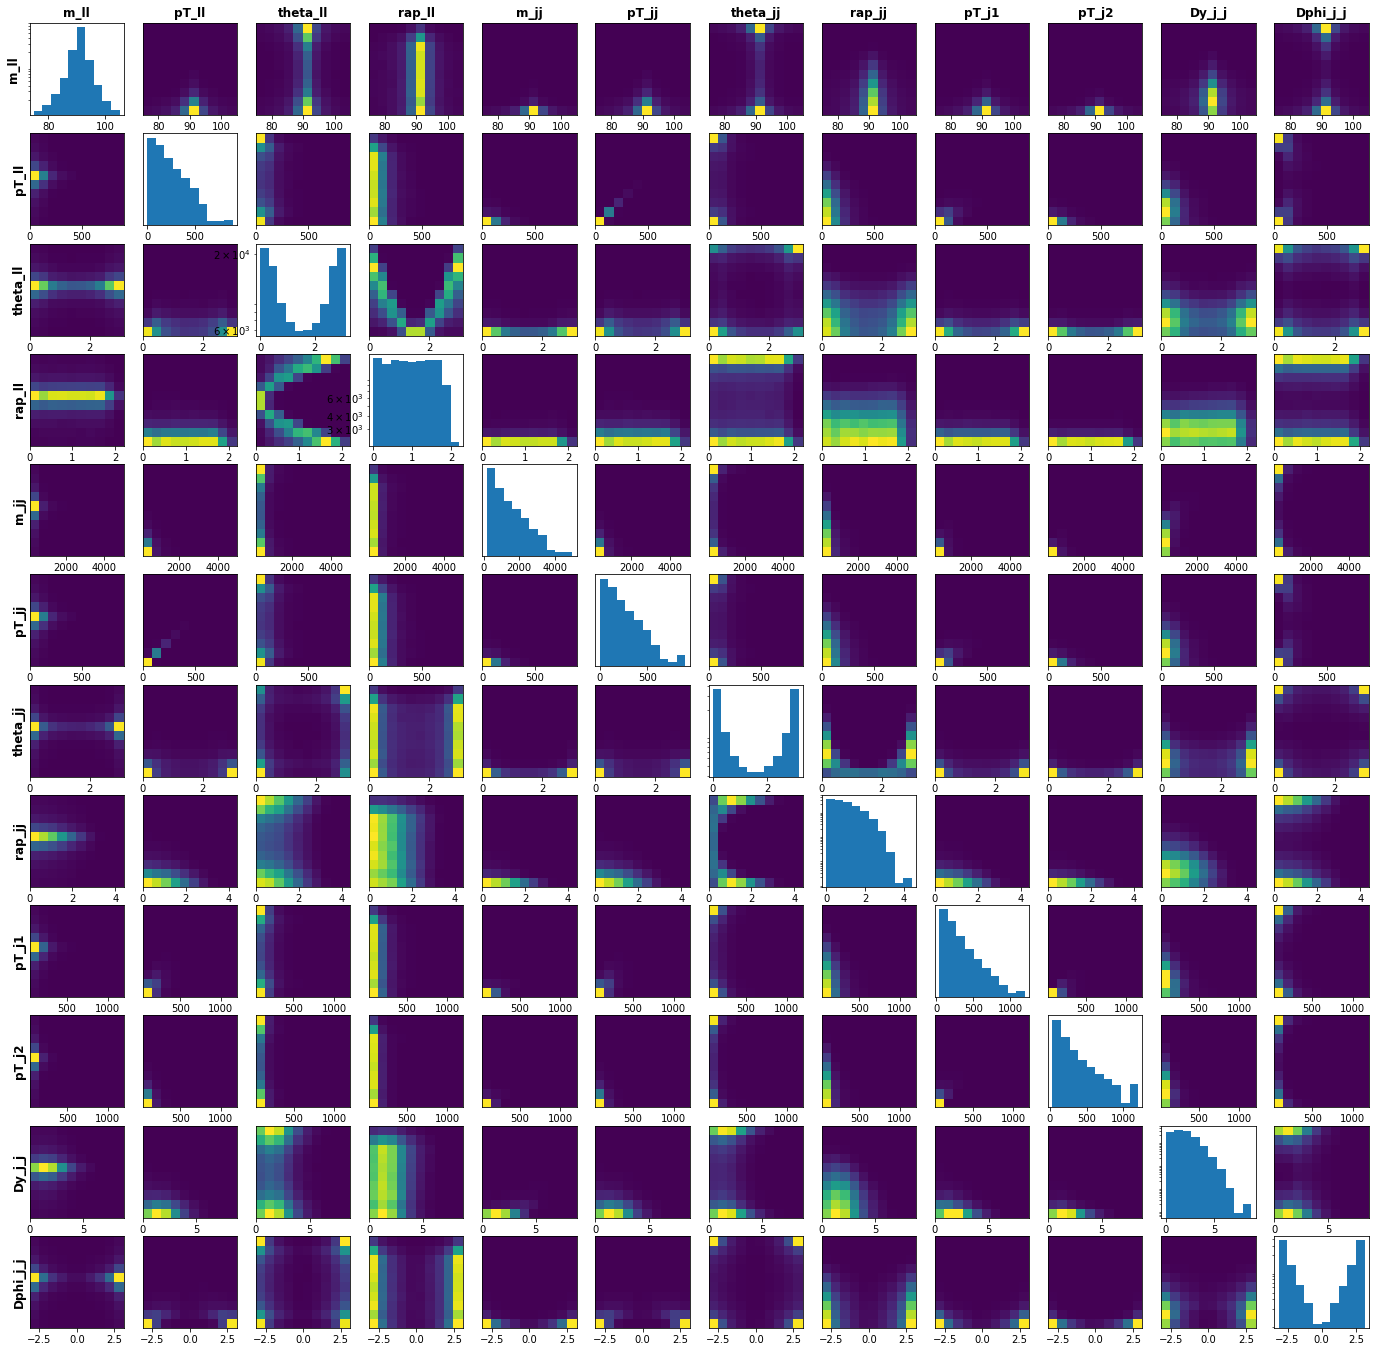

In [50]:
#  Plot all data

plot_data(observable_data, weight_data, save="../figures/get_QCD_density_true_fid.pdf")
plot_data(fake_datapoints, save="../figures/get_QCD_density_gen_fid.pdf")

Filtering m_jj between 1000 and 5000
Filtering Dy_j_j between 2 and 8.8
Num observables is 12


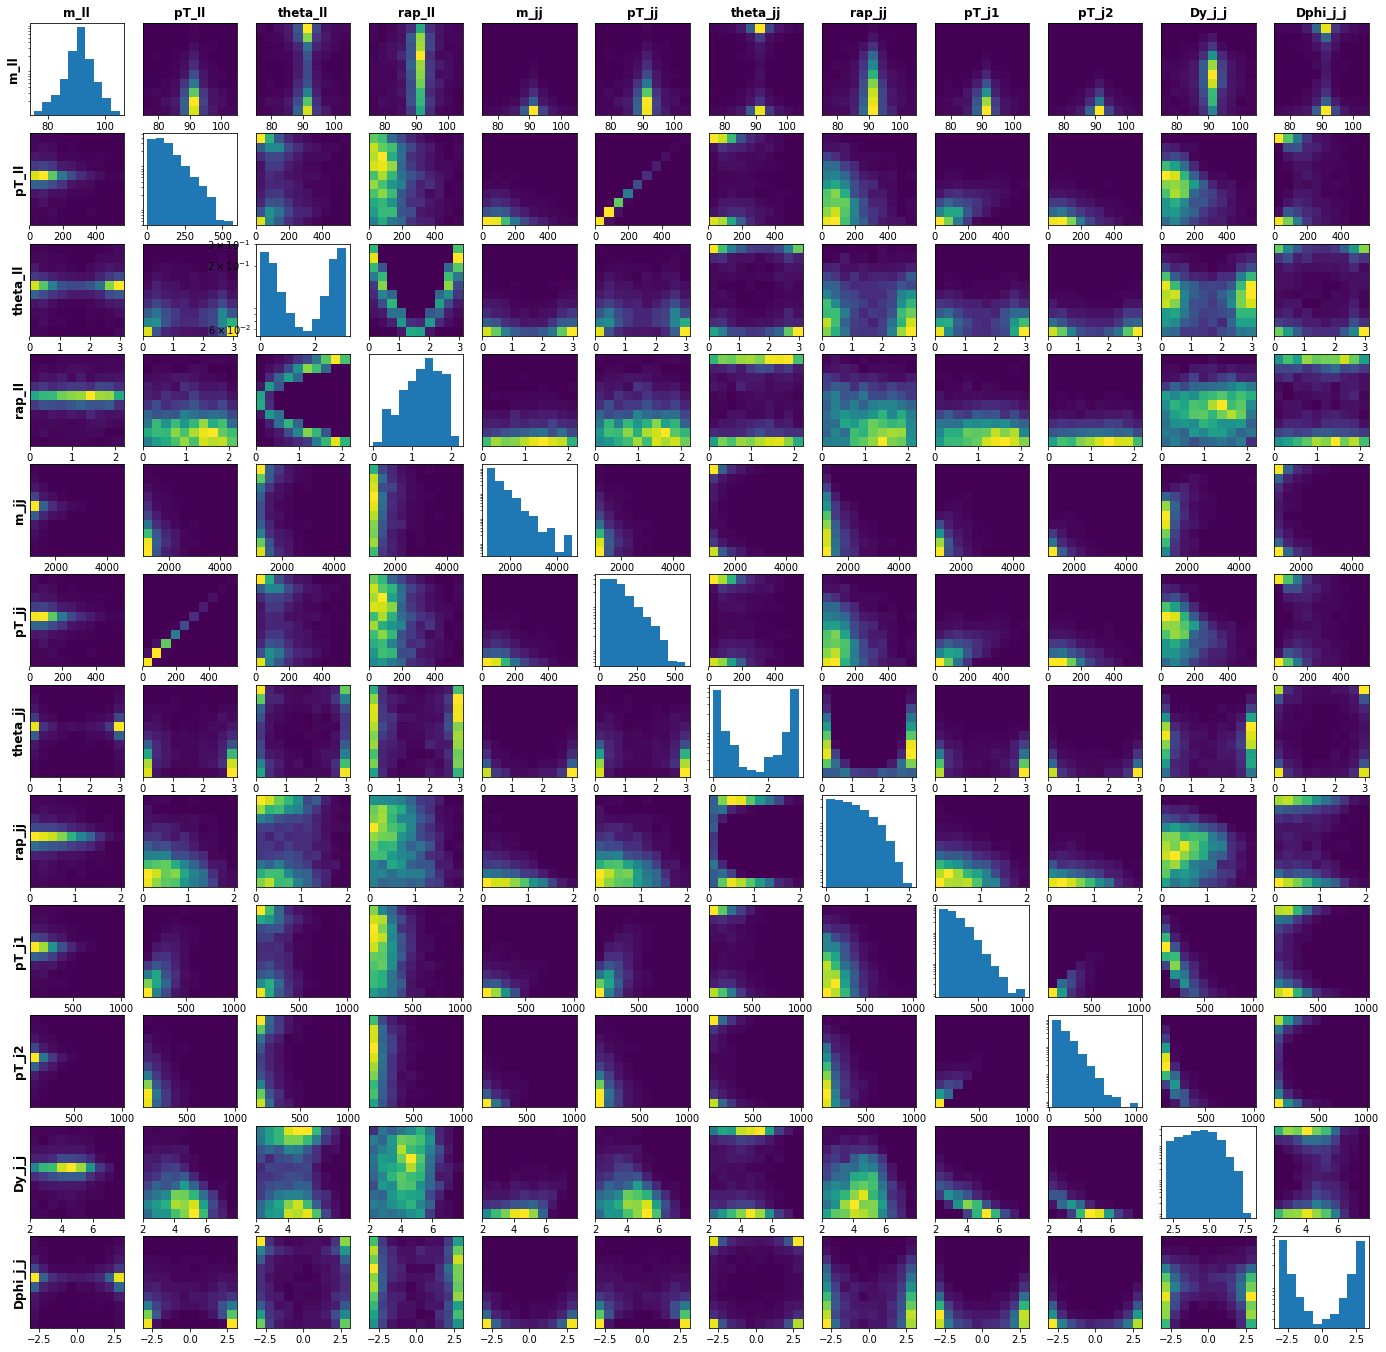

Filtering m_jj between 1000 and 5000
Filtering Dy_j_j between 2 and 8.8
Num observables is 12


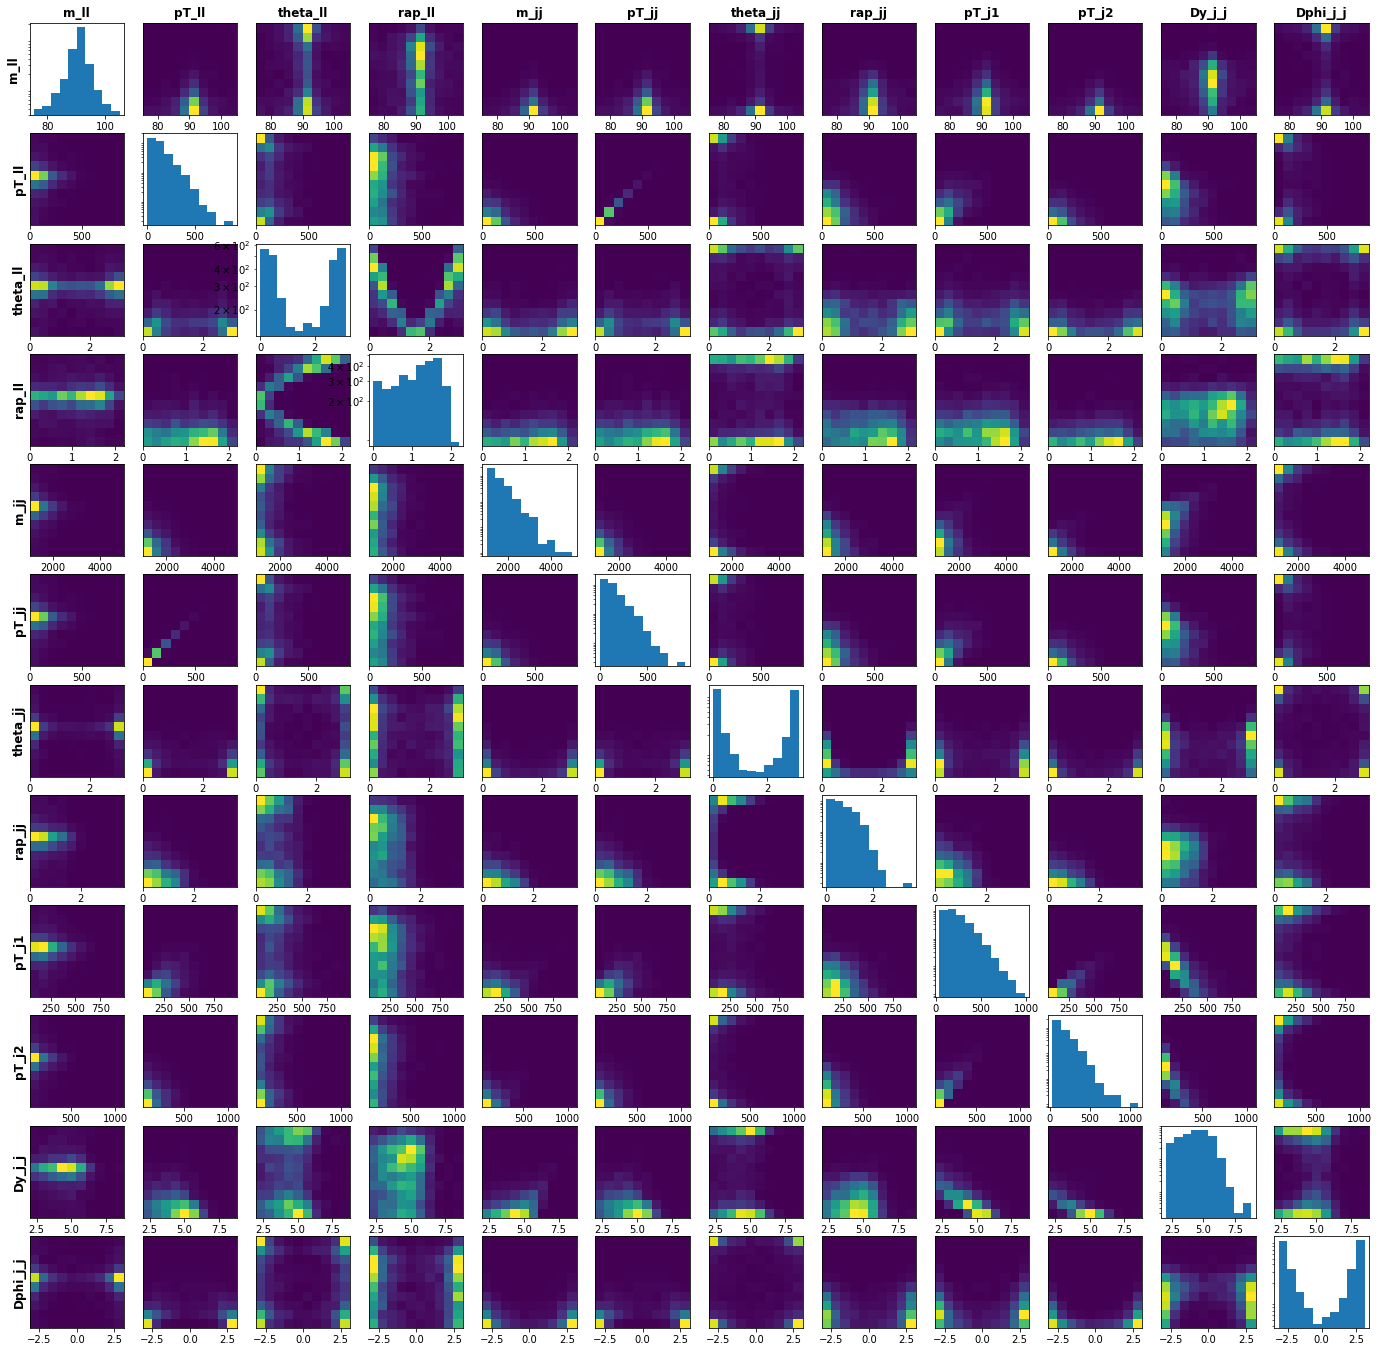

In [51]:
#  Plot data (VBF fiducial)

cuts = []
cuts.append(["m_jj"  , 1000, 5000])
cuts.append(["Dy_j_j", 2   , 8.8 ])

plot_data(observable_data, weight_data, cuts=cuts, save="../figures/get_QCD_density_true_VBF_like.pdf")
plot_data(fake_datapoints, cuts=cuts, save="../figures/get_QCD_density_gen_VBF_like.pdf")
